In [ ]:
pip install missingno

In [289]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno


file= "C:/Users/anshi/Downloads/PatientTimeSeries.csv"
df= pd.read_csv(file)
print(df)


        Patient_id     HR  O2Sat   Temp    SBP   MAP   DBP  Resp  EtCO2  \
0          p116812    NaN    NaN    NaN    NaN   NaN   NaN   NaN    NaN   
1          p116812  102.0  100.0    NaN    NaN   NaN   NaN  22.0    NaN   
2          p116812  102.0  100.0    NaN   99.0  84.0  76.0  18.5    NaN   
3          p116812  124.0  100.0    NaN   97.0  70.0  55.0  16.0    NaN   
4          p116812   98.0  100.0    NaN   95.0  73.0  62.0  18.0    NaN   
...            ...    ...    ...    ...    ...   ...   ...   ...    ...   
1048570    p016300   89.0  100.0  36.44   97.0  67.0  54.0  24.0    NaN   
1048571    p016300   92.0  100.0    NaN  130.0  86.0  62.0  21.0    NaN   
1048572    p016300   94.0  100.0    NaN  105.0  74.0  59.0  17.0    NaN   
1048573    p016300   95.0  100.0  36.89   89.0  65.0  53.0  20.0    NaN   
1048574    p016300   92.0  100.0    NaN  112.0  77.0  60.0  17.0    NaN   

         BaseExcess  ...  Hgb  PTT  WBC  Fibrinogen  Platelets    Age  Gender  \
0               Na

all features are of type float/int. This means that we don't have any strings/objects as erroneous values in these feature columns. Moreover, XGBoost doesn't support categorical data, therefore, its pertinent we check and convert any categorical feature to one-hot encoding. However, that situation doesnt arise here. 

In [5]:
df.dtypes

Patient_id           object
HR                  float64
O2Sat               float64
Temp                float64
SBP                 float64
MAP                 float64
DBP                 float64
Resp                float64
EtCO2               float64
BaseExcess          float64
HCO3                float64
FiO2                float64
pH                  float64
PaCO2               float64
SaO2                float64
AST                 float64
BUN                 float64
Alkalinephos        float64
Calcium             float64
Chloride            float64
Creatinine          float64
Bilirubin_direct    float64
Glucose             float64
Lactate             float64
Magnesium           float64
Phosphate           float64
Potassium           float64
Bilirubin_total     float64
TroponinI           float64
Hct                 float64
Hgb                 float64
PTT                 float64
WBC                 float64
Fibrinogen          float64
Platelets           float64
Age                 

We observe that none of the features are highly correlated with our dependent variable Sepsis Label. However, we must keep in mind that correlation is just one way to measure relationships between  variables and it might not capture all dynamics that an ML model can leverage. for eg, xgboost models can capture non-linear relationships unlike correlation which measures linearity only. Outliers can also disproportionately affect correlation coefficients. Therefore, we shall also control for outlliers in our project. 


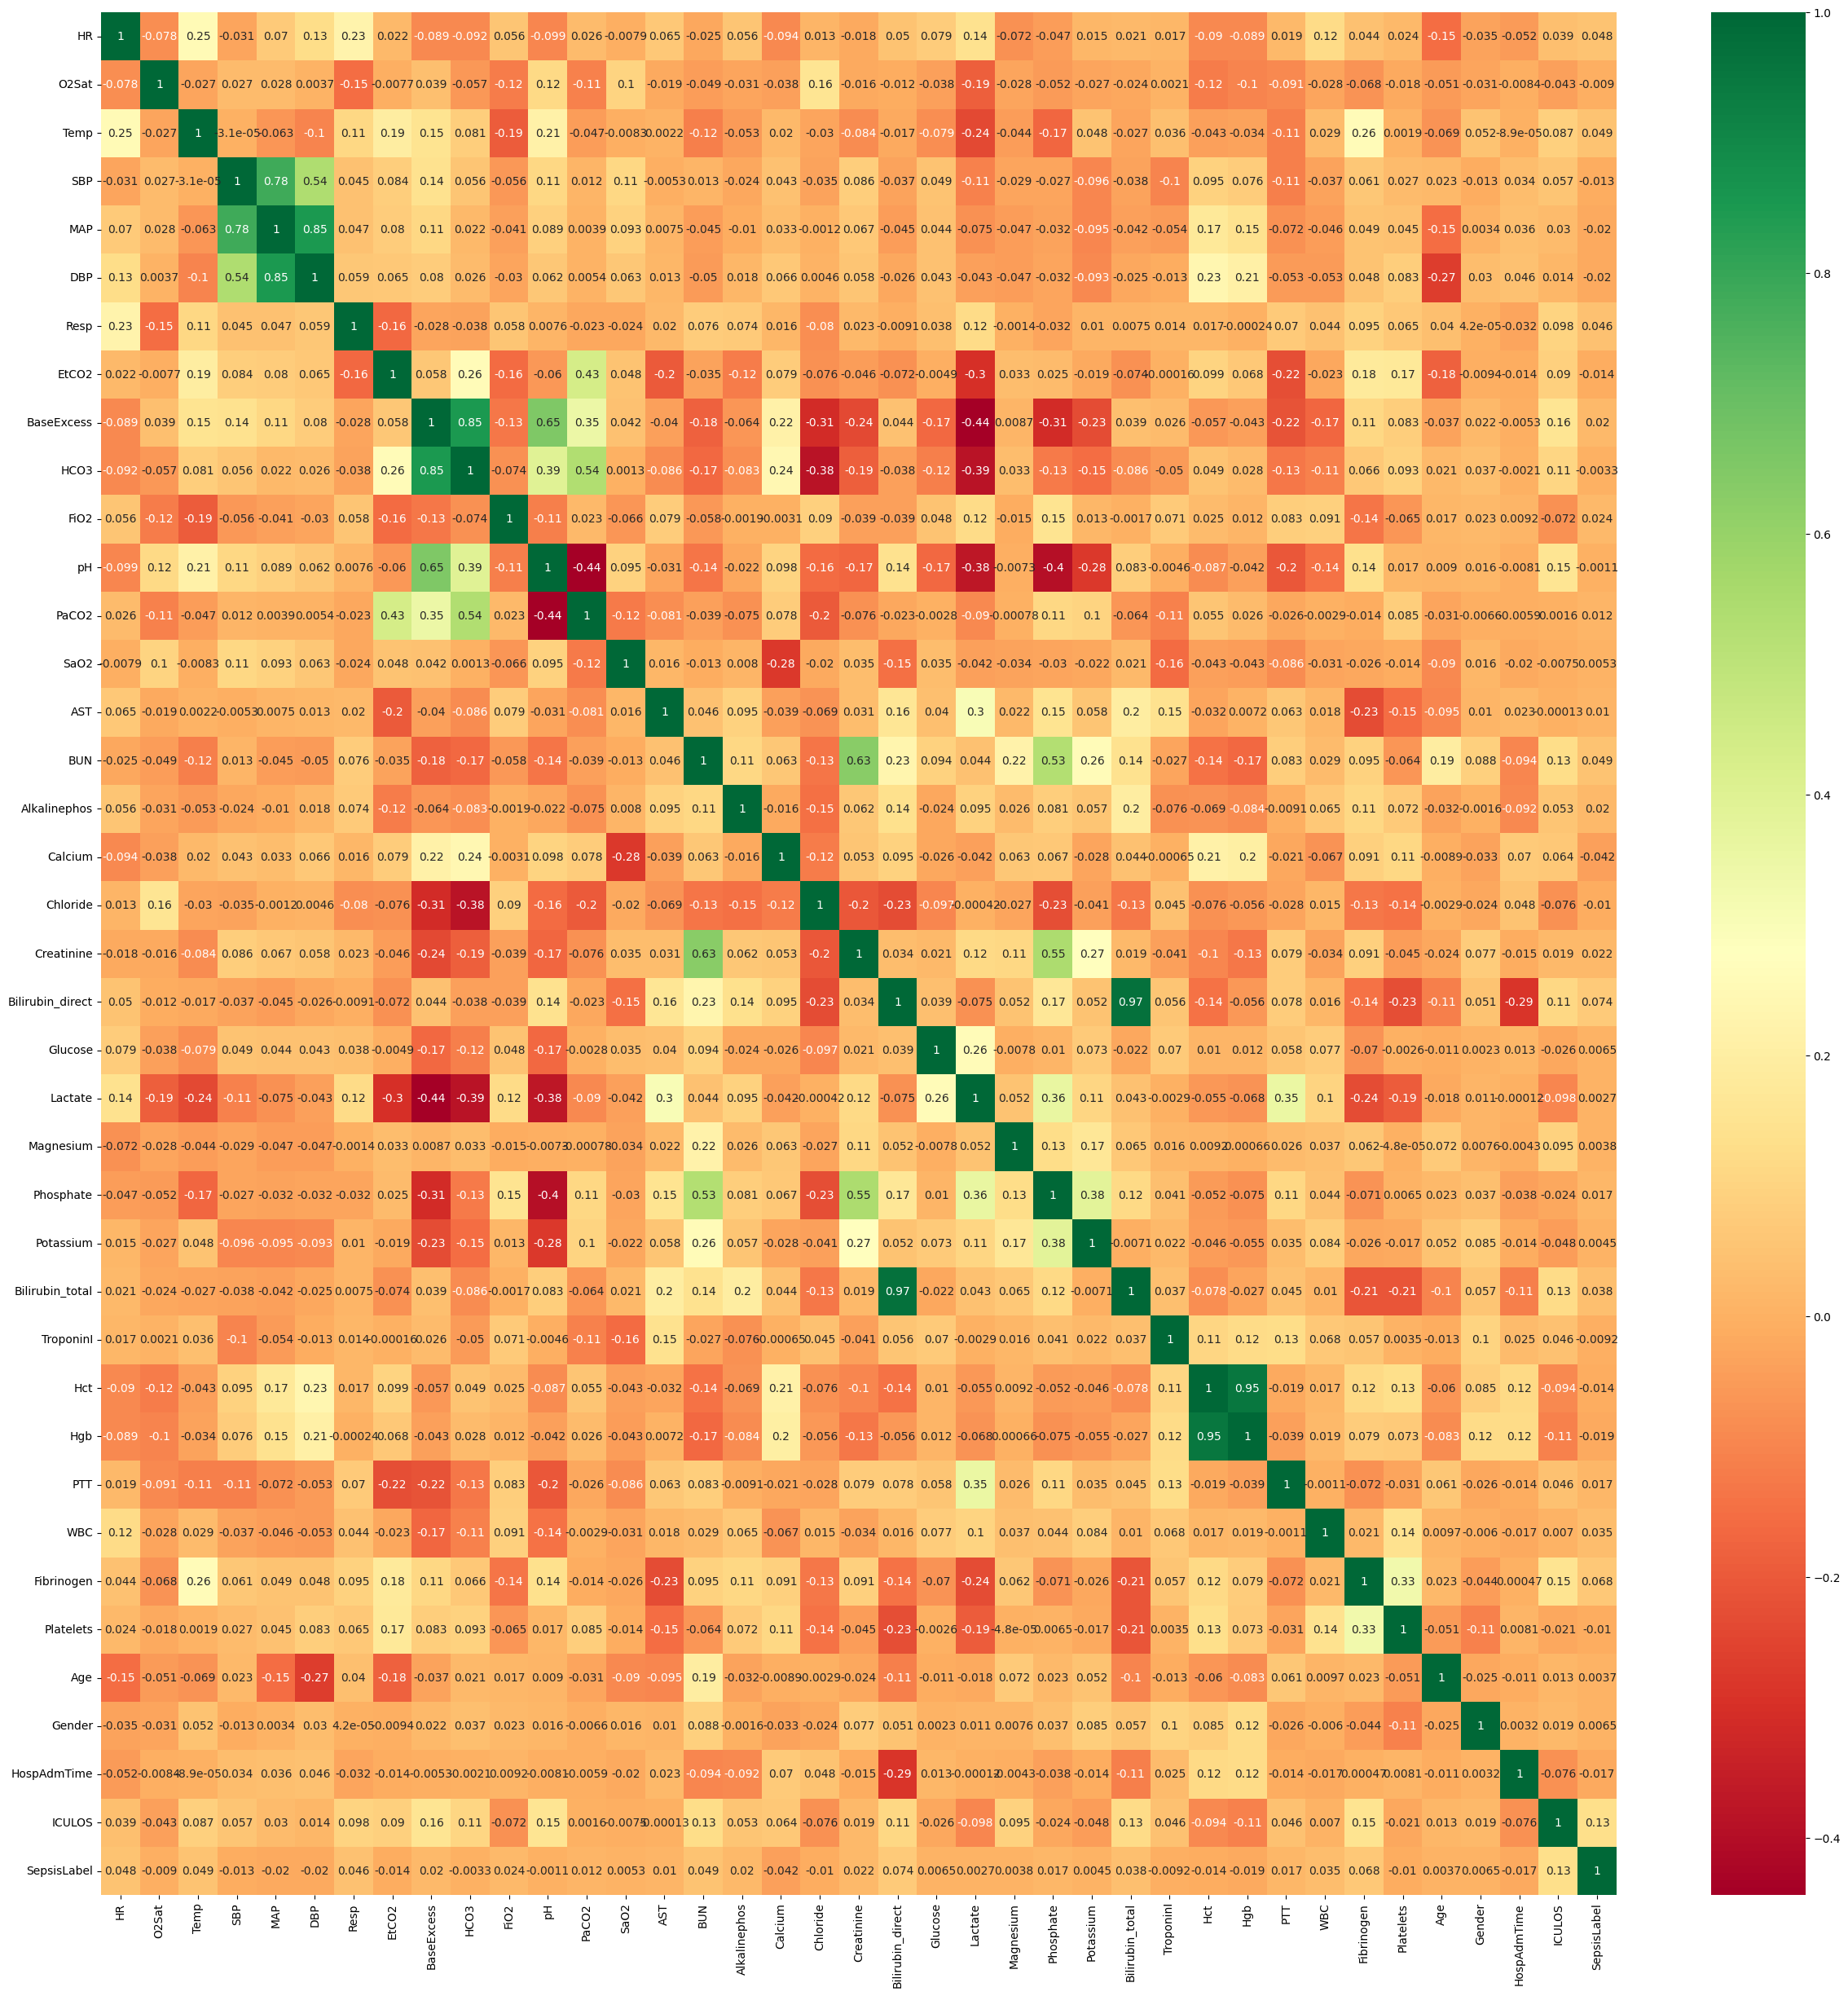

In [290]:
df_heatmap=df.drop('Patient_id', axis=1)
corrmat = df_heatmap.corr()
top_corr_features= corrmat.index
plt.figure(figsize=(30,30))
g=sns.heatmap(df_heatmap[top_corr_features].corr(),annot=True,cmap='RdYlGn')

boxplot to visually inspect presence of outliers/non-sensical values. we also need to familiarise ourselves with the literature to understand what values can be deemed erroneous/non-sensical.

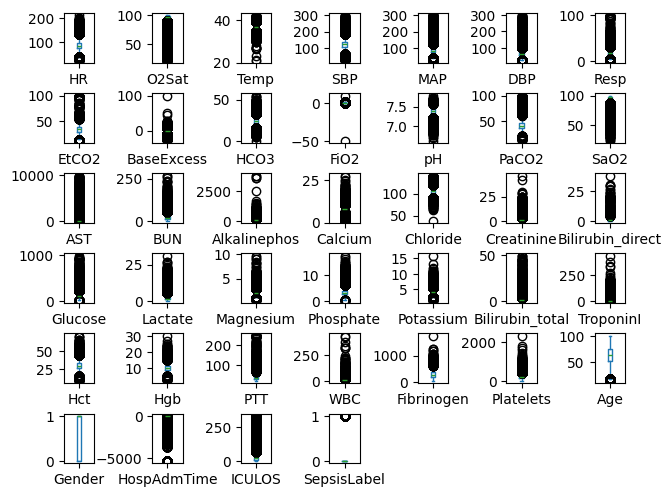

SepsisLabel
0    26909
1     1989
Name: Patient_id, dtype: int64


In [291]:

df.plot(kind='box', subplots=True, layout=(6, 7), sharex=False, sharey=False)
plt.tight_layout(pad=0.1, w_pad=0.1, h_pad=.1)
plt.show()

distribution = df.groupby('SepsisLabel')['Patient_id'].nunique()
print(distribution)



While XGBoost is robust to outliers, extremely influential outliers or erroneous values can still impact the stability of the model, especially if they are not representative of the underlying distribution of the data. Therefore, based on the general guidelines for what might be considered implausible, we shall replace such erroneous values with the aggregate value of the feature. 


HR (Heart Rate):

Values below 0 or extremely high values (e.g., > 300 bpm) may be considered impossible.
O2Sat (Pulse Oximetry):

Values outside the typical range of 0-100% may be considered impossible.
Temp (Temperature):

Extreme temperatures (e.g., below 20°C or above 45°C) may be considered impossible.
SBP (Systolic Blood Pressure):

Negative values or extremely high values (e.g., > 300 mm Hg) may be considered impossible.
MAP (Mean Arterial Pressure):

Negative values or values significantly outside the typical range for blood pressure may be considered impossible.
DBP (Diastolic Blood Pressure):

Negative values or extremely high values (e.g., > 200 mm Hg) may be considered impossible.
Resp (Respiration Rate):

Negative values or extremely high values (e.g., > 60 breaths per minute) may be considered impossible.
EtCO2 (End Tidal Carbon Dioxide):

Negative values or extremely high values (e.g., > 100 mm Hg) may be considered impossible.
BaseExcess (Excess Bicarbonate):

Values significantly outside the typical range for bicarbonate levels may be considered impossible.
HCO3 (Bicarbonate):

Values significantly outside the typical range for bicarbonate levels may be considered impossible. Bicarbonate (HCO3): 22 to 28 milliequivalents per liter (mEq/L) considered normal

FiO2 (Fraction of Inspired Oxygen):

Values outside the typical range of 0-100% may be considered impossible.
pH:

Values significantly outside the typical physiological range (e.g., <6 or >8) may be considered impossible.
PaCO2 (Partial Pressure of Carbon Dioxide):

Negative values or extremely high values (e.g., > 150 mm Hg) may be considered impossible.
SaO2 (Oxygen Saturation from Arterial Blood):

Values outside the typical range of 0-100% may be considered impossible.
AST (Aspartate Transaminase):

Values significantly outside the typical range for AST levels may be considered impossible. Biochemically, acetaminophen toxicity is associated with levels of AST and ALT often exceeding 10,000 IU/L. Suspected ehrlichiosis -mild to moderate increases in AST. AST levels should be drawn during the first week of the acute illness as mild to moderate elevations are noted in about 85% of patients. Therefore, we can infer that values above 5000 are possible.

BUN (Blood Urea Nitrogen):

Negative values or values significantly outside the typical range for BUN levels may be considered impossible.
Alkalinephos (Alkaline Phosphatase):

Values significantly outside the typical range for alkaline phosphatase levels may be considered impossible.
Calcium:

Values significantly outside the typical range for calcium levels may be considered impossible.
Chloride:

Values significantly outside the typical range for chloride levels may be considered impossible.
Creatinine:

Negative values or values significantly outside the typical range for creatinine levels may be considered impossible.
Bilirubin direct (Direct Bilirubin):

Values significantly outside the typical range for direct bilirubin levels may be considered impossible.
Glucose:

Negative values or values significantly outside the typical range for glucose levels may be considered impossible.
Lactate:

Values significantly outside the typical range for lactate levels may be considered impossible.
Magnesium:

Values significantly outside the typical range for magnesium levels may be considered impossible.
Phosphate:

Values significantly outside the typical range for phosphate levels may be considered impossible.
Potassium:

Negative values or values significantly outside the typical range for potassium levels may be considered impossible.
Bilirubin total (Total Bilirubin):

Values significantly outside the typical range for total bilirubin levels may be considered impossible.
TroponinI (Troponin I):

Values significantly outside the typical range for troponin I levels may be considered impossible.
Hct (Hematocrit):

Values significantly outside the typical range for hematocrit levels may be considered impossible.
Hgb (Hemoglobin):

Values significantly outside the typical range for hemoglobin levels may be considered impossible.
PTT (Partial Thromboplastin Time):

Negative values or values significantly outside the typical range for PTT may be considered impossible.
WBC (Leukocyte Count):

Negative values or values significantly outside the typical range for WBC count may be considered impossible.
Fibrinogen:

Values significantly outside the typical range for fibrinogen levels may be considered impossible.
Platelets:

Negative values or values significantly outside the typical range for platelet count may be considered impossible.

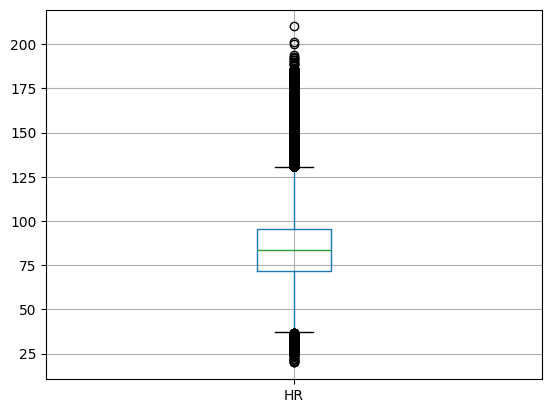

variable: HR 
 count    945030.000000
mean         84.572025
std          17.317288
min          20.000000
25%          72.000000
50%          83.500000
75%          95.500000
max         210.000000
Name: HR, dtype: float64
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


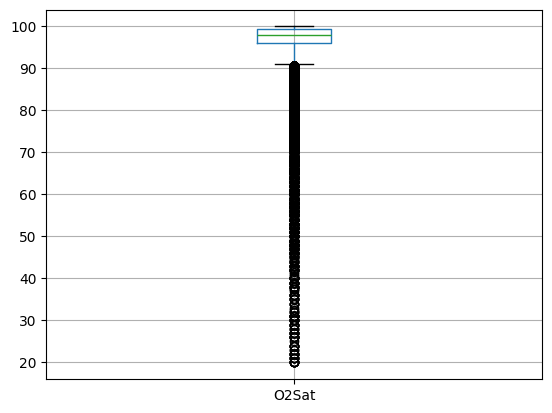

variable: O2Sat 
 count    911165.000000
mean         97.193494
std           2.948553
min          20.000000
25%          96.000000
50%          98.000000
75%          99.500000
max         100.000000
Name: O2Sat, dtype: float64
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


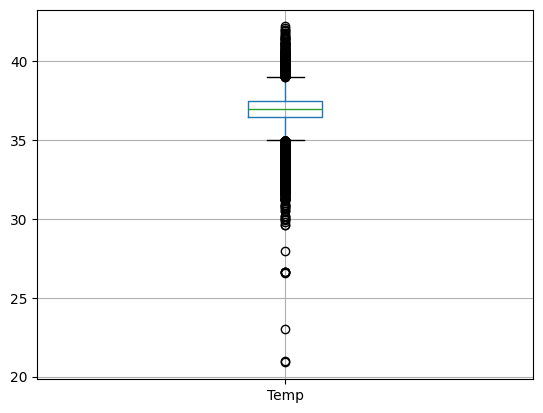

variable: Temp 
 count    351898.000000
mean         36.974508
std           0.767656
min          20.900000
25%          36.500000
50%          37.000000
75%          37.500000
max          42.220000
Name: Temp, dtype: float64
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


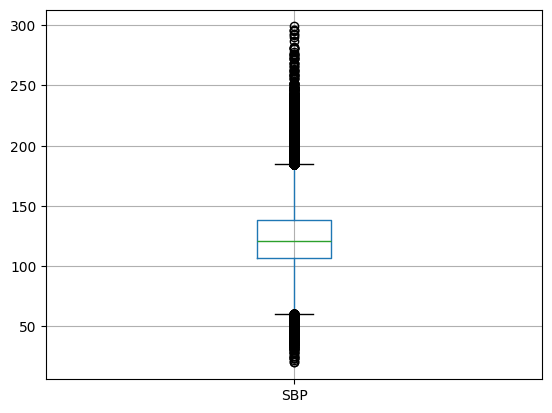

variable: SBP 
 count    896310.000000
mean        123.765946
std          23.256676
min          20.000000
25%         107.000000
50%         121.000000
75%         138.000000
max         299.000000
Name: SBP, dtype: float64
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


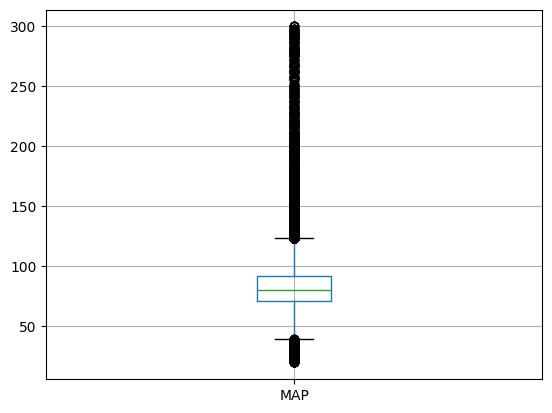

variable: MAP 
 count    918122.000000
mean         82.403395
std          16.341789
min          20.000000
25%          71.000000
50%          80.000000
75%          92.000000
max         300.000000
Name: MAP, dtype: float64
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


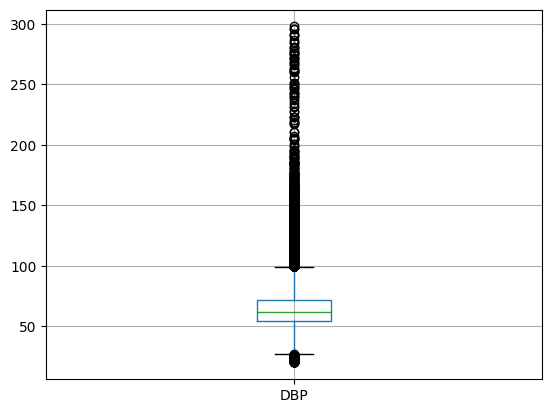

variable: DBP 
 count    721427.000000
mean         63.829379
std          13.961511
min          20.000000
25%          54.000000
50%          62.000000
75%          72.000000
max         298.000000
Name: DBP, dtype: float64
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


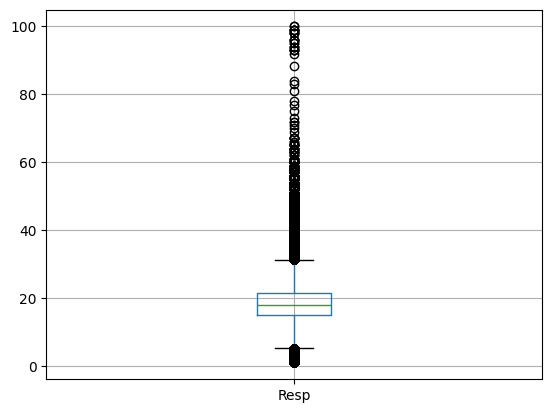

variable: Resp 
 count    887150.000000
mean         18.725505
std           5.081630
min           1.000000
25%          15.000000
50%          18.000000
75%          21.500000
max         100.000000
Name: Resp, dtype: float64
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


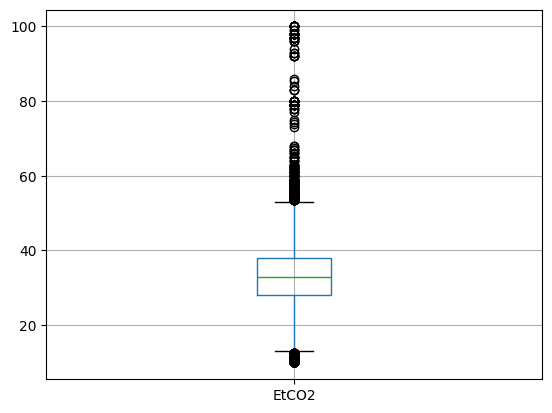

variable: EtCO2 
 count    38404.000000
mean        32.900036
std          8.022458
min         10.000000
25%         28.000000
50%         33.000000
75%         38.000000
max        100.000000
Name: EtCO2, dtype: float64
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


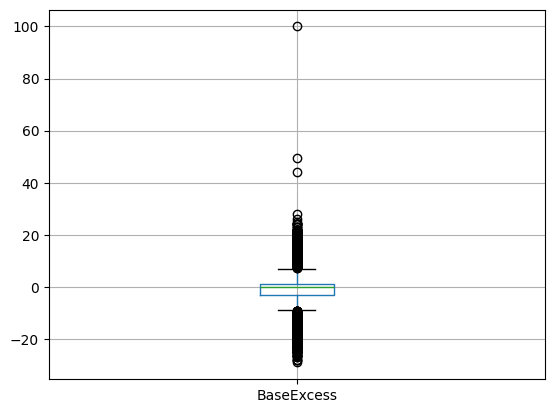

variable: BaseExcess 
 count    57094.000000
mean        -0.684051
std          4.273337
min        -29.000000
25%         -3.000000
50%          0.000000
75%          1.000000
max        100.000000
Name: BaseExcess, dtype: float64
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


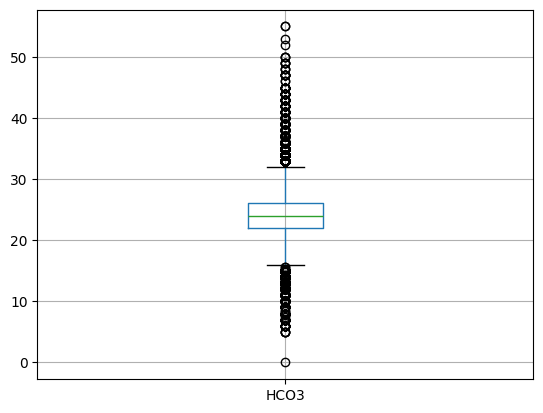

variable: HCO3 
 count    43994.000000
mean        24.063483
std          4.322053
min          0.000000
25%         22.000000
50%         24.000000
75%         26.050000
max         55.000000
Name: HCO3, dtype: float64
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


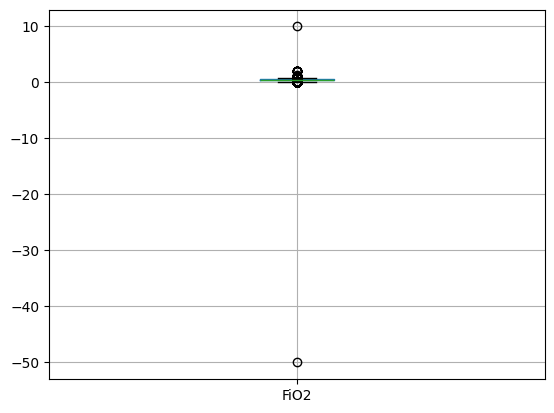

variable: FiO2 
 count    87896.000000
mean         0.524585
std          0.257851
min        -50.000000
25%          0.400000
50%          0.500000
75%          0.600000
max         10.000000
Name: FiO2, dtype: float64
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


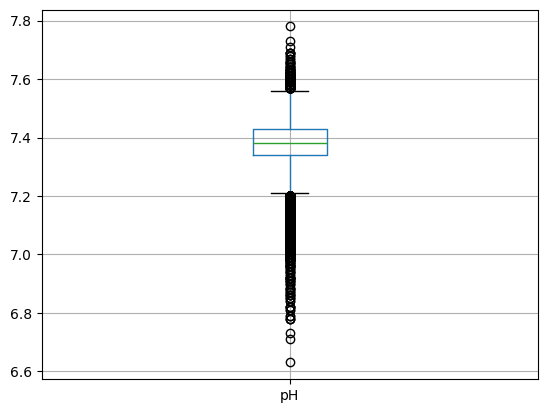

variable: pH 
 count    72535.000000
mean         7.379103
std          0.074618
min          6.630000
25%          7.340000
50%          7.380000
75%          7.430000
max          7.780000
Name: pH, dtype: float64
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


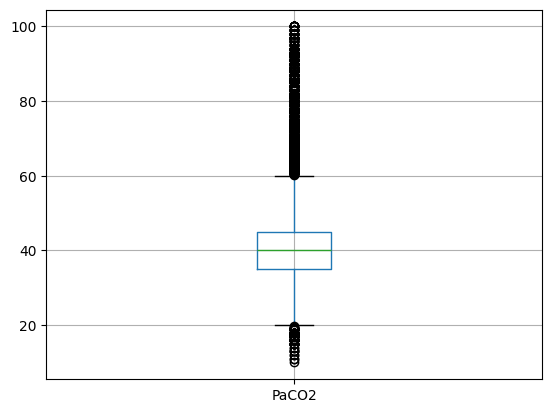

variable: PaCO2 
 count    58002.000000
mean        40.982871
std          9.230208
min         10.000000
25%         35.000000
50%         40.000000
75%         45.000000
max        100.000000
Name: PaCO2, dtype: float64
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


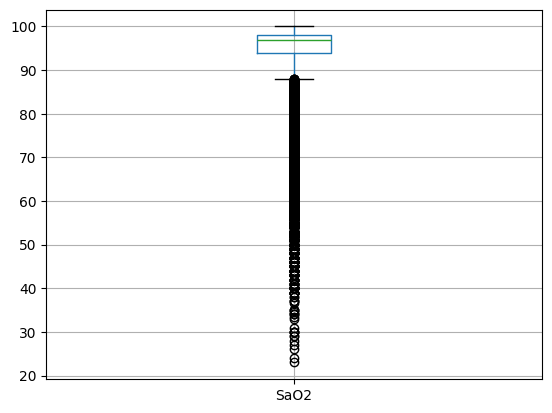

variable: SaO2 
 count    36008.000000
mean        92.513168
std         11.053270
min         23.000000
25%         94.000000
50%         97.000000
75%         98.000000
max        100.000000
Name: SaO2, dtype: float64
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


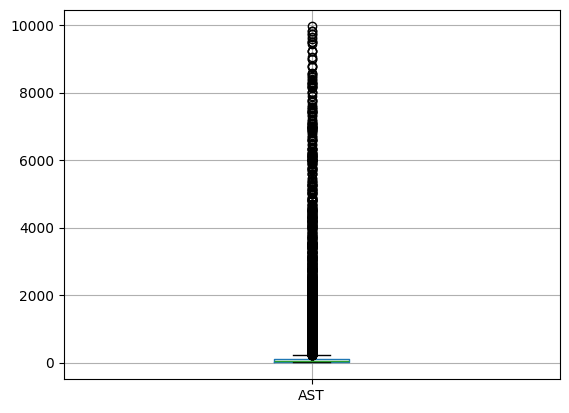

variable: AST 
 count    16878.000000
mean       256.463295
std        843.400884
min          3.000000
25%         22.000000
50%         41.000000
75%        108.000000
max       9961.000000
Name: AST, dtype: float64
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


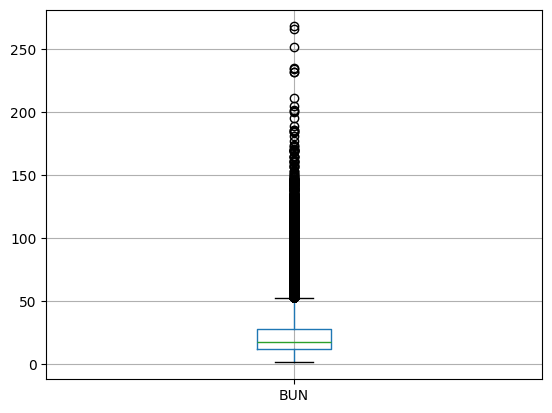

variable: BUN 
 count    71904.000000
mean        23.925839
std         20.045557
min          1.000000
25%         12.000000
50%         17.000000
75%         28.000000
max        268.000000
Name: BUN, dtype: float64
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


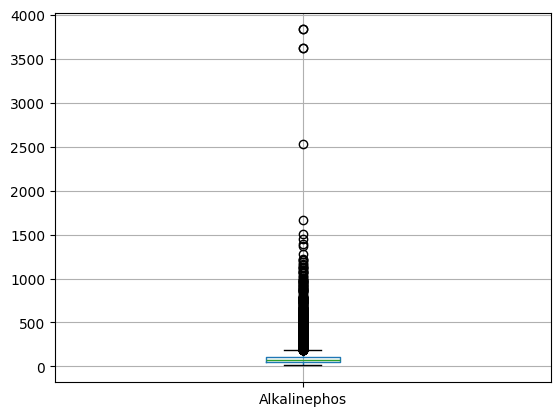

variable: Alkalinephos 
 count    16733.000000
mean       102.472719
std        116.680092
min         11.000000
25%         54.000000
50%         74.000000
75%        109.000000
max       3833.000000
Name: Alkalinephos, dtype: float64
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


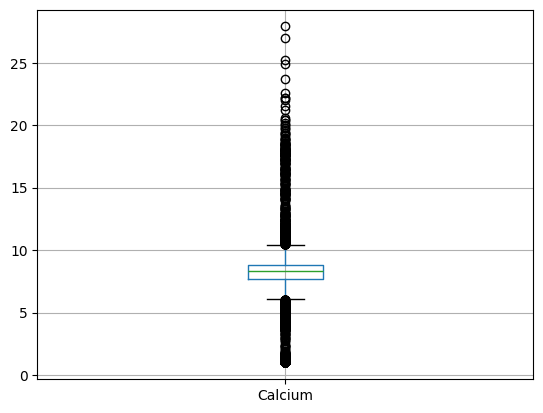

variable: Calcium 
 count    61285.000000
mean         7.591948
std          2.402272
min          1.000000
25%          7.700000
50%          8.300000
75%          8.800000
max         27.900000
Name: Calcium, dtype: float64
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


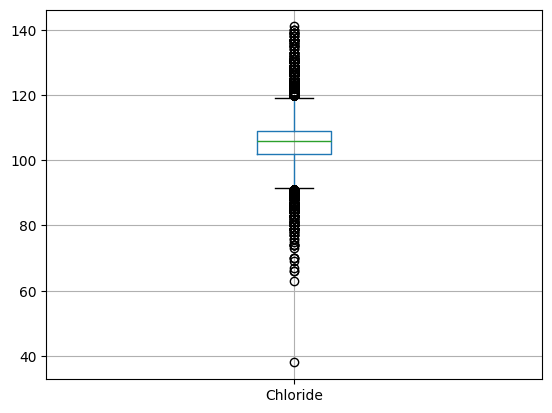

variable: Chloride 
 count    47540.000000
mean       105.845236
std          5.925110
min         38.000000
25%        102.000000
50%        106.000000
75%        109.000000
max        141.000000
Name: Chloride, dtype: float64
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


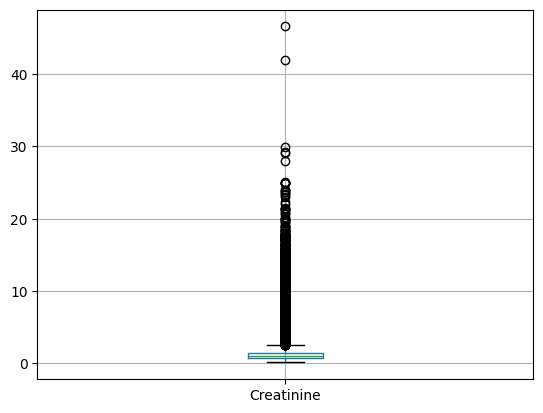

variable: Creatinine 
 count    63750.000000
mean         1.521419
std          1.830482
min          0.100000
25%          0.700000
50%          0.940000
75%          1.450000
max         46.600000
Name: Creatinine, dtype: float64
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


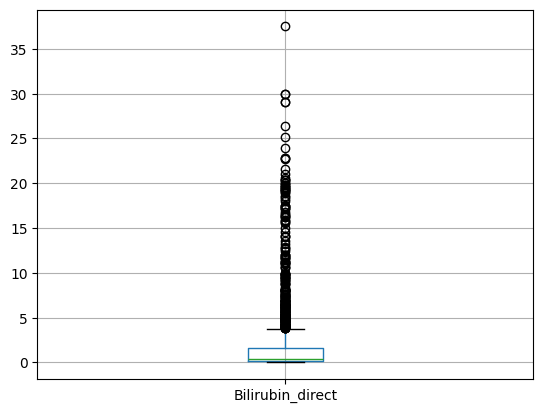

variable: Bilirubin_direct 
 count    2081.000000
mean        1.821970
std         3.711331
min         0.010000
25%         0.200000
50%         0.400000
75%         1.600000
max        37.500000
Name: Bilirubin_direct, dtype: float64
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


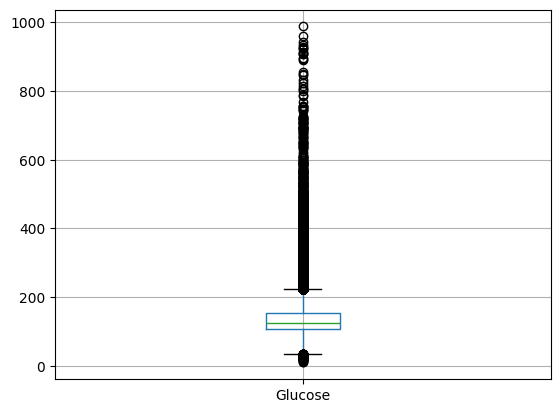

variable: Glucose 
 count    177997.000000
mean        137.091341
std          51.990466
min          10.000000
25%         106.000000
50%         126.000000
75%         153.000000
max         988.000000
Name: Glucose, dtype: float64
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


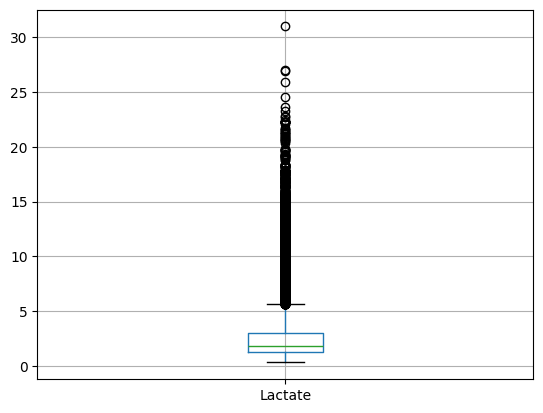

variable: Lactate 
 count    27821.000000
mean         2.624761
std          2.491746
min          0.300000
25%          1.260000
50%          1.800000
75%          3.000000
max         31.000000
Name: Lactate, dtype: float64
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


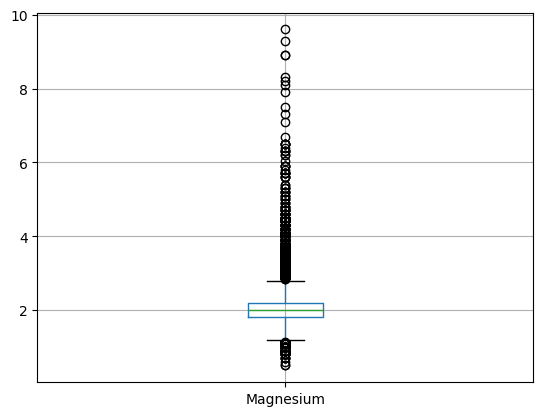

variable: Magnesium 
 count    66216.000000
mean         2.050691
std          0.397301
min          0.500000
25%          1.800000
50%          2.000000
75%          2.200000
max          9.600000
Name: Magnesium, dtype: float64
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


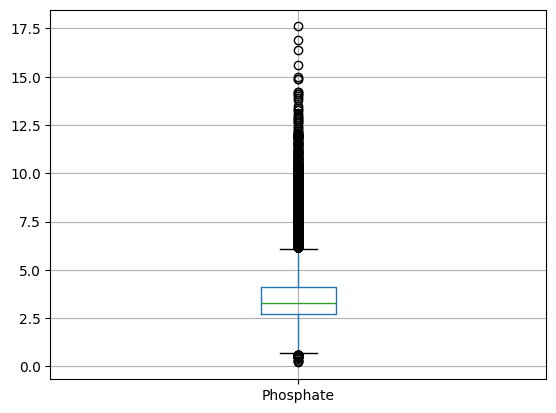

variable: Phosphate 
 count    42046.000000
mean         3.551584
std          1.421452
min          0.200000
25%          2.700000
50%          3.300000
75%          4.100000
max         17.600000
Name: Phosphate, dtype: float64
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


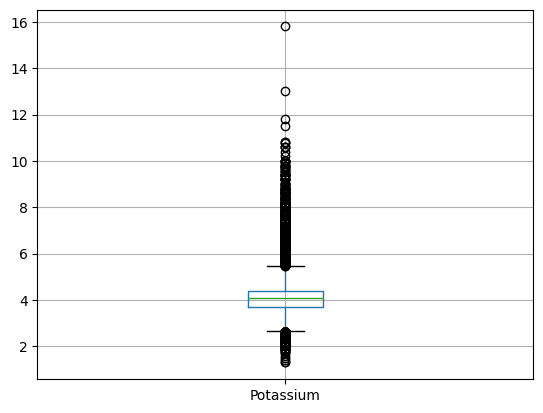

variable: Potassium 
 count    96962.000000
mean         4.134140
std          0.643683
min          1.300000
25%          3.700000
50%          4.100000
75%          4.400000
max         15.800000
Name: Potassium, dtype: float64
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


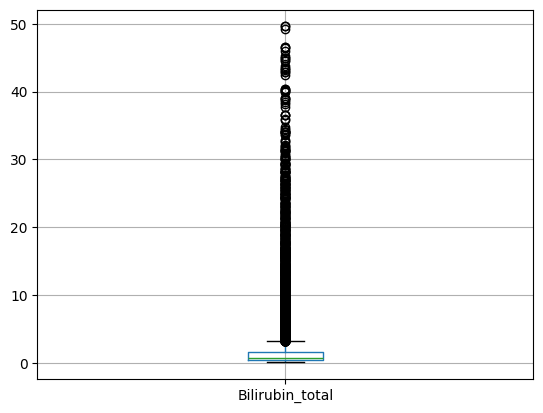

variable: Bilirubin_total 
 count    15498.000000
mean         2.019299
std          4.057334
min          0.100000
25%          0.500000
50%          0.800000
75%          1.600000
max         49.600000
Name: Bilirubin_total, dtype: float64
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


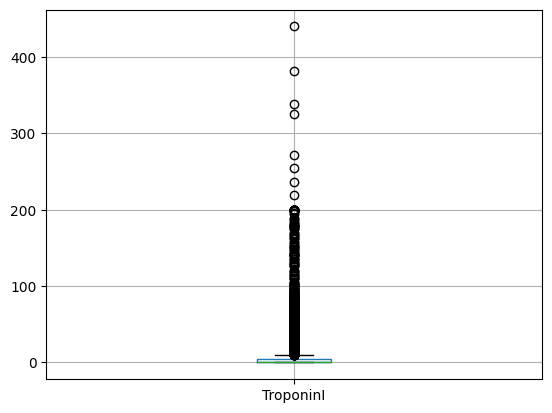

variable: TroponinI 
 count    10087.000000
mean         8.437266
std         24.640859
min          0.010000
25%          0.040000
50%          0.290000
75%          4.115000
max        440.000000
Name: TroponinI, dtype: float64
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


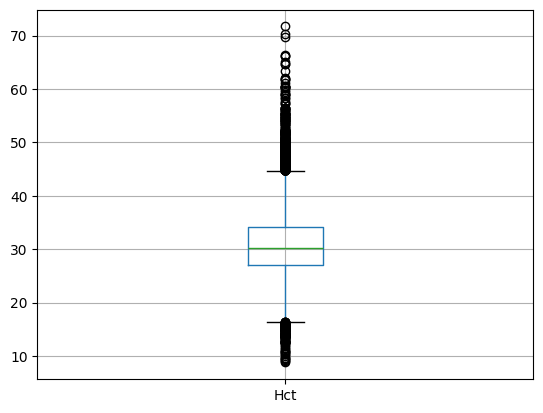

variable: Hct 
 count    92815.000000
mean        30.787910
std          5.487749
min          8.800000
25%         27.000000
50%         30.200000
75%         34.100000
max         71.700000
Name: Hct, dtype: float64
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


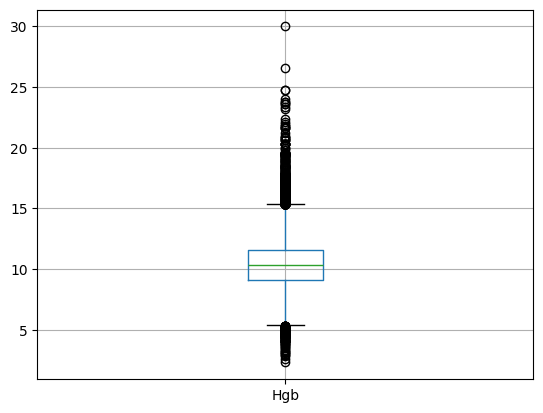

variable: Hgb 
 count    77254.000000
mean        10.425548
std          1.966090
min          2.300000
25%          9.100000
50%         10.300000
75%         11.600000
max         30.000000
Name: Hgb, dtype: float64
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


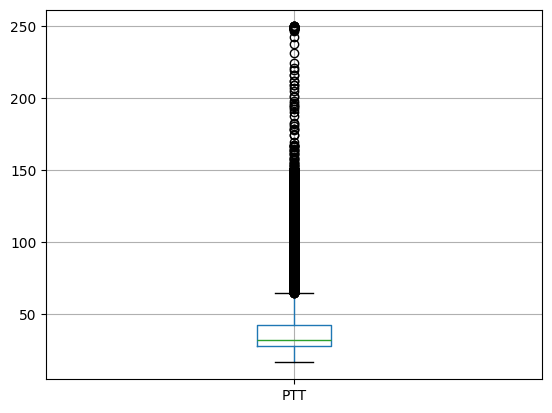

variable: PTT 
 count    30944.000000
mean        41.245061
std         26.345071
min         16.600000
25%         27.800000
50%         32.400000
75%         42.725000
max        250.000000
Name: PTT, dtype: float64
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


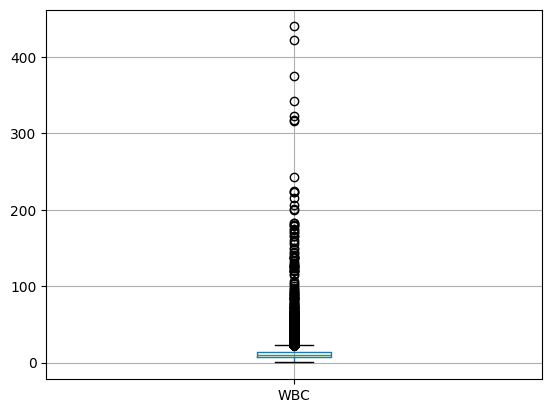

variable: WBC 
 count    67082.000000
mean        11.498152
std          8.014632
min          0.100000
25%          7.600000
50%         10.300000
75%         13.800000
max        440.000000
Name: WBC, dtype: float64
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


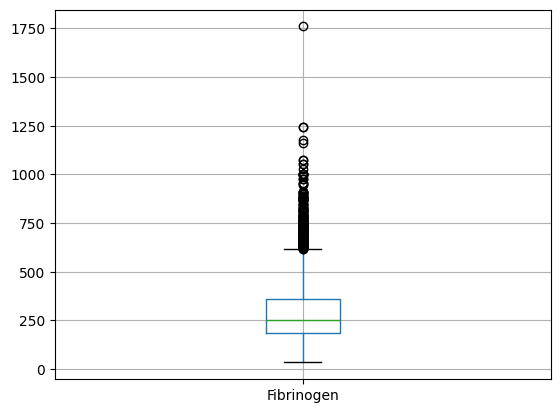

variable: Fibrinogen 
 count    6789.000000
mean      291.217631
std       153.929954
min        34.000000
25%       185.000000
50%       254.000000
75%       358.000000
max      1760.000000
Name: Fibrinogen, dtype: float64
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


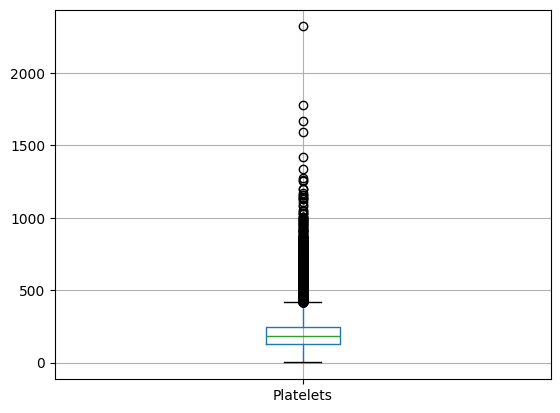

variable: Platelets 
 count    61992.000000
mean       197.033750
std        104.432275
min          1.000000
25%        127.000000
50%        181.000000
75%        244.000000
max       2322.000000
Name: Platelets, dtype: float64
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


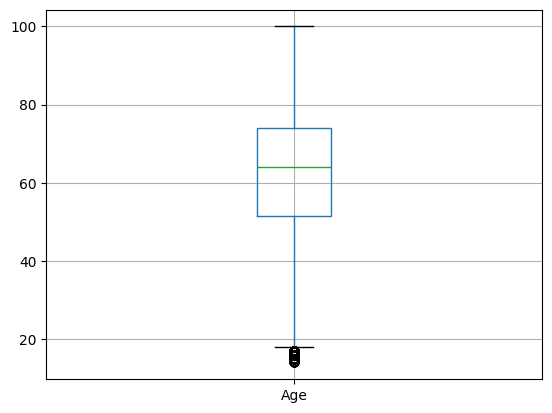

variable: Age 
 count    1.048575e+06
mean     6.196167e+01
std      1.641458e+01
min      1.400000e+01
25%      5.139000e+01
50%      6.400000e+01
75%      7.400000e+01
max      1.000000e+02
Name: Age, dtype: float64
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


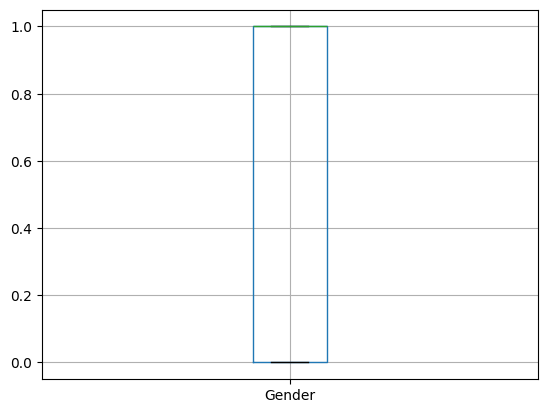

variable: Gender 
 count    1.048575e+06
mean     5.604330e-01
std      4.963347e-01
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: Gender, dtype: float64
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


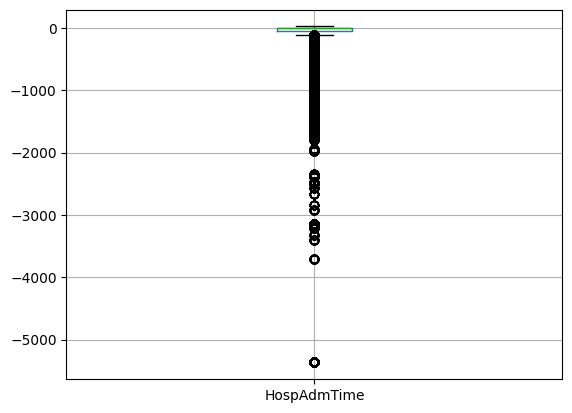

variable: HospAdmTime 
 count    1.048567e+06
mean    -5.678107e+01
std      1.718362e+02
min     -5.366860e+03
25%     -4.687000e+01
50%     -6.030000e+00
75%     -4.000000e-02
max      2.204000e+01
Name: HospAdmTime, dtype: float64
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


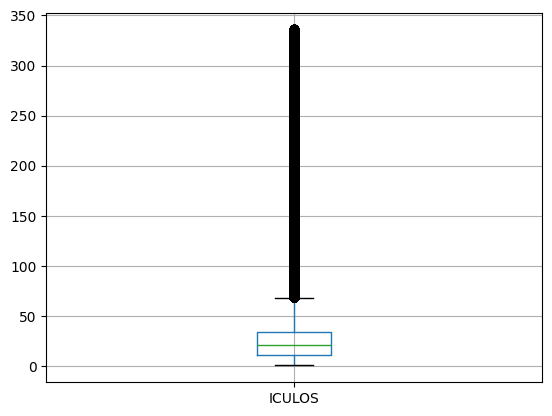

variable: ICULOS 
 count    1.048575e+06
mean     2.702792e+01
std      2.912929e+01
min      1.000000e+00
25%      1.100000e+01
50%      2.100000e+01
75%      3.400000e+01
max      3.360000e+02
Name: ICULOS, dtype: float64
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


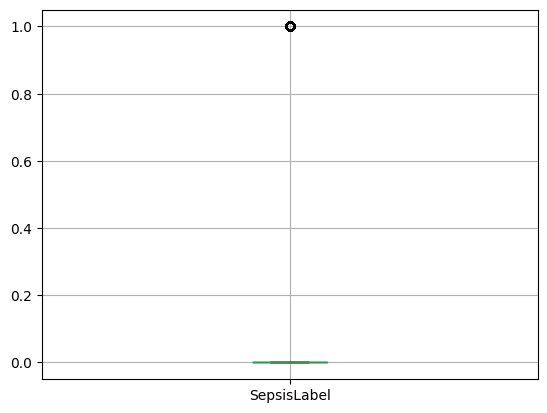

variable: SepsisLabel 
 count    1.048575e+06
mean     1.805307e-02
std      1.331434e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+00
Name: SepsisLabel, dtype: float64
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


In [292]:
for var in df.columns:
  if var!= 'Patient_id':
    df.boxplot(column=[var])
    plt.show()
    print('variable:', var,'\n', df[var].describe())
    print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')


Given my limited understanding of medical concepts and relying on the scarce literature available online regarding implausible values in these features, I determined impossible values by assessing the extreme deviation of outliers from the boxplot. Additionally, I considered any information from online sources, particularly focusing on the minimum and maximum values reported in the literature. Now we shall replace these extreme values with the mean of the feature. 

In [294]:
#calculate mean exclusing values greater than or less than extreme values we selected

def mean(outlier, feature):
    mean= df.loc[df[feature]<outlier, feature].mean()
    print(mean)
    return mean 

def mean_below(outlier, feature):
    mean= df.loc[df[feature]>outlier, feature].mean()
    print(mean)
    return mean 

df.loc[df['Resp']>=60, 'Resp'] = mean(60, 'Resp')
df.loc[df['BaseExcess']>=40, 'BaseExcess'] = mean(40, 'BaseExcess')

df_1= df[df['FiO2']<1]
df_0 = df[df['FiO2']>0]
df_combined = pd.concat([df_1, df_0], ignore_index=True)
mean_fi02 = df_combined['FiO2'].mean()
df.loc[df['FiO2']<0,'FiO2'] = mean_fi02
df.loc[df['FiO2']>1,'FiO2'] = mean_fi02


df.loc[df['Alkalinephos']>=2000, 'Alkalinephos'] = mean(2000, 'Alkalinephos')
df.loc[df['Creatinine']>=40, 'Creatinine'] = mean(40, 'Creatinine')
df.loc[df['Bilirubin_direct']>=30, 'Bilirubin_direct'] = mean(30, 'Bilirubin_direct')
df.loc[df['Chloride']<40, 'Chloride'] = mean_below(40, 'Chloride')
df.loc[df['Potassium']>=12, 'Potassium'] = mean(12, 'Potassium')
df.loc[df['TroponinI']>=300, 'TroponinI'] = mean(300, 'TroponinI')
df.loc[df['Hgb']>25, 'Hgb'] = mean(25, 'Hgb')
df.loc[df['Fibrinogen']>1250, 'Fibrinogen'] = mean(1250, 'Fibrinogen')
df.loc[df['Platelets']>2000, 'Platelets'] = mean(2000, 'Platelets')



    

18.72000219826799
-0.6874761345921423
101.46126255380202
1.5200784338332185
1.7776804619826756
105.84666274006605
4.133928320957095
8.293253000099176
10.425084916895354
291.00125220978197
196.99947089093578


In [295]:
df_1= df[df['FiO2']<1]
df_0 = df[df['FiO2']>0]
df_combined = pd.concat([df_1, df_0], ignore_index=True)

mean = df_combined['FiO2'].mean()
mean

0.5025702719975377

In [296]:
for var in df.columns:
    print(df[var].describe())



count     1048575
unique      27186
top       p117406
freq          336
Name: Patient_id, dtype: object
count    945030.000000
mean         84.572025
std          17.317288
min          20.000000
25%          72.000000
50%          83.500000
75%          95.500000
max         210.000000
Name: HR, dtype: float64
count    911165.000000
mean         97.193494
std           2.948553
min          20.000000
25%          96.000000
50%          98.000000
75%          99.500000
max         100.000000
Name: O2Sat, dtype: float64
count    351898.000000
mean         36.974508
std           0.767656
min          20.900000
25%          36.500000
50%          37.000000
75%          37.500000
max          42.220000
Name: Temp, dtype: float64
count    896310.000000
mean        123.765946
std          23.256676
min          20.000000
25%         107.000000
50%         121.000000
75%         138.000000
max         299.000000
Name: SBP, dtype: float64
count    918122.000000
mean         82.403395
std     

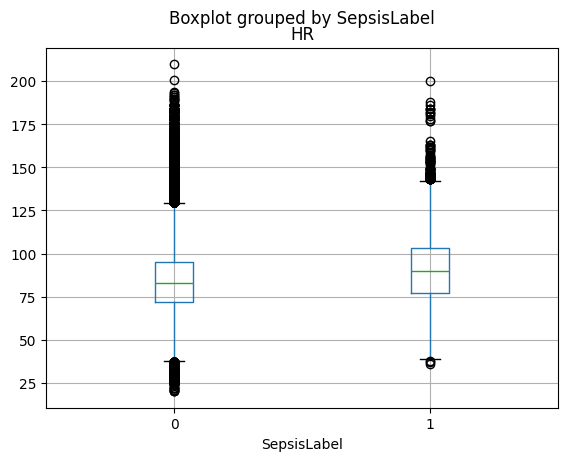

variable: HR 
                 count       mean        std   min   25%   50%    75%    max
SepsisLabel                                                                
0            927601.0  84.458458  17.264282  20.0  72.0  83.0   95.0  210.0
1             17429.0  90.616243  18.980177  36.0  77.0  90.0  103.0  200.0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


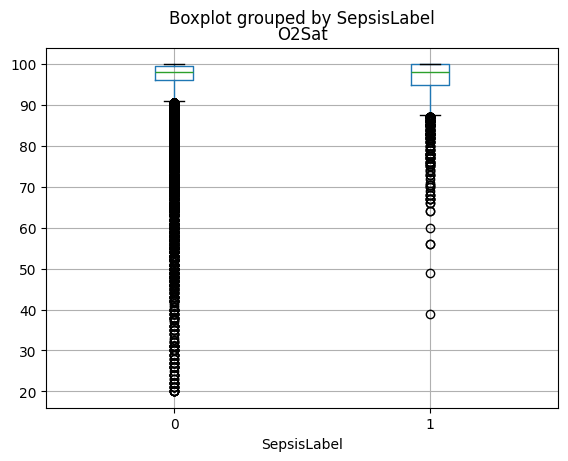

variable: O2Sat 
                 count       mean       std   min   25%   50%    75%    max
SepsisLabel                                                               
0            894200.0  97.197164  2.941639  20.0  96.0  98.0   99.5  100.0
1             16965.0  97.000059  3.286777  39.0  95.0  98.0  100.0  100.0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


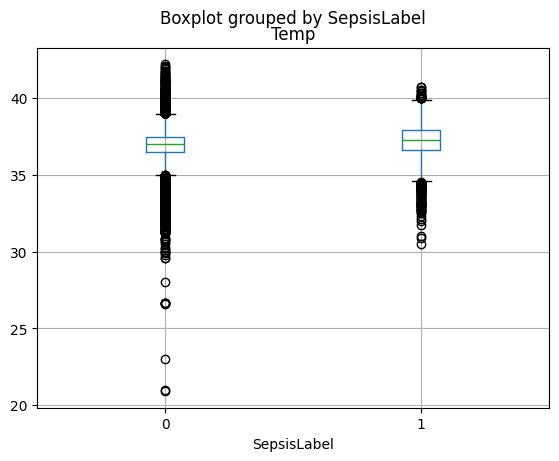

variable: Temp 
                 count      mean       std   min   25%   50%    75%    max
SepsisLabel                                                              
0            345562.0  36.96940  0.760811  20.9  36.5  37.0  37.50  42.22
1              6336.0  37.25312  1.039704  30.5  36.6  37.3  37.94  40.75
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


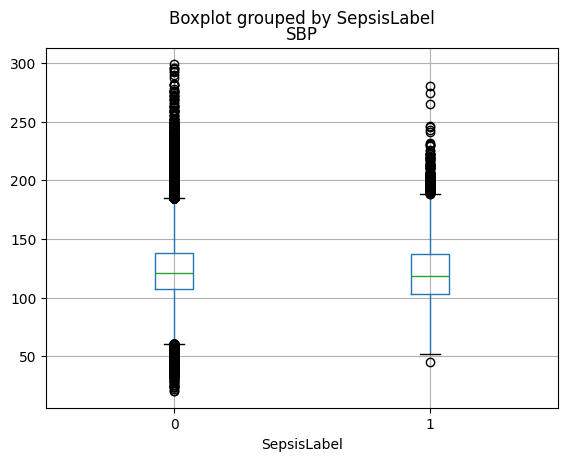

variable: SBP 
                 count        mean        std   min    25%    50%    75%    max
SepsisLabel                                                                   
0            880213.0  123.808266  23.219778  20.0  107.0  121.0  138.0  299.0
1             16097.0  121.451792  25.084487  45.0  103.0  118.0  137.0  280.0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


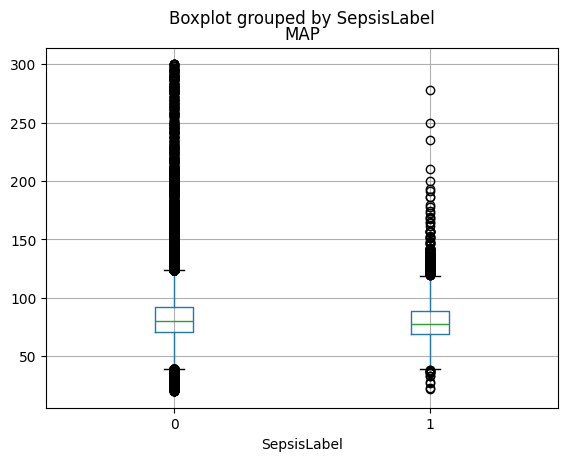

variable: MAP 
                 count       mean        std   min   25%   50%   75%    max
SepsisLabel                                                               
0            900970.0  82.448014  16.336391  20.0  71.0  80.0  92.0  300.0
1             17152.0  80.059612  16.454146  22.0  69.0  78.0  89.0  278.0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


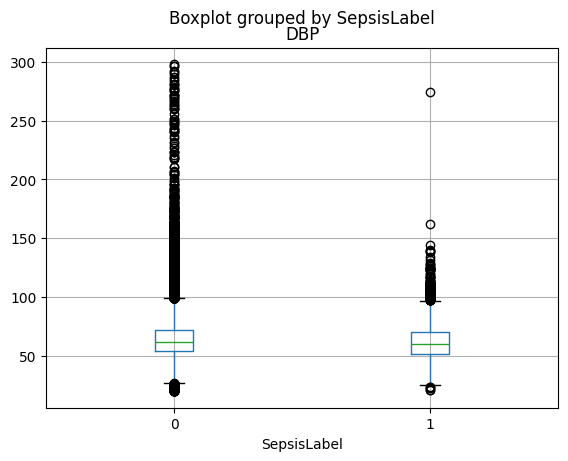

variable: DBP 
                 count       mean        std   min   25%   50%   75%    max
SepsisLabel                                                               
0            707972.0  63.867236  13.958694  20.0  54.0  62.0  72.0  298.0
1             13455.0  61.837434  13.965431  21.0  52.0  60.0  70.0  274.0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


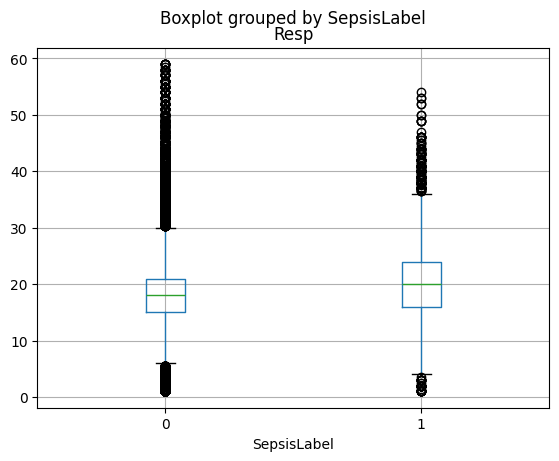

variable: Resp 
                 count       mean       std  min   25%   50%   75%   max
SepsisLabel                                                            
0            870944.0  18.688278  5.022310  1.0  15.0  18.0  21.0  59.0
1             16206.0  20.424901  6.094097  1.0  16.0  20.0  24.0  54.0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


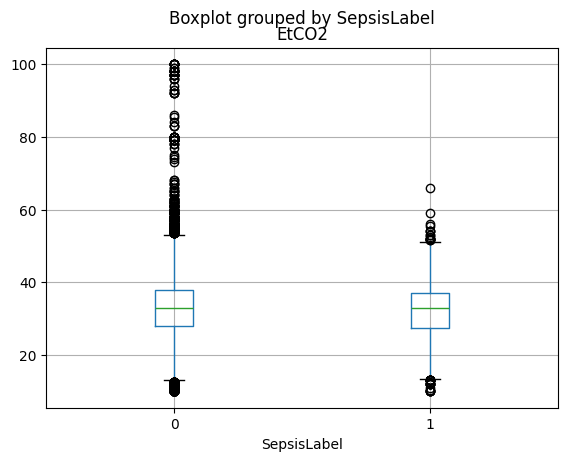

variable: EtCO2 
                count       mean       std   min   25%   50%   75%    max
SepsisLabel                                                             
0            36437.0  32.925433  8.029014  10.0  28.0  33.0  38.0  100.0
1             1967.0  32.429588  7.887255  10.0  27.5  33.0  37.0   66.0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


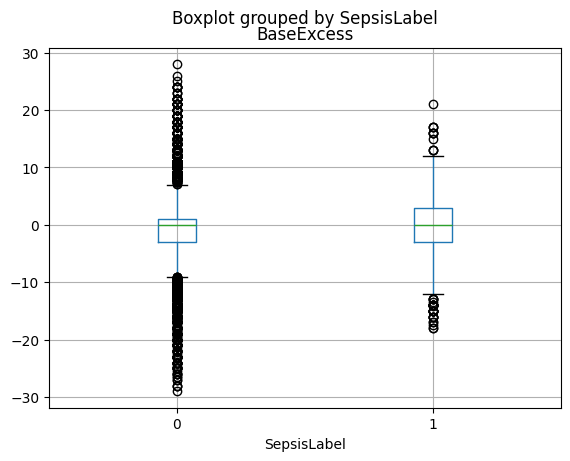

variable: BaseExcess 
                count      mean       std   min  25%  50%  75%   max
SepsisLabel                                                        
0            55149.0 -0.703620  4.218708 -29.0 -3.0  0.0  1.0  28.0
1             1945.0 -0.229717  4.865866 -18.0 -3.0  0.0  3.0  21.0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


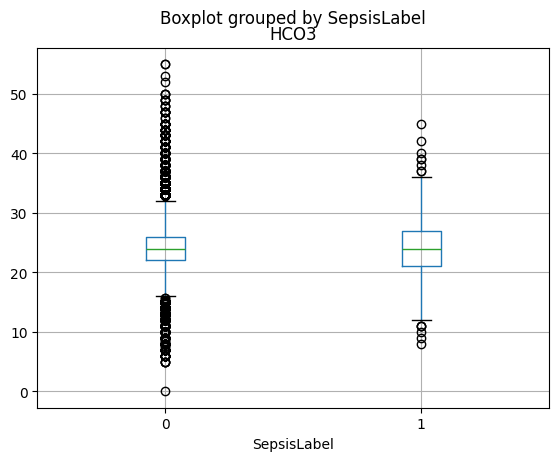

variable: HCO3 
                count       mean       std  min   25%   50%   75%   max
SepsisLabel                                                           
0            42828.0  24.065860  4.311933  0.0  22.0  24.0  26.0  55.0
1             1166.0  23.976158  4.679803  8.0  21.0  24.0  27.0  45.0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


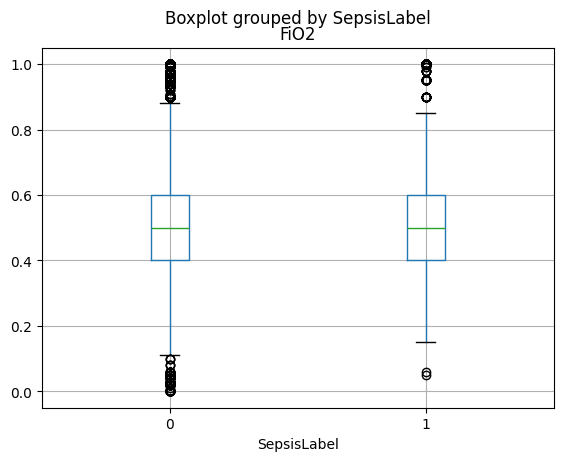

variable: FiO2 
                count      mean       std   min  25%  50%  75%  max
SepsisLabel                                                       
0            84430.0  0.523653  0.189301  0.00  0.4  0.5  0.6  1.0
1             3466.0  0.553140  0.204573  0.05  0.4  0.5  0.6  1.0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


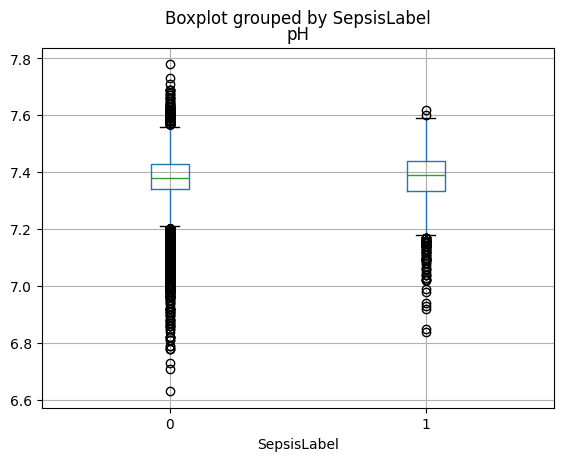

variable: pH 
                count      mean       std   min    25%   50%   75%   max
SepsisLabel                                                            
0            70000.0  7.379119  0.073973  6.63  7.340  7.38  7.43  7.78
1             2535.0  7.378663  0.090650  6.84  7.335  7.39  7.44  7.62
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


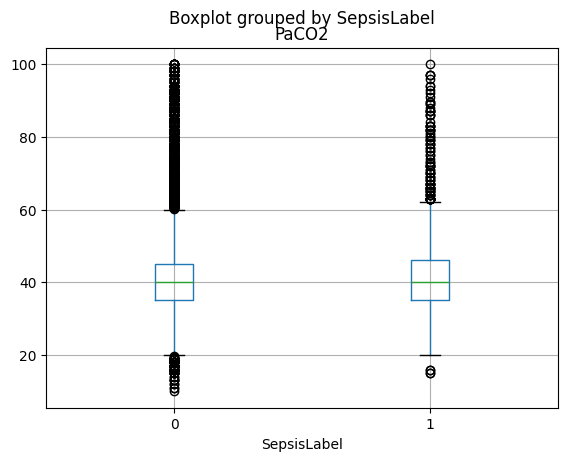

variable: PaCO2 
                count       mean        std   min   25%   50%   75%    max
SepsisLabel                                                              
0            55847.0  40.960488   9.155569  10.0  35.0  40.0  45.0  100.0
1             2155.0  41.562947  10.975690  15.0  35.0  40.0  46.0  100.0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


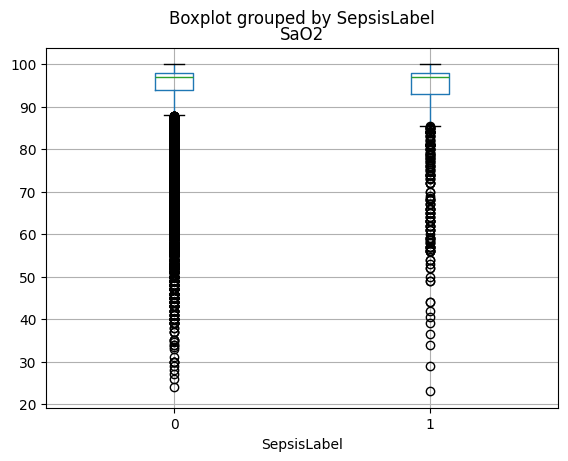

variable: SaO2 
                count       mean        std   min   25%   50%   75%    max
SepsisLabel                                                              
0            34788.0  92.502267  11.070977  24.0  94.0  97.0  98.0  100.0
1             1220.0  92.824016  10.535438  23.0  93.0  96.9  98.0  100.0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


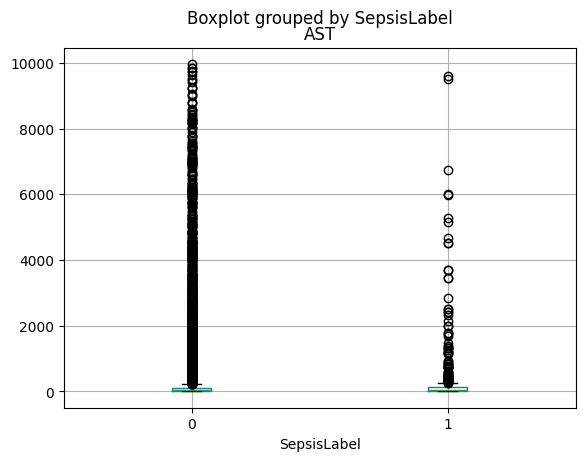

variable: AST 
                count        mean         std  min   25%   50%    75%     max
SepsisLabel                                                                 
0            16307.0  254.878365  839.398904  3.0  22.0  40.0  108.0  9961.0
1              571.0  301.726795  950.317624  5.0  27.0  50.0  122.0  9602.0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


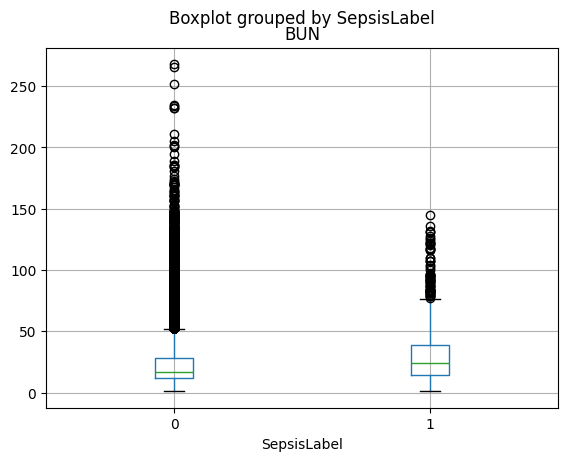

variable: BUN 
                count       mean        std  min   25%   50%   75%    max
SepsisLabel                                                             
0            70199.0  23.774121  19.967707  1.0  12.0  17.0  28.0  268.0
1             1705.0  30.172434  22.144867  1.0  14.0  24.0  39.0  145.0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


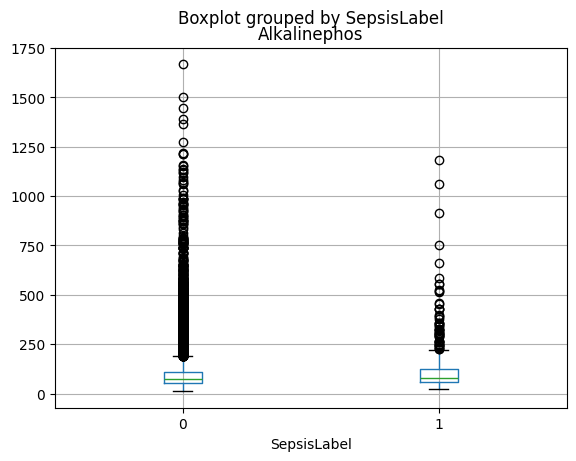

variable: Alkalinephos 
                count        mean         std   min   25%   50%    75%     max
SepsisLabel                                                                  
0            16164.0  100.995812   99.945371  11.0  54.0  74.0  108.0  1669.0
1              569.0  114.683656  116.968761  22.0  57.0  81.0  123.0  1185.0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


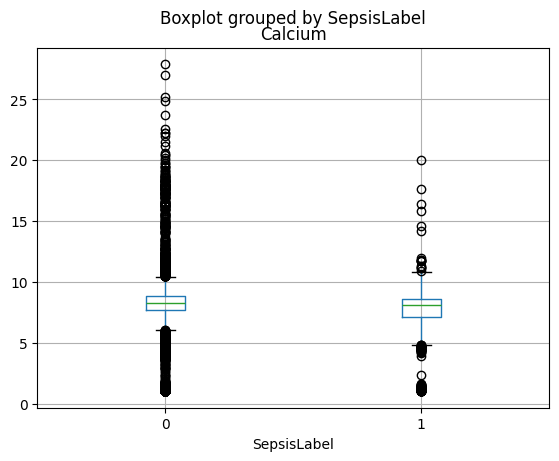

variable: Calcium 
                count      mean       std  min  25%  50%  75%   max
SepsisLabel                                                       
0            59667.0  7.608432  2.386001  1.0  7.7  8.3  8.8  27.9
1             1618.0  6.984061  2.875688  1.0  7.1  8.1  8.6  20.0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


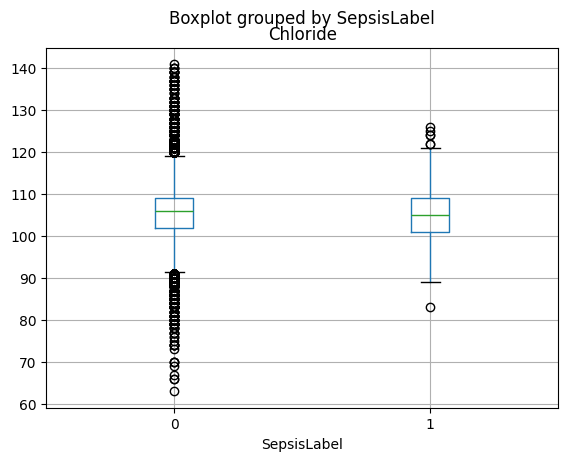

variable: Chloride 
                count        mean       std   min    25%    50%    75%    max
SepsisLabel                                                                 
0            46248.0  105.856899  5.911672  63.0  102.0  106.0  109.0  141.0
1             1292.0  105.480263  6.093307  83.0  101.0  105.0  109.0  126.0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


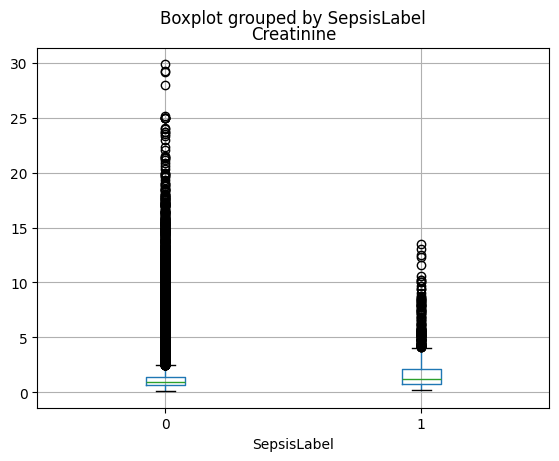

variable: Creatinine 
                count      mean       std  min   25%   50%   75%    max
SepsisLabel                                                           
0            62290.0  1.513765  1.816020  0.1  0.70  0.93  1.43  29.86
1             1460.0  1.789432  1.737739  0.2  0.78  1.20  2.10  13.51
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


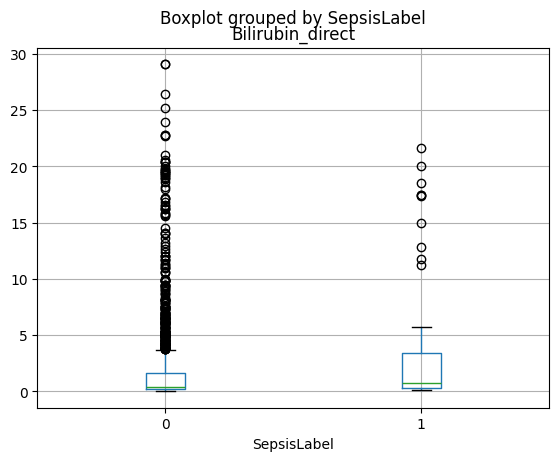

variable: Bilirubin_direct 
               count      mean       std   min    25%   50%  75%   max
SepsisLabel                                                          
0            2002.0  1.721030  3.417094  0.01  0.200  0.40  1.6  29.1
1              79.0  3.213291  5.371925  0.10  0.295  0.75  3.4  21.6
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


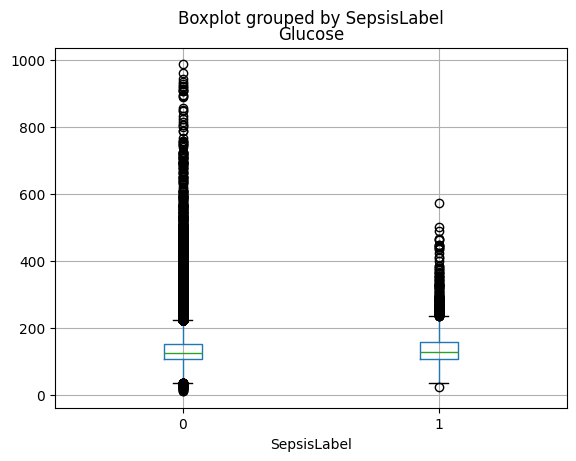

variable: Glucose 
                 count        mean        std   min    25%    50%    75%    max
SepsisLabel                                                                   
0            174563.0  137.043735  51.963808  10.0  106.0  126.0  153.0  988.0
1              3434.0  139.511357  53.279759  23.5  107.0  128.0  158.0  574.0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


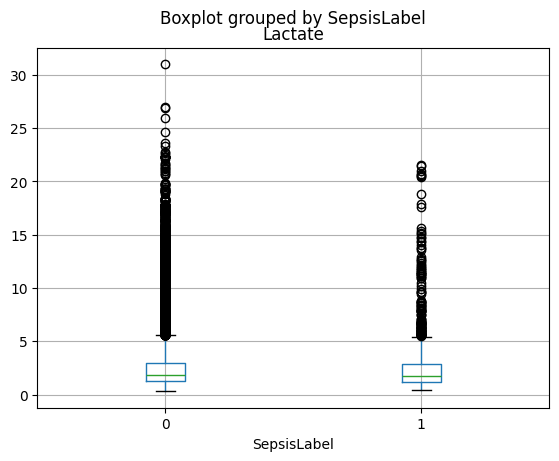

variable: Lactate 
                count      mean       std  min   25%  50%  75%    max
SepsisLabel                                                         
0            26545.0  2.623269  2.475677  0.3  1.27  1.8  3.0  31.00
1             1276.0  2.655807  2.806127  0.4  1.20  1.7  2.9  21.52
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


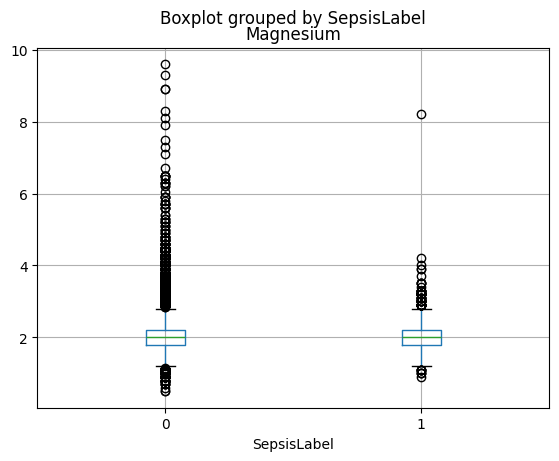

variable: Magnesium 
                count      mean       std  min  25%  50%  75%  max
SepsisLabel                                                      
0            64607.0  2.050456  0.396974  0.5  1.8  2.0  2.2  9.6
1             1609.0  2.060162  0.410236  0.9  1.8  2.0  2.2  8.2
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


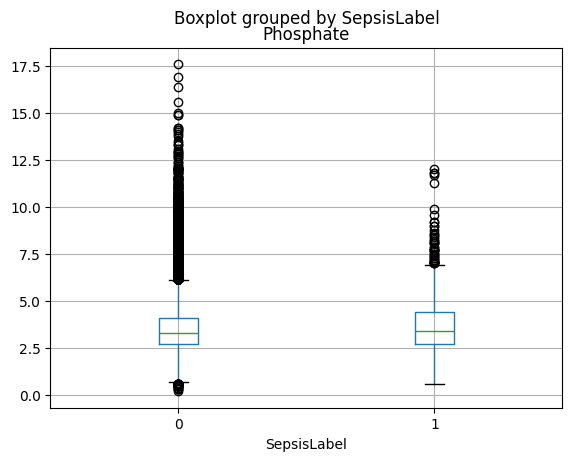

variable: Phosphate 
                count      mean       std  min  25%  50%  75%   max
SepsisLabel                                                       
0            40940.0  3.547594  1.417328  0.2  2.7  3.3  4.1  17.6
1             1106.0  3.699277  1.560019  0.6  2.7  3.4  4.4  12.0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


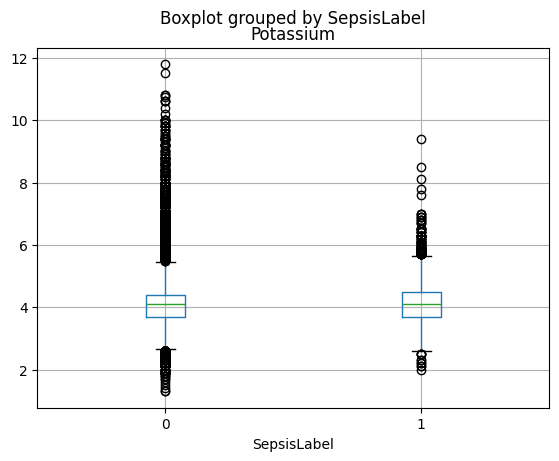

variable: Potassium 
                count      mean       std  min  25%  50%  75%   max
SepsisLabel                                                       
0            94507.0  4.133453  0.640183  1.3  3.7  4.1  4.4  11.8
1             2455.0  4.152224  0.706902  2.0  3.7  4.1  4.5   9.4
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


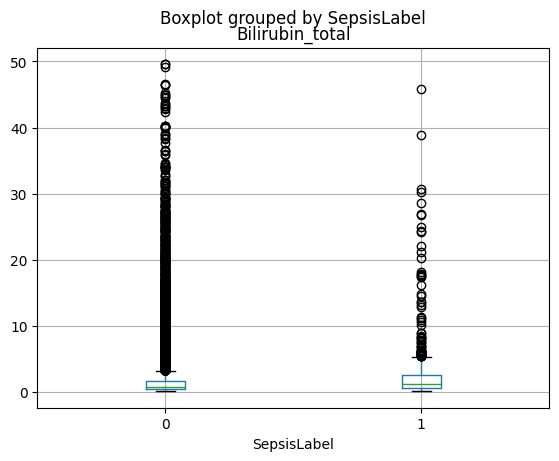

variable: Bilirubin_total 
                count      mean       std  min  25%  50%  75%   max
SepsisLabel                                                       
0            14992.0  1.990939  4.013241  0.1  0.5  0.8  1.6  49.6
1              506.0  2.859585  5.130967  0.1  0.6  1.2  2.5  45.9
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


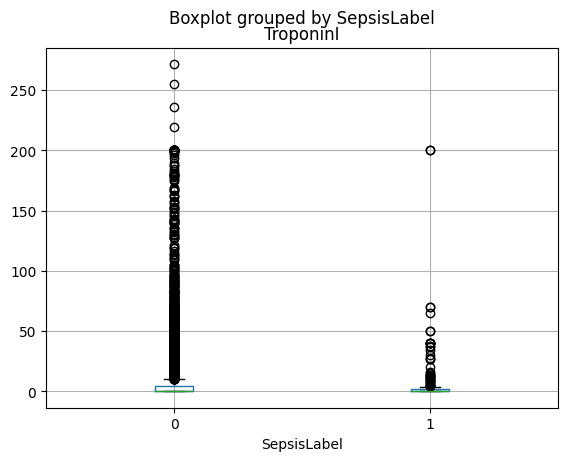

variable: TroponinI 
               count      mean        std   min     25%    50%     75%    max
SepsisLabel                                                                 
0            9879.0  8.323216  23.555800  0.01  0.0400  0.290  4.1500  271.6
1             208.0  6.870144  22.747367  0.01  0.0575  0.255  1.6525  200.0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


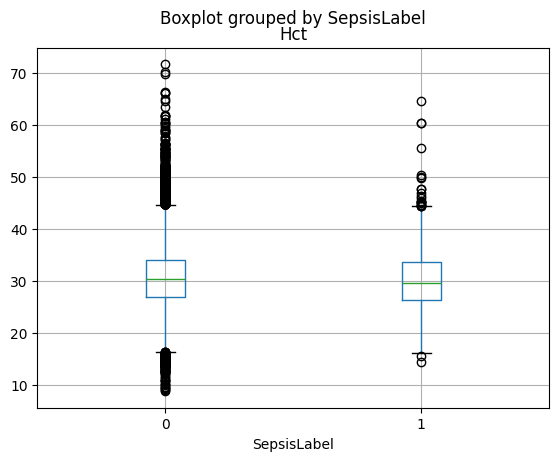

variable: Hct 
                count       mean       std   min   25%    50%   75%   max
SepsisLabel                                                             
0            90681.0  30.799422  5.488013   8.8  27.0  30.30  34.1  71.7
1             2134.0  30.298725  5.455387  14.4  26.4  29.65  33.6  64.6
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


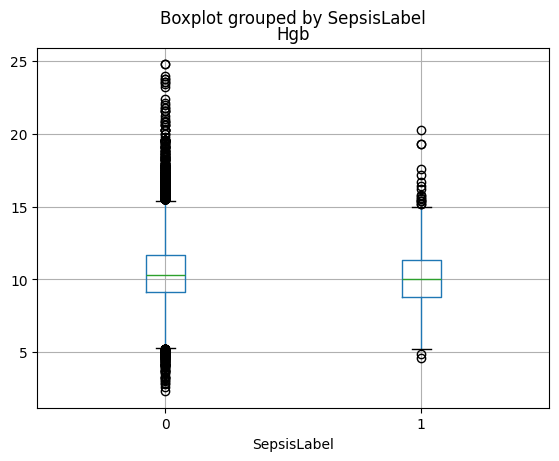

variable: Hgb 
                count       mean       std  min  25%   50%    75%   max
SepsisLabel                                                           
0            75430.0  10.430822  1.965856  2.3  9.1  10.3  11.65  24.8
1             1824.0  10.187818  1.869308  4.6  8.8  10.0  11.30  20.3
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


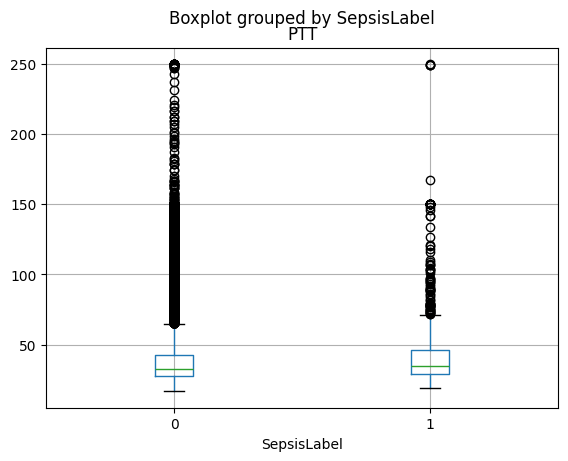

variable: PTT 
                count       mean        std   min   25%   50%   75%    max
SepsisLabel                                                              
0            30119.0  41.170099  26.261270  16.6  27.7  32.3  42.6  250.0
1              825.0  43.981758  29.126182  18.7  29.1  34.4  45.9  249.9
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


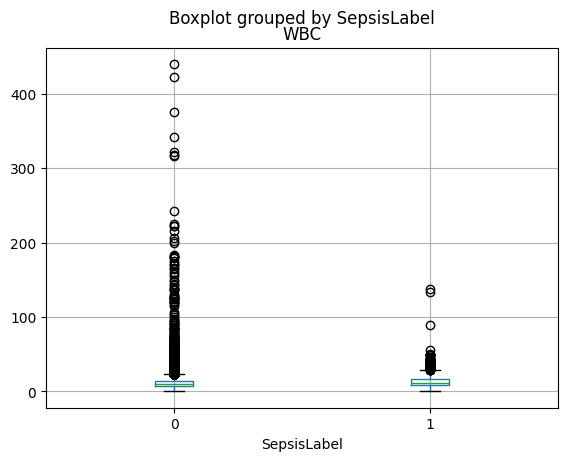

variable: WBC 
                count       mean       std  min  25%   50%    75%    max
SepsisLabel                                                            
0            65511.0  11.454894  7.993011  0.1  7.6  10.3  13.70  440.0
1             1571.0  13.302024  8.682300  0.1  8.4  11.8  16.35  137.8
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


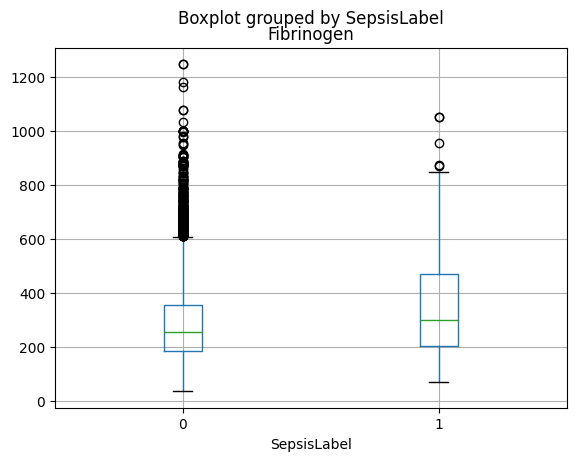

variable: Fibrinogen 
               count        mean         std   min     25%    50%    75%  \
SepsisLabel                                                               
0            6571.0  289.090626  151.130140  34.0  185.00  253.0  354.0   
1             218.0  348.591743  190.466789  70.0  201.75  297.0  467.5   

                max  
SepsisLabel          
0            1246.0  
1            1051.0  
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


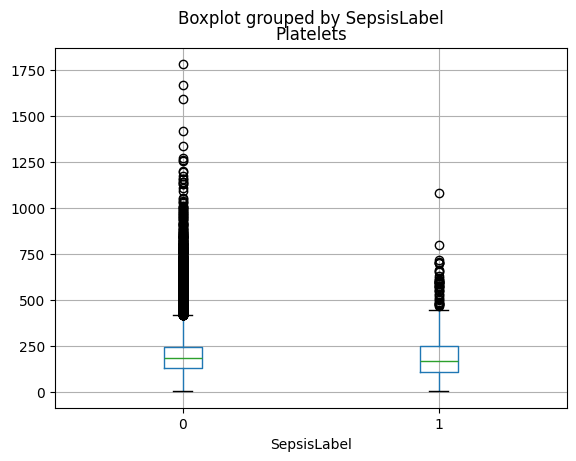

variable: Platelets 
                count        mean         std  min    25%    50%    75%     max
SepsisLabel                                                                   
0            60579.0  197.161388  103.716938  1.0  128.0  182.0  244.0  1783.0
1             1413.0  190.057679  118.551708  4.0  108.0  166.0  250.0  1081.0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


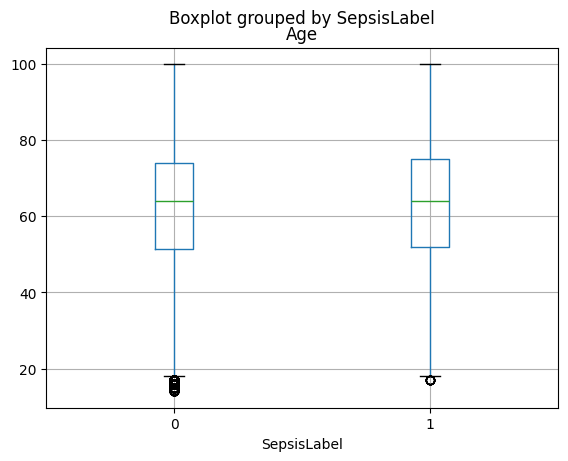

variable: Age 
                  count       mean        std   min    25%   50%   75%    max
SepsisLabel                                                                 
0            1029645.0  61.953407  16.415566  14.0  51.38  64.0  74.0  100.0
1              18930.0  62.411320  16.355243  17.0  52.00  64.0  75.0  100.0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


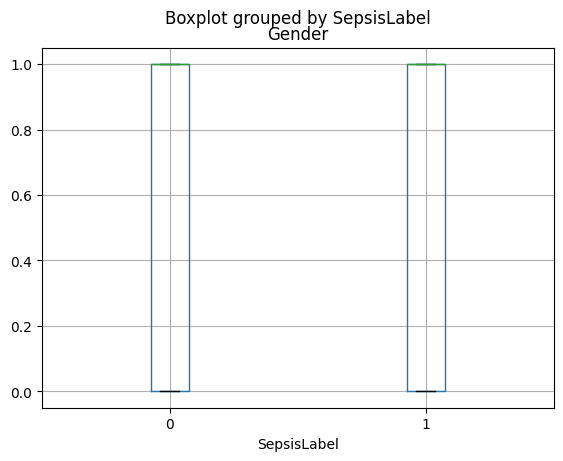

variable: Gender 
                  count      mean       std  min  25%  50%  75%  max
SepsisLabel                                                        
0            1029645.0  0.559997  0.496388  0.0  0.0  1.0  1.0  1.0
1              18930.0  0.584152  0.492881  0.0  0.0  1.0  1.0  1.0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


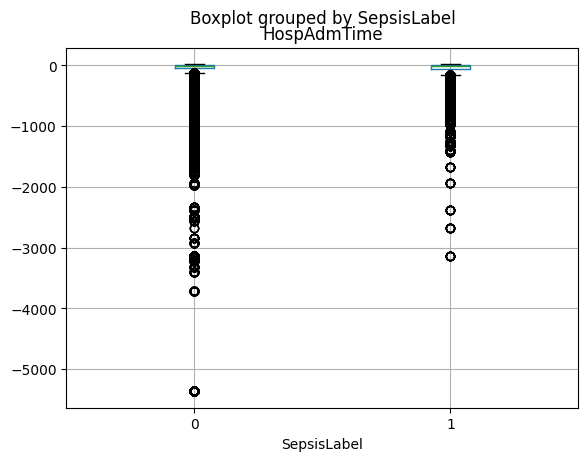

variable: HospAdmTime 
                  count       mean         std      min    25%    50%   75%  \
SepsisLabel                                                                  
0            1029637.0 -56.395219  171.173344 -5366.86 -46.67 -6.080 -0.04   
1              18930.0 -77.768183  203.587806 -3141.55 -63.61 -2.935 -0.02   

               max  
SepsisLabel         
0            22.04  
1            16.02  
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


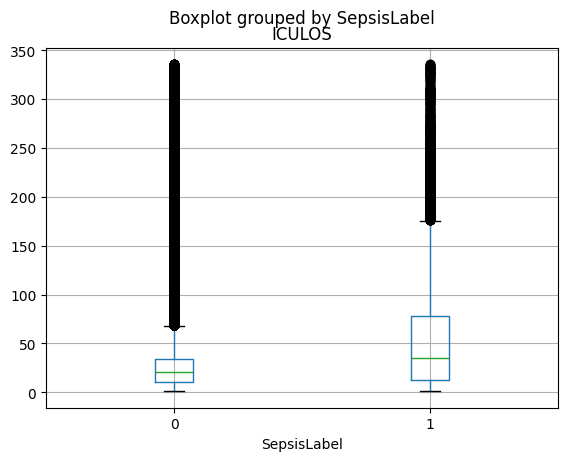

variable: ICULOS 
                  count       mean        std  min   25%   50%   75%    max
SepsisLabel                                                               
0            1029645.0  26.502756  28.017569  1.0  11.0  21.0  34.0  336.0
1              18930.0  55.592816  58.935021  1.0  13.0  35.0  78.0  336.0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


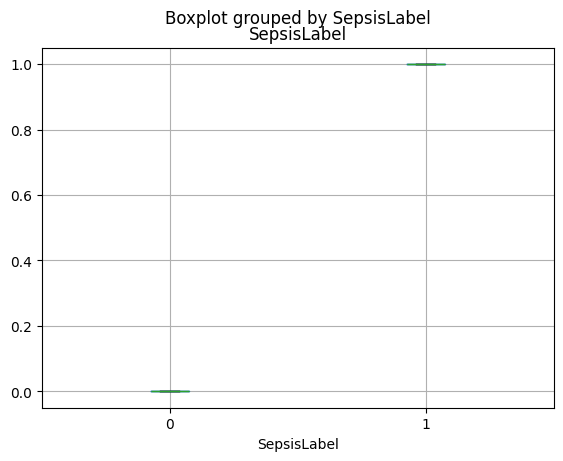

variable: SepsisLabel 
                  count  mean  std  min  25%  50%  75%  max
SepsisLabel                                               
0            1029645.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
1              18930.0   1.0  0.0  1.0  1.0  1.0  1.0  1.0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


In [297]:

for var in df.columns:
  if var!= 'Patient_id':
    df.boxplot(column=[var], by='SepsisLabel')
    plt.show()
    print('variable:', var,'\n', df.groupby('SepsisLabel')[var].describe())
    print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')



out of curiosity, i also wanted to visually inspect whether sepsis label differed across gender and age groups. I categorised age groups into 3 categories. Overall, i do not see much difference in sepsis labels between the 2 genders. However, i do notice a pattern across the categorical age feature. Therefore, i decide to add this variable to our feature list when training the ML model. 

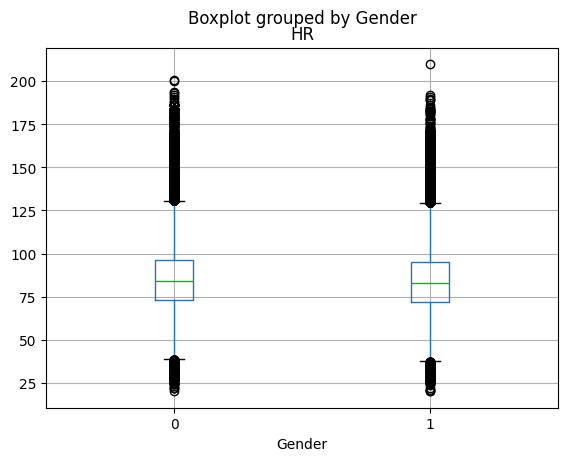

variable: HR 
            count       mean        std   min   25%   50%   75%    max
Gender                                                               
0       413838.0  85.262279  17.521691  20.0  73.0  84.0  96.0  201.0
1       531192.0  84.034266  17.137116  20.0  72.0  83.0  95.0  210.0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


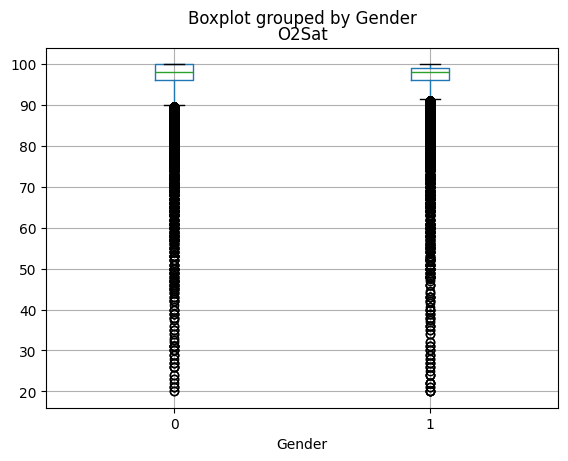

variable: O2Sat 
            count       mean       std   min   25%   50%    75%    max
Gender                                                               
0       399787.0  97.295388  3.025232  20.0  96.0  98.0  100.0  100.0
1       511378.0  97.113836  2.884685  20.0  96.0  98.0   99.0  100.0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


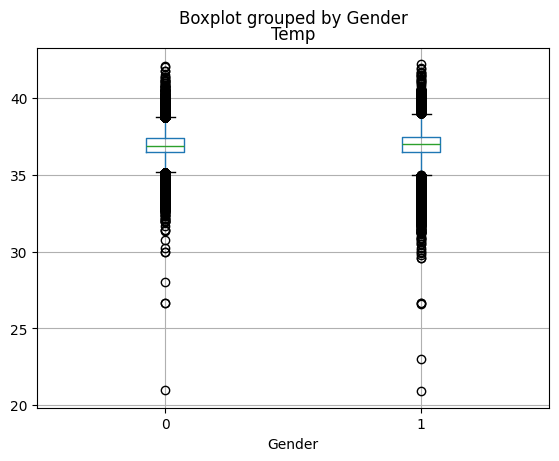

variable: Temp 
            count       mean       std   min   25%   50%   75%    max
Gender                                                              
0       146342.0  36.927006  0.742258  21.0  36.5  36.9  37.4  42.10
1       205556.0  37.008326  0.783486  20.9  36.5  37.0  37.5  42.22
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


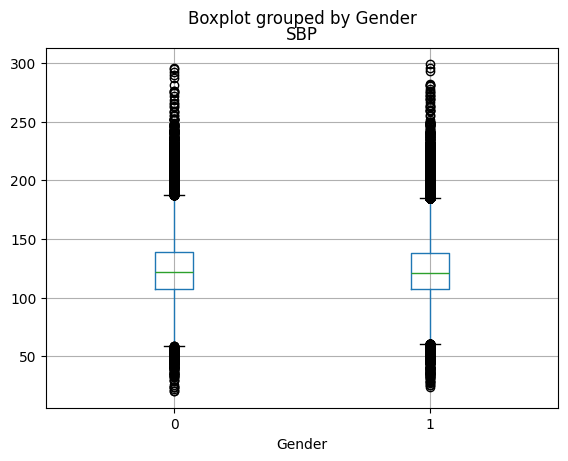

variable: SBP 
            count        mean        std   min    25%    50%    75%    max
Gender                                                                   
0       392132.0  124.099524  23.601854  20.0  107.0  122.0  139.0  296.0
1       504178.0  123.506501  22.981301  24.0  107.0  121.0  138.0  299.0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


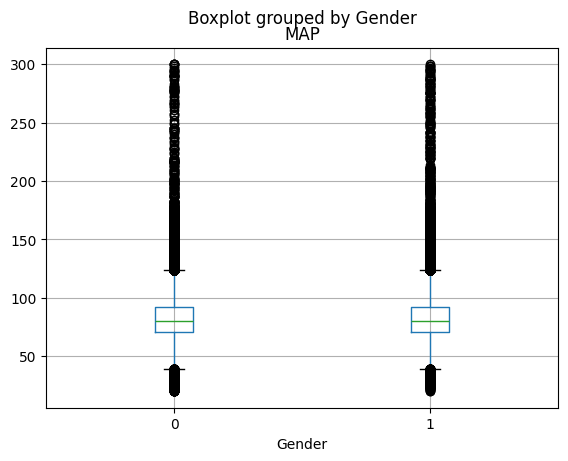

variable: MAP 
            count       mean        std   min   25%    50%   75%    max
Gender                                                                
0       400954.0  82.340008  16.607261  20.0  71.0  80.33  92.0  300.0
1       517168.0  82.452539  16.132811  20.0  71.0  80.00  92.0  300.0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


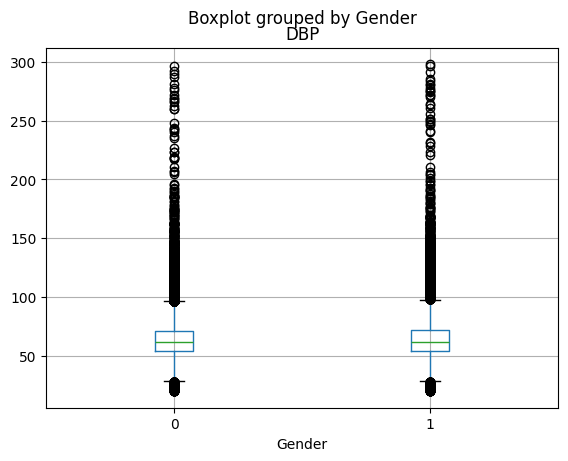

variable: DBP 
            count       mean        std   min   25%   50%   75%    max
Gender                                                               
0       312895.0  63.352715  14.048144  20.0  54.0  62.0  71.0  296.0
1       408532.0  64.194456  13.883748  20.0  54.5  62.0  72.0  298.0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


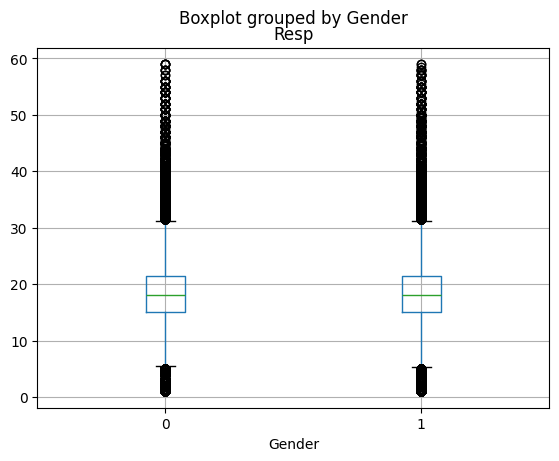

variable: Resp 
            count       mean       std  min   25%   50%   75%   max
Gender                                                            
0       388264.0  18.719984  5.063121  1.0  15.0  18.0  21.5  59.0
1       498886.0  18.720017  5.038497  1.0  15.0  18.0  21.5  59.0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


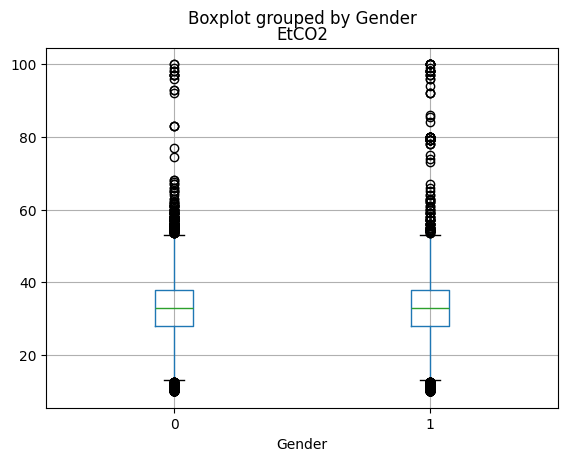

variable: EtCO2 
           count       mean       std   min   25%   50%   75%    max
Gender                                                             
0       17591.0  32.982491  7.943707  10.0  28.0  33.0  38.0  100.0
1       20813.0  32.830346  8.087955  10.0  28.0  33.0  38.0  100.0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


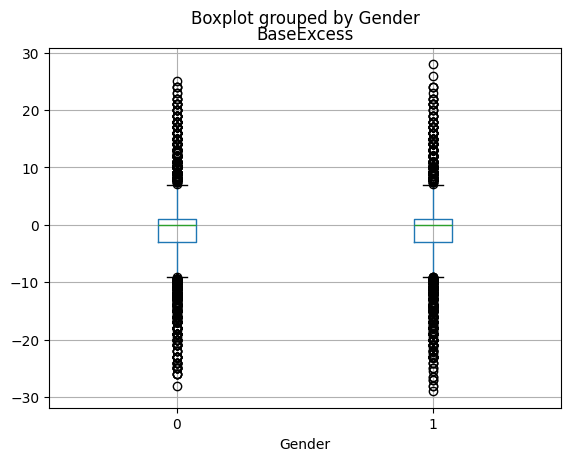

variable: BaseExcess 
           count      mean       std   min  25%  50%  75%   max
Gender                                                        
0       22010.0 -0.806712  4.586361 -28.0 -3.0  0.0  1.0  25.0
1       35084.0 -0.612673  4.011228 -29.0 -3.0  0.0  1.0  28.0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


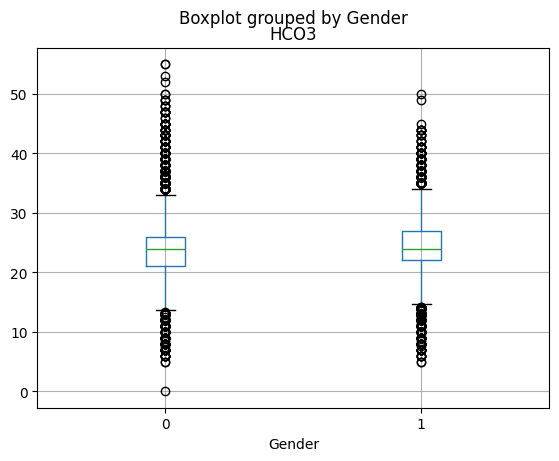

variable: HCO3 
           count       mean       std  min   25%   50%   75%   max
Gender                                                           
0       18426.0  23.876948  4.666055  0.0  21.0  24.0  26.0  55.0
1       25568.0  24.197911  4.050866  5.0  22.0  24.0  27.0  50.0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


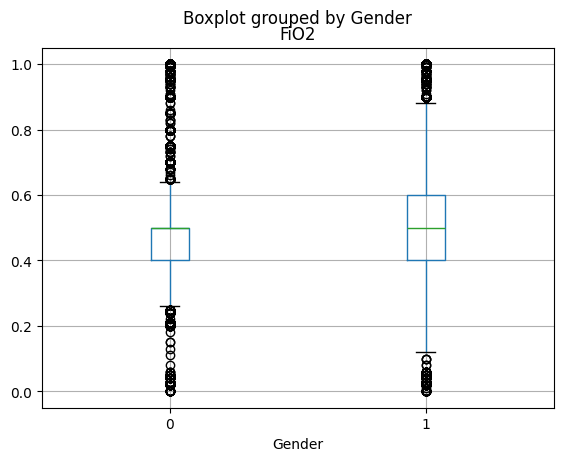

variable: FiO2 
           count      mean       std  min  25%  50%  75%  max
Gender                                                      
0       35808.0  0.517088  0.189800  0.0  0.4  0.5  0.5  1.0
1       52088.0  0.530127  0.189976  0.0  0.4  0.5  0.6  1.0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


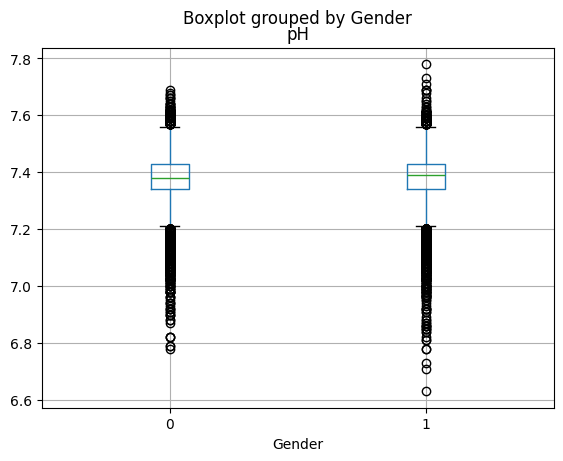

variable: pH 
           count      mean       std   min   25%   50%   75%   max
Gender                                                           
0       28152.0  7.377586  0.077602  6.78  7.34  7.38  7.43  7.69
1       44383.0  7.380065  0.072647  6.63  7.34  7.39  7.43  7.78
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


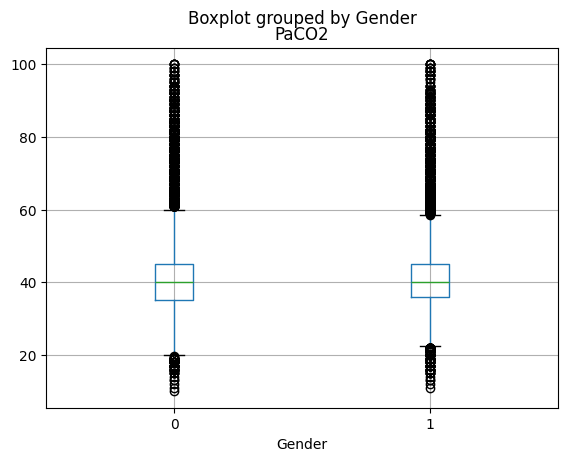

variable: PaCO2 
           count       mean        std   min   25%   50%   75%    max
Gender                                                              
0       22956.0  41.058453  10.183854  10.0  35.0  40.0  45.0  100.0
1       35046.0  40.933363   8.547862  11.0  36.0  40.0  45.0  100.0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


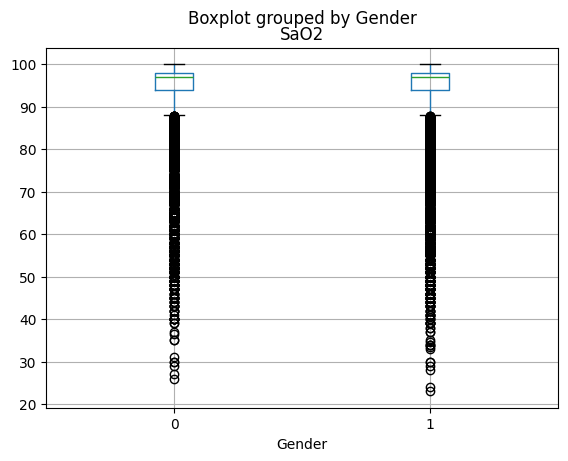

variable: SaO2 
           count       mean        std   min   25%   50%   75%    max
Gender                                                              
0       14125.0  92.295051  11.343839  26.0  94.0  97.0  98.0  100.0
1       21883.0  92.653957  10.859522  23.0  94.0  97.0  98.0  100.0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


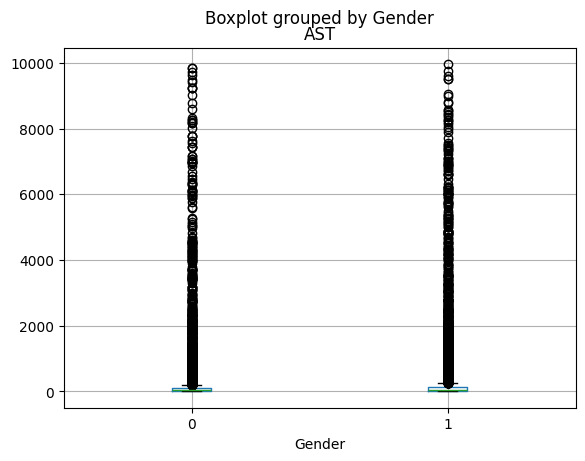

variable: AST 
          count        mean         std  min   25%   50%    75%     max
Gender                                                                
0       7294.0  246.543529  846.519902  3.0  21.0  36.0   95.0  9840.0
1       9584.0  264.012834  840.985164  5.0  24.0  44.0  121.0  9961.0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


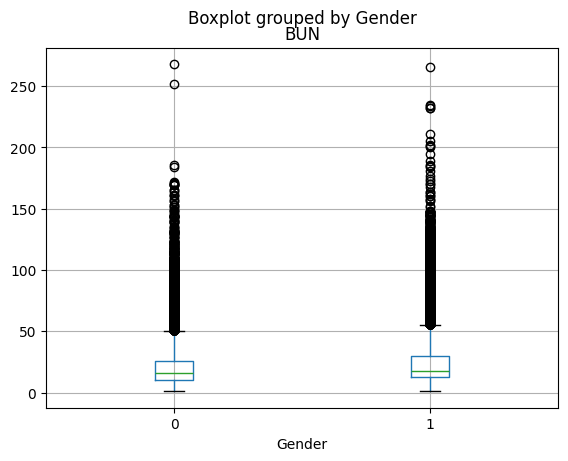

variable: BUN 
           count       mean        std  min   25%   50%   75%    max
Gender                                                             
0       31030.0  21.906043  18.879774  1.0  10.0  16.0  26.0  268.0
1       40874.0  25.459192  20.756569  1.0  13.0  18.0  30.0  266.0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


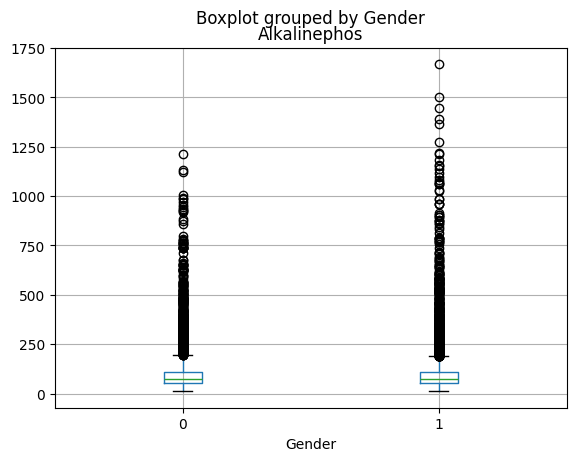

variable: Alkalinephos 
          count        mean         std   min   25%   50%    75%     max
Gender                                                                 
0       7258.0  102.688964   95.788270  11.0  55.0  76.0  111.0  1214.0
1       9475.0  100.520824  104.127654  11.0  53.0  73.0  107.0  1669.0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


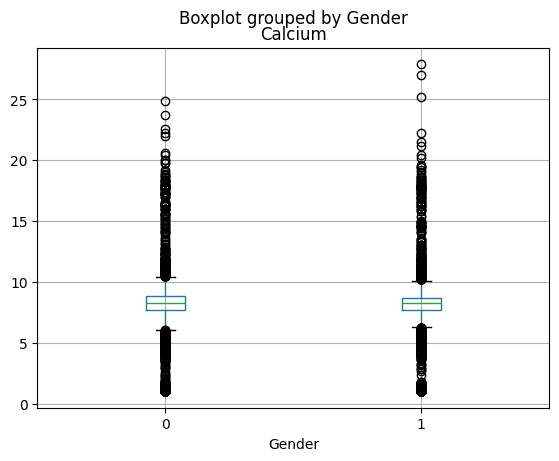

variable: Calcium 
           count      mean       std  min  25%  50%  75%   max
Gender                                                       
0       27090.0  7.679947  2.320114  1.0  7.7  8.3  8.8  24.9
1       34195.0  7.522234  2.463220  1.0  7.7  8.3  8.7  27.9
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


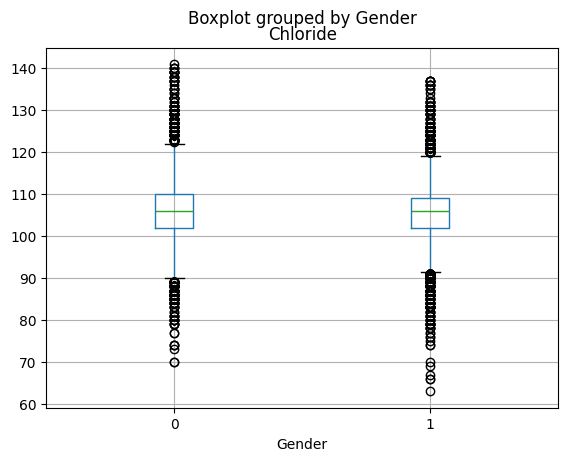

variable: Chloride 
           count        mean       std   min    25%    50%    75%    max
Gender                                                                 
0       19890.0  106.010960  6.303868  70.0  102.0  106.0  110.0  141.0
1       27650.0  105.728475  5.619294  63.0  102.0  106.0  109.0  137.0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


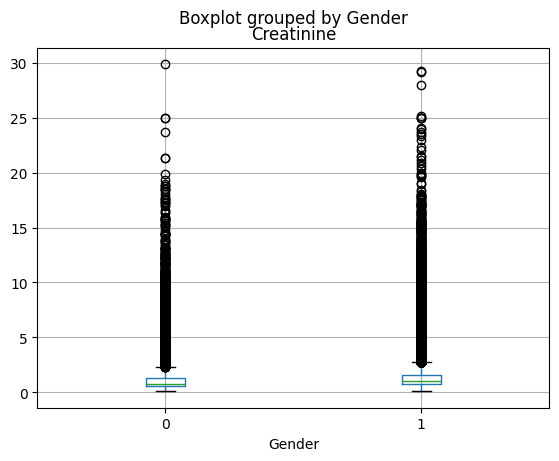

variable: Creatinine 
           count      mean       std  min  25%   50%   75%    max
Gender                                                          
0       27761.0  1.357735  1.666541  0.1  0.6  0.80  1.30  29.86
1       35989.0  1.645306  1.911857  0.1  0.8  1.01  1.58  29.20
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


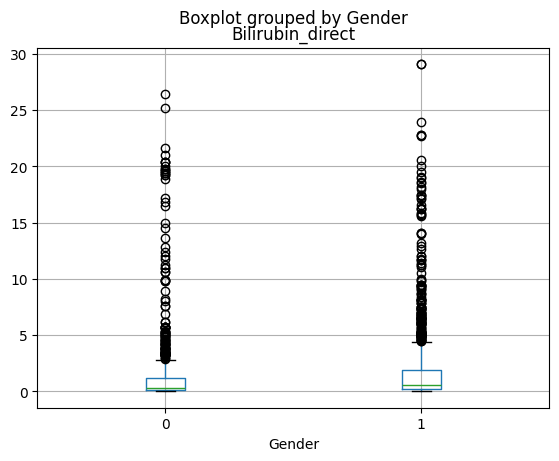

variable: Bilirubin_direct 
          count      mean       std   min  25%  50%  75%   max
Gender                                                       
0        847.0  1.559336  3.523198  0.01  0.1  0.3  1.2  26.4
1       1234.0  1.927549  3.512860  0.01  0.2  0.6  1.9  29.1
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


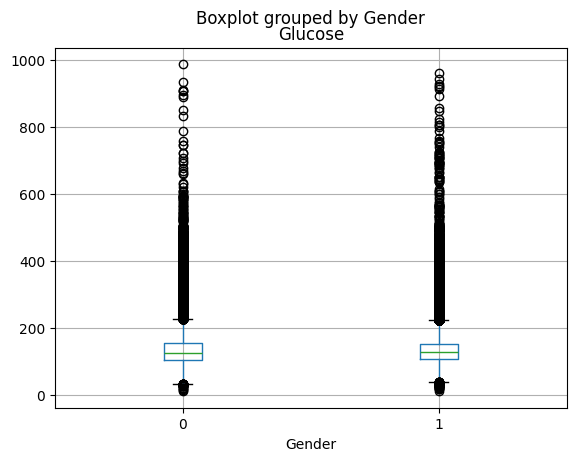

variable: Glucose 
            count        mean        std   min    25%    50%    75%    max
Gender                                                                   
0        75436.0  136.953282  53.487232  11.0  105.0  126.0  153.5  988.0
1       102561.0  137.192888  50.861477  10.0  107.0  127.0  153.0  960.0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


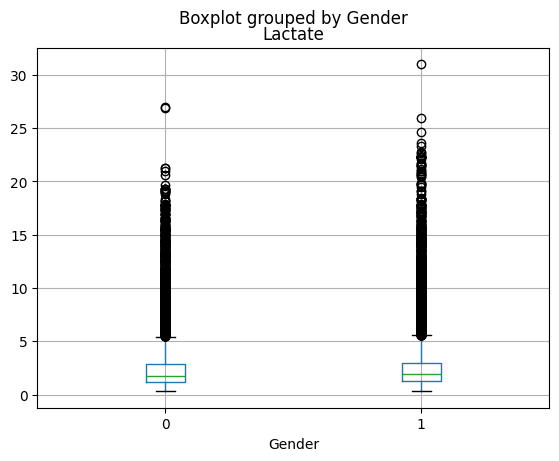

variable: Lactate 
           count      mean       std  min  25%   50%  75%   max
Gender                                                        
0       11216.0  2.589951  2.541464  0.3  1.2  1.72  2.9  27.0
1       16605.0  2.648274  2.457392  0.3  1.3  1.89  3.0  31.0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


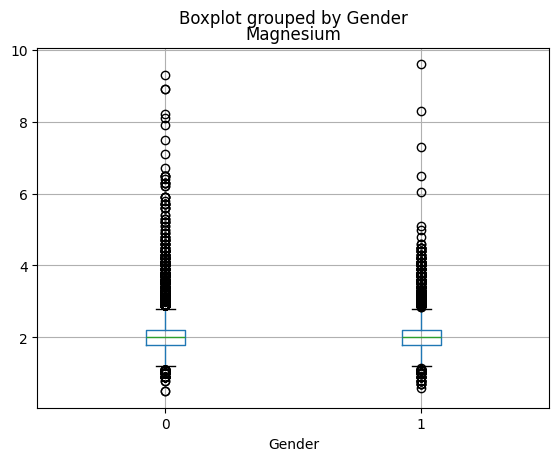

variable: Magnesium 
           count      mean       std  min  25%  50%  75%  max
Gender                                                      
0       28718.0  2.047252  0.437818  0.5  1.8  2.0  2.2  9.3
1       37498.0  2.053325  0.363212  0.6  1.8  2.0  2.2  9.6
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


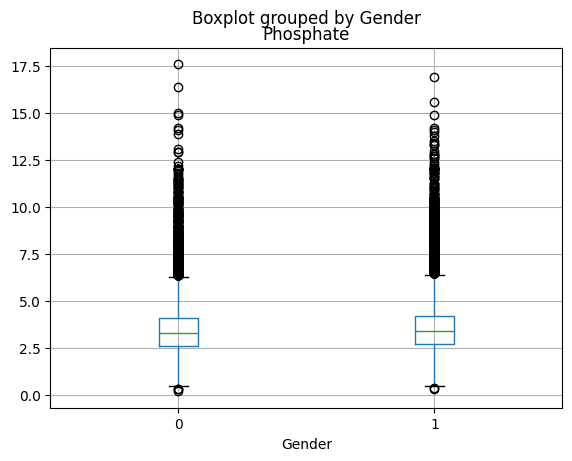

variable: Phosphate 
           count      mean       std  min  25%  50%  75%   max
Gender                                                       
0       18973.0  3.494073  1.389686  0.2  2.6  3.3  4.1  17.6
1       23073.0  3.598875  1.445367  0.3  2.7  3.4  4.2  16.9
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


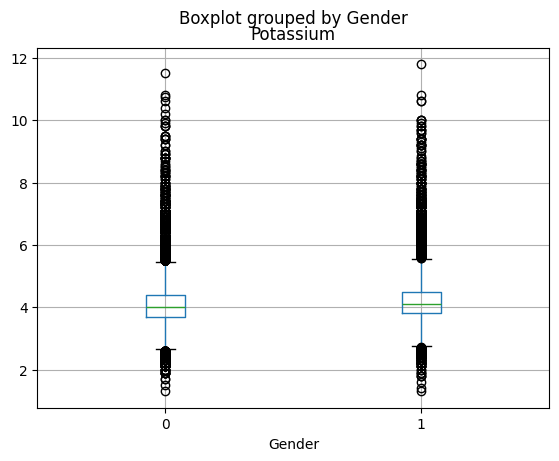

variable: Potassium 
           count      mean     std  min  25%  50%  75%   max
Gender                                                     
0       40906.0  4.069692  0.6479  1.3  3.7  4.0  4.4  11.5
1       56056.0  4.180804  0.6335  1.3  3.8  4.1  4.5  11.8
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


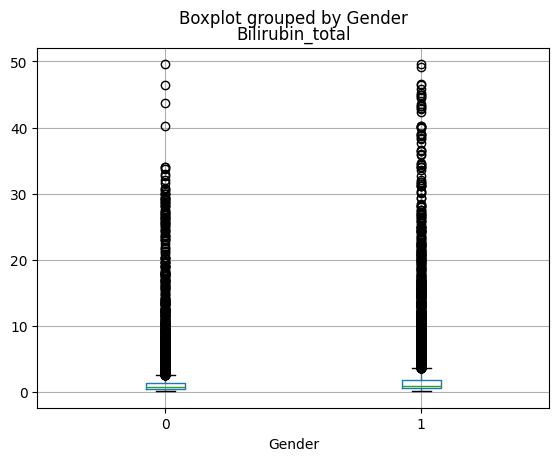

variable: Bilirubin_total 
          count      mean       std  min  25%  50%  75%   max
Gender                                                      
0       6757.0  1.754499  3.639249  0.1  0.5  0.7  1.3  49.6
1       8741.0  2.223996  4.342246  0.1  0.6  0.9  1.8  49.6
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


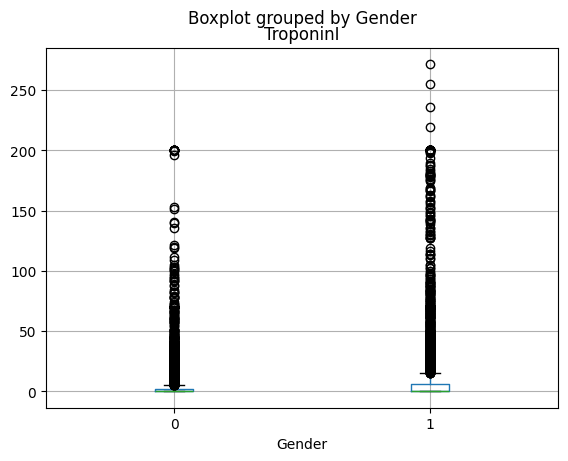

variable: TroponinI 
          count       mean        std   min   25%   50%     75%    max
Gender                                                               
0       4541.0   5.671506  17.202922  0.01  0.03  0.18  2.1600  200.0
1       5546.0  10.439909  27.483132  0.01  0.05  0.43  6.1975  271.6
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


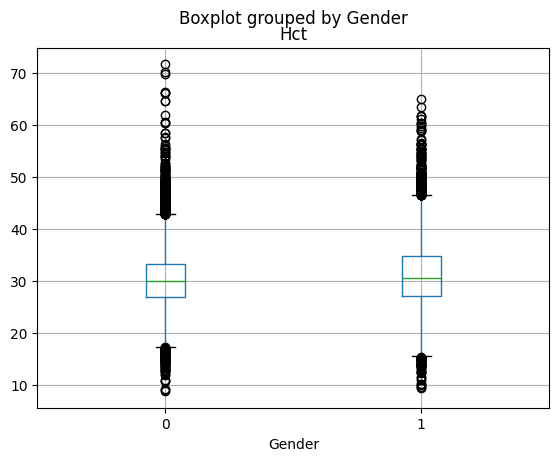

variable: Hct 
           count       mean       std  min   25%   50%   75%   max
Gender                                                           
0       38983.0  30.242205  5.046073  8.8  26.9  30.0  33.3  71.7
1       53832.0  31.183088  5.754414  9.4  27.1  30.5  34.9  65.0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


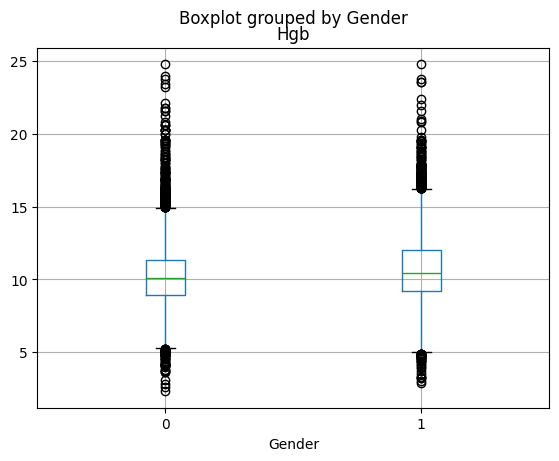

variable: Hgb 
           count       mean       std  min  25%    50%   75%   max
Gender                                                           
0       32905.0  10.140414  1.779866  2.3  8.9  10.10  11.3  24.8
1       44349.0  10.636298  2.064919  2.9  9.2  10.45  12.0  24.8
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


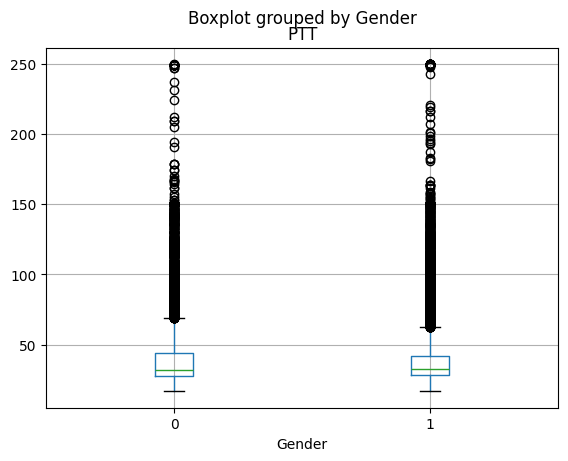

variable: PTT 
           count       mean        std   min   25%   50%   75%    max
Gender                                                              
0       12758.0  42.067570  28.238627  16.6  27.2  32.1  43.9  250.0
1       18186.0  40.668047  24.915596  17.1  28.1  32.5  41.9  250.0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


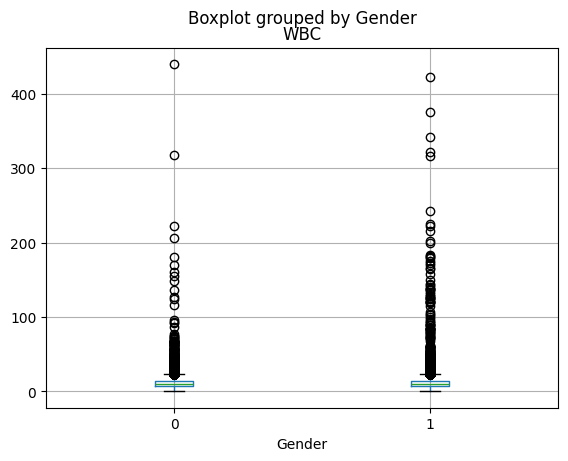

variable: WBC 
           count       mean       std  min  25%   50%   75%    max
Gender                                                           
0       28759.0  11.553978  7.365926  0.1  7.7  10.4  13.9  440.0
1       38323.0  11.456258  8.468725  0.1  7.6  10.3  13.7  422.9
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


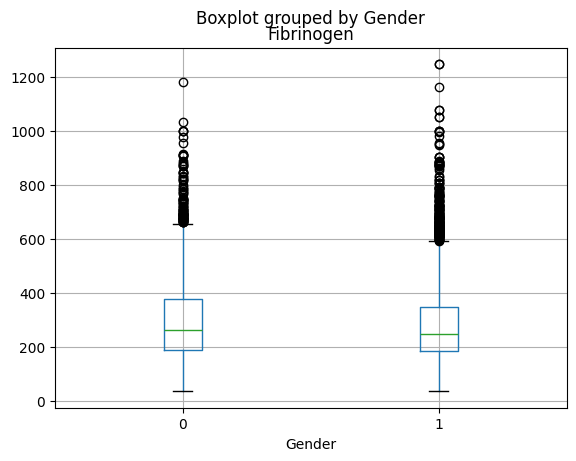

variable: Fibrinogen 
          count        mean         std   min    25%    50%    75%     max
Gender                                                                   
0       2576.0  299.895419  157.673357  35.0  188.0  263.0  375.0  1179.0
1       4213.0  285.562996  149.655346  34.0  184.0  248.0  347.0  1246.0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


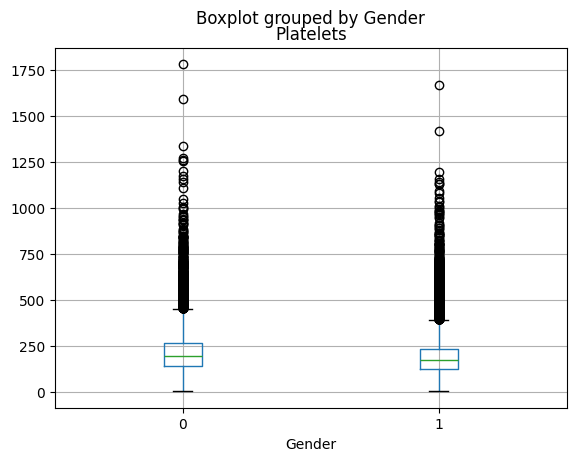

variable: Platelets 
           count        mean         std  min    25%    50%    75%     max
Gender                                                                   
0       26607.0  210.359575  109.494016  1.0  137.0  195.0  263.0  1783.0
1       35385.0  186.953624   98.637937  5.0  122.0  172.0  230.0  1667.0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


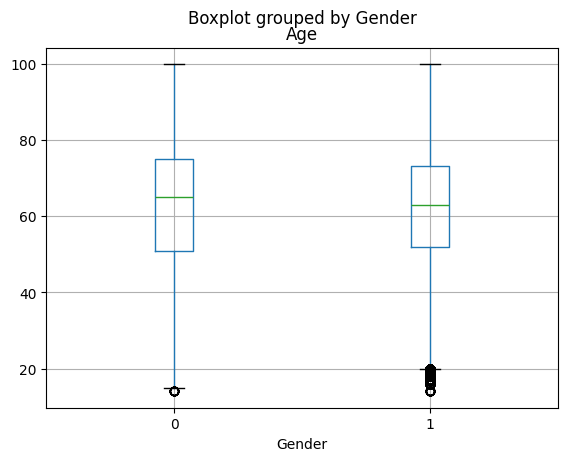

variable: Age 
            count       mean        std   min    25%    50%    75%    max
Gender                                                                  
0       460919.0  62.430722  17.196796  14.0  51.00  64.97  75.14  100.0
1       587656.0  61.593782  15.764200  14.0  51.88  63.00  73.15  100.0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


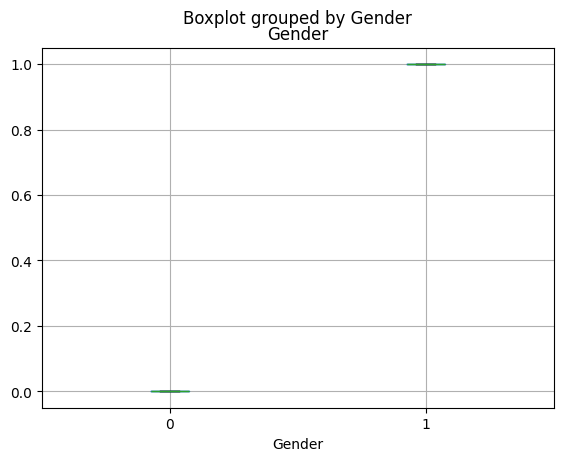

variable: Gender 
            count  mean  std  min  25%  50%  75%  max
Gender                                              
0       460919.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
1       587656.0   1.0  0.0  1.0  1.0  1.0  1.0  1.0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


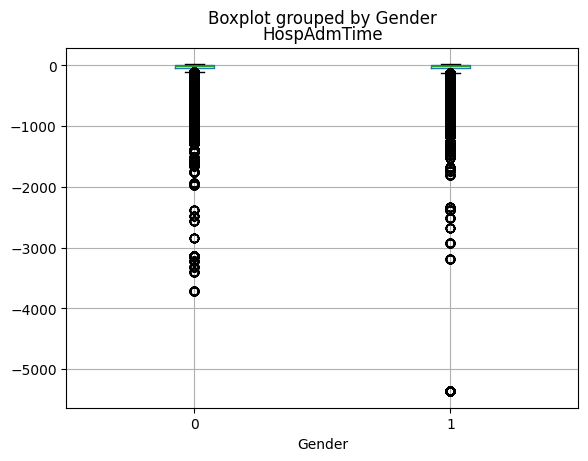

variable: HospAdmTime 
            count       mean         std      min    25%   50%   75%    max
Gender                                                                    
0       460919.0 -57.398374  170.179338 -3710.66 -45.32 -6.46 -0.04  20.04
1       587648.0 -56.296890  173.123248 -5366.86 -47.60 -5.71 -0.03  22.04
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


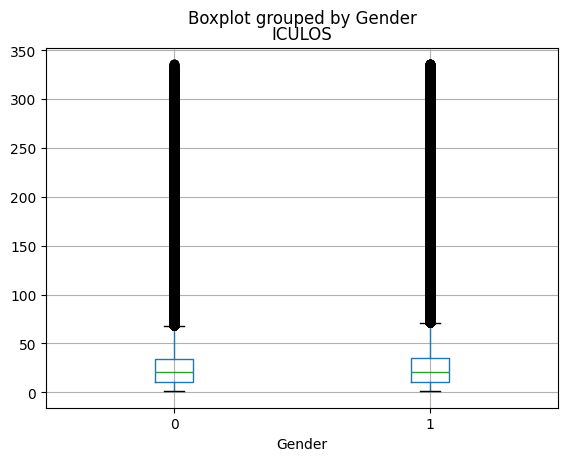

variable: ICULOS 
            count       mean        std  min   25%   50%   75%    max
Gender                                                              
0       460919.0  26.409206  27.147896  1.0  11.0  21.0  34.0  336.0
1       587656.0  27.513200  30.584959  1.0  11.0  21.0  35.0  336.0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


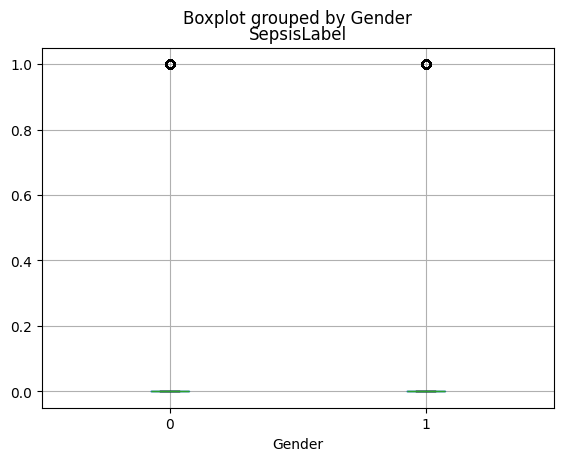

variable: SepsisLabel 
            count      mean       std  min  25%  50%  75%  max
Gender                                                       
0       460919.0  0.017079  0.129566  0.0  0.0  0.0  0.0  1.0
1       587656.0  0.018817  0.135879  0.0  0.0  0.0  0.0  1.0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


In [298]:

for var in df.columns:
  if var!= 'Patient_id':
    df.boxplot(column=[var], by='Gender')
    plt.show()
    print('variable:', var,'\n', df.groupby('Gender')[var].describe())
    print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')



In [299]:
# Function to assign categories based on age
def assign_category(age):
    if age >= 14 and age <= 30:
        return 1
    elif age > 30 and age <= 60:
        return 2
    elif age > 60 and age <= 100:
        return 3
    else:
        return None  # Handle cases outside the specified ranges

# Apply the function to create a new column 'Age_Category'
df['Age_Category'] = df['Age'].apply(assign_category)


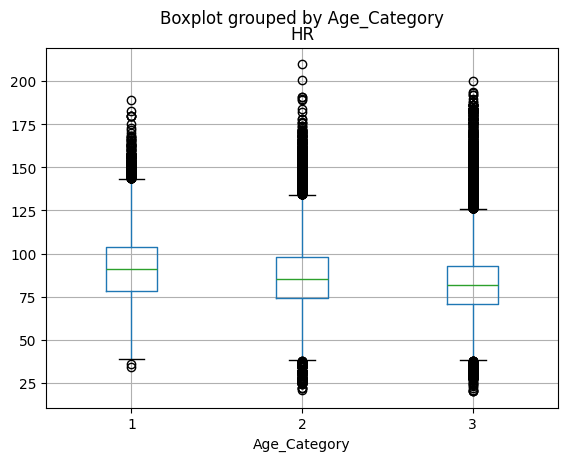

variable: HR 
                  count       mean        std   min   25%   50%    75%    max
Age_Category                                                                
1              45215.0  91.517439  19.010987  34.0  78.0  91.0  104.0  189.0
2             345660.0  86.467135  17.661078  21.0  74.0  85.5   98.0  210.0
3             554155.0  82.823235  16.677352  20.0  71.0  82.0   93.0  200.0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


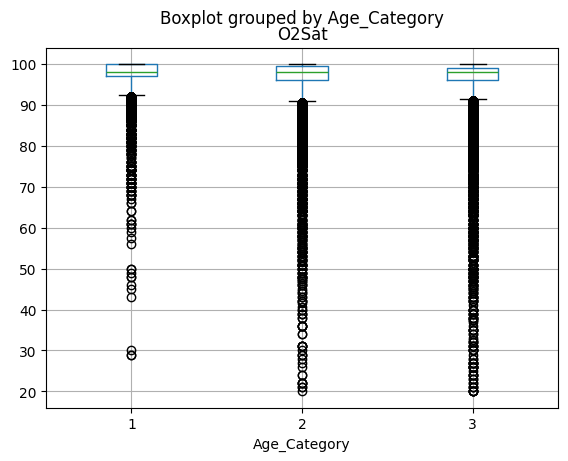

variable: O2Sat 
                  count       mean       std   min   25%   50%    75%    max
Age_Category                                                               
1              43452.0  97.773888  2.835418  29.0  97.0  98.0  100.0  100.0
2             331813.0  97.266446  2.895589  20.0  96.0  98.0   99.5  100.0
3             535900.0  97.101265  2.983217  20.0  96.0  98.0   99.0  100.0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


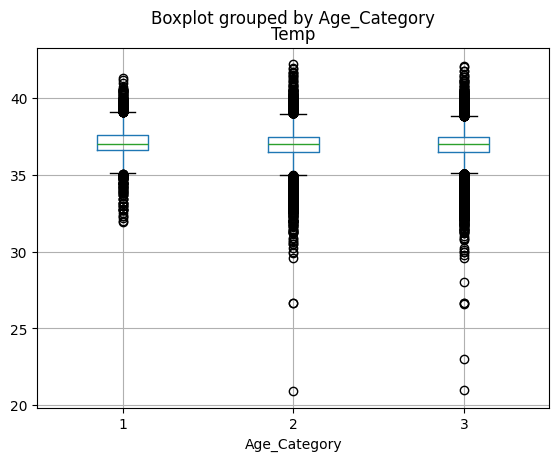

variable: Temp 
                  count       mean       std    min   25%   50%    75%    max
Age_Category                                                                
1              15048.0  37.085701  0.811936  31.95  36.6  37.0  37.60  41.30
2             124580.0  37.012115  0.786718  20.90  36.5  37.0  37.50  42.22
3             212270.0  36.944554  0.751232  21.00  36.5  37.0  37.44  42.10
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


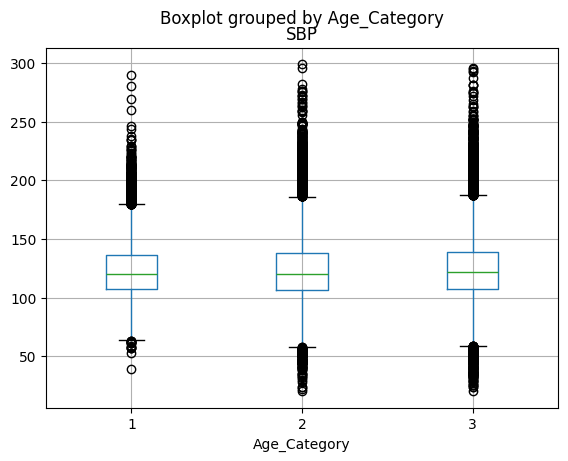

variable: SBP 
                  count        mean        std   min    25%    50%    75%  \
Age_Category                                                               
1              42637.0  122.814139  21.747912  39.0  107.0  120.0  136.0   
2             328702.0  123.390842  23.546595  20.0  106.0  120.0  138.0   
3             524971.0  124.078115  23.186947  20.0  107.0  122.0  139.0   

                max  
Age_Category         
1             290.0  
2             299.0  
3             296.0  
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


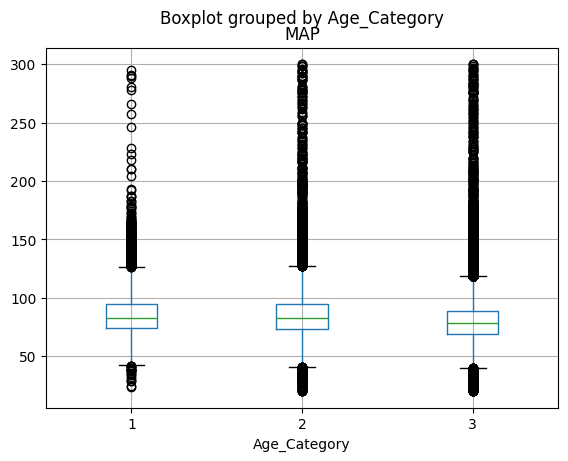

variable: MAP 
                  count       mean        std   min    25%    50%   75%    max
Age_Category                                                                 
1              43361.0  85.491532  16.594394  23.5  74.00  83.00  95.0  295.0
2             333721.0  85.254815  16.826080  20.0  73.33  83.00  95.0  300.0
3             541040.0  80.397105  15.705920  20.0  69.33  78.33  89.0  300.0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


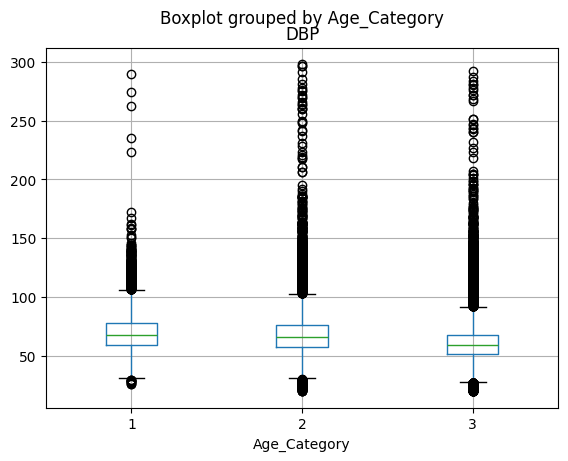

variable: DBP 
                  count       mean        std   min   25%   50%   75%    max
Age_Category                                                               
1              33241.0  69.314623  14.569515  26.0  59.0  68.0  78.0  290.0
2             263194.0  67.989461  13.996538  20.0  58.0  66.0  76.0  298.0
3             424992.0  60.824043  13.071281  20.0  52.0  59.0  68.0  292.0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


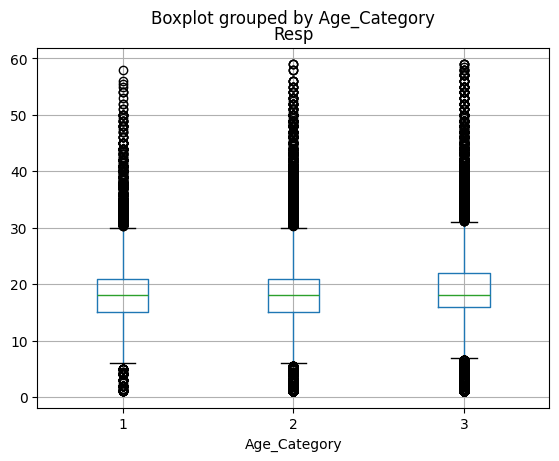

variable: Resp 
                  count       mean       std  min   25%   50%   75%   max
Age_Category                                                            
1              41982.0  18.742528  5.284206  1.0  15.0  18.0  21.0  58.0
2             322844.0  18.448486  5.055981  1.0  15.0  18.0  21.0  59.0
3             522324.0  18.886013  5.018495  1.0  16.0  18.0  22.0  59.0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


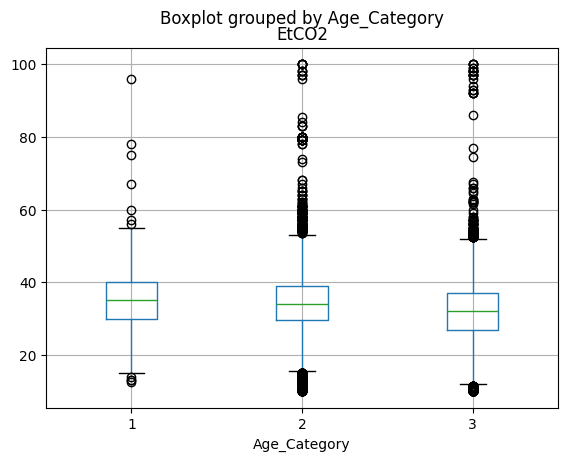

variable: EtCO2 
                 count       mean       std   min   25%   50%   75%    max
Age_Category                                                             
1              1514.0  34.949141  7.439560  12.5  30.0  35.0  40.0   96.0
2             16780.0  33.956049  7.963210  10.0  29.5  34.0  39.0  100.0
3             20110.0  31.864620  7.969681  10.0  27.0  32.0  37.0  100.0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


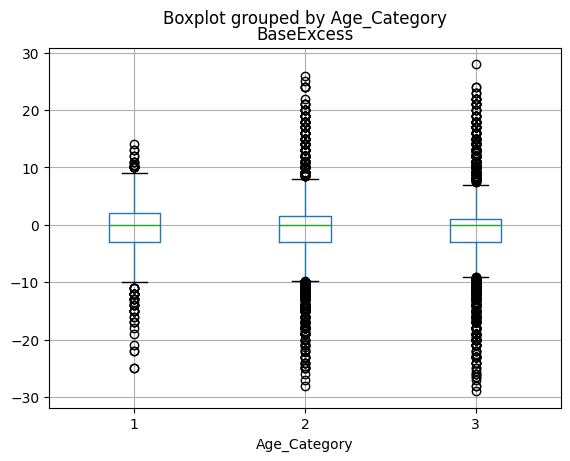

variable: BaseExcess 
                 count      mean       std   min  25%  50%  75%   max
Age_Category                                                        
1              1887.0 -0.463434  4.245738 -25.0 -3.0  0.0  2.0  14.0
2             18025.0 -0.556673  4.421698 -28.0 -3.0  0.0  1.5  26.0
3             37182.0 -0.762257  4.151920 -29.0 -3.0  0.0  1.0  28.0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


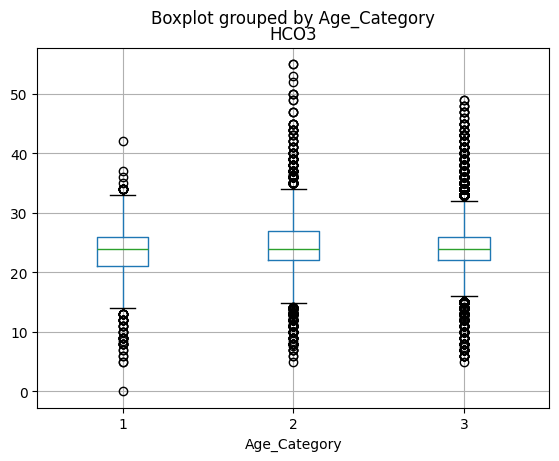

variable: HCO3 
                 count       mean       std  min   25%   50%   75%   max
Age_Category                                                           
1              2043.0  23.655923  4.404897  0.0  21.0  24.0  26.0  42.0
2             15555.0  23.975873  4.288684  5.0  22.0  24.0  27.0  55.0
3             26396.0  24.146655  4.332511  5.0  22.0  24.0  26.0  49.0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


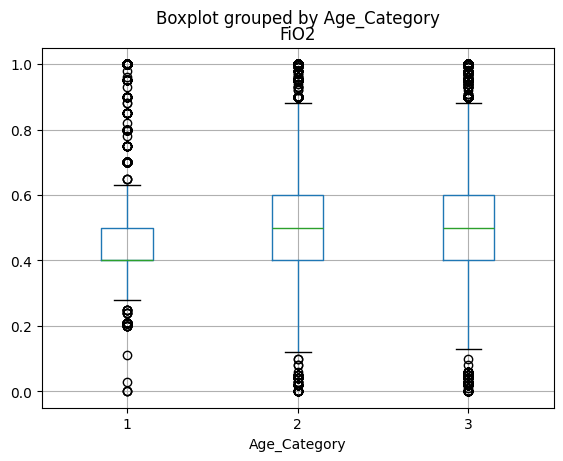

variable: FiO2 
                 count      mean       std  min  25%  50%  75%  max
Age_Category                                                      
1              3700.0  0.507293  0.200299  0.0  0.4  0.4  0.5  1.0
2             29347.0  0.521898  0.191521  0.0  0.4  0.5  0.6  1.0
3             54849.0  0.527559  0.188398  0.0  0.4  0.5  0.6  1.0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


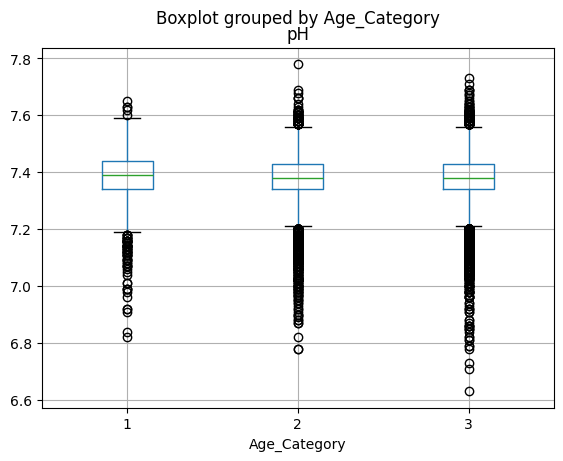

variable: pH 
                 count      mean       std   min   25%   50%   75%   max
Age_Category                                                           
1              2451.0  7.384463  0.086254  6.82  7.34  7.39  7.44  7.65
2             23492.0  7.377589  0.076972  6.78  7.34  7.38  7.43  7.78
3             46592.0  7.379584  0.072711  6.63  7.34  7.38  7.43  7.73
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


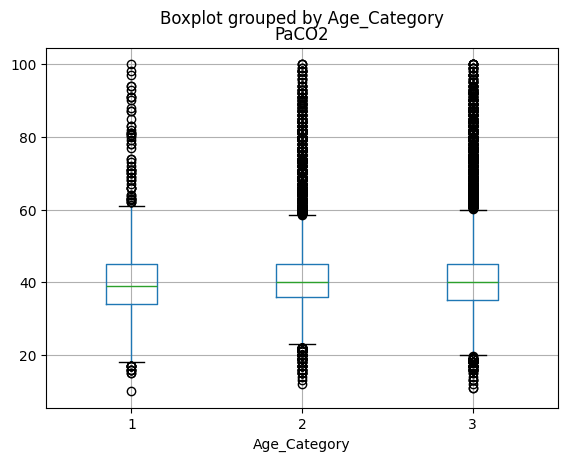

variable: PaCO2 
                 count       mean       std   min   25%   50%   75%    max
Age_Category                                                             
1              2066.0  40.268877  9.960857  10.0  34.0  39.0  45.0  100.0
2             19007.0  41.312858  9.237838  12.0  36.0  40.0  45.0  100.0
3             36929.0  40.852975  9.178415  11.0  35.0  40.0  45.0  100.0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


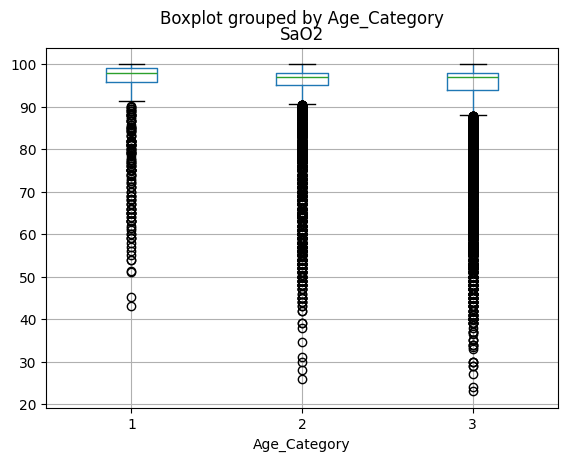

variable: SaO2 
                 count       mean        std   min    25%   50%   75%    max
Age_Category                                                               
1               756.0  93.831746  10.027717  43.0  95.85  98.0  99.0  100.0
2             10499.0  93.761406   9.590300  26.0  95.00  97.0  98.0  100.0
3             24753.0  91.943455  11.602351  23.0  94.00  97.0  98.0  100.0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


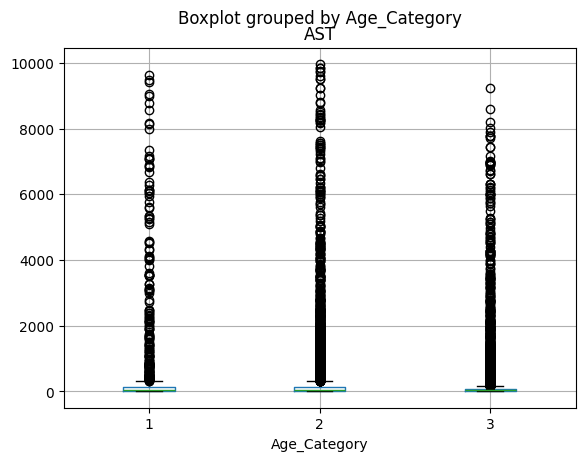

variable: AST 
                count        mean          std  min   25%   50%     75%     max
Age_Category                                                                  
1             1048.0  497.903626  1407.891121  5.0  21.0  42.0  138.25  9640.0
2             7283.0  296.243238   905.727855  5.0  23.0  47.0  144.00  9961.0
3             8547.0  192.961858   671.099000  3.0  22.0  37.0   84.00  9248.0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


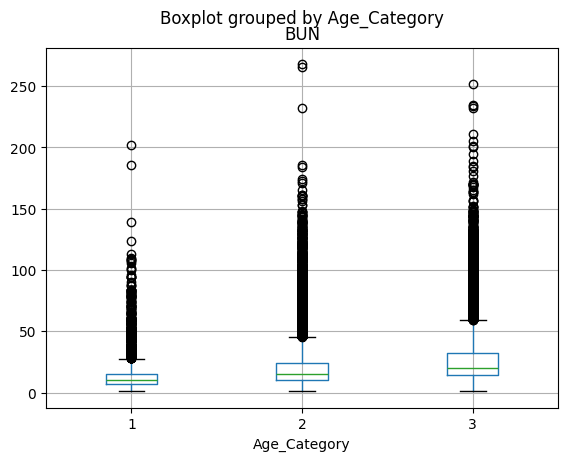

variable: BUN 
                 count       mean        std  min   25%   50%   75%    max
Age_Category                                                             
1              3694.0  14.593259  14.903627  1.0   7.0  10.0  15.0  202.0
2             26454.0  20.945982  18.705595  1.0  10.0  15.0  24.0  268.0
3             41756.0  26.639309  20.734984  1.0  14.0  20.0  32.0  252.0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


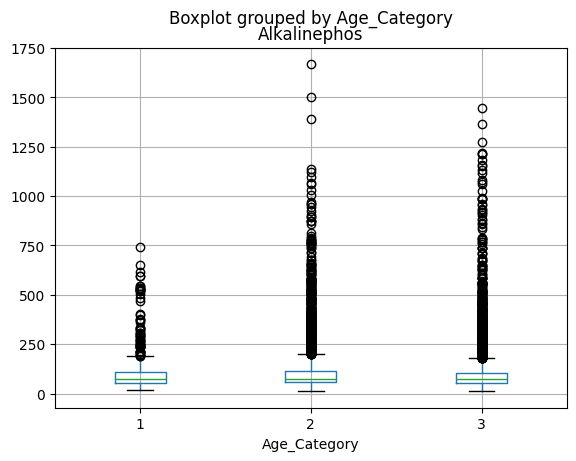

variable: Alkalinephos 
                count        mean         std   min   25%   50%    75%     max
Age_Category                                                                 
1             1040.0   95.985577   81.039768  18.0  54.0  74.0  109.0   744.0
2             7258.0  105.340775  103.270503  11.0  56.0  76.0  114.0  1669.0
3             8435.0   98.798217  100.336990  11.0  53.0  72.0  104.0  1447.0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


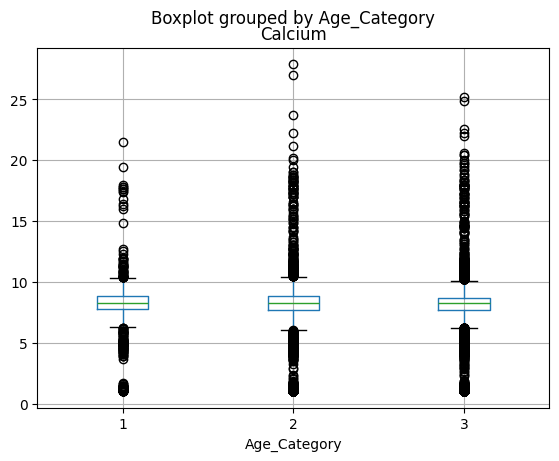

variable: Calcium 
                 count      mean       std  min  25%  50%  75%   max
Age_Category                                                       
1              3438.0  7.841216  2.180980  1.0  7.8  8.3  8.8  21.5
2             23300.0  7.617233  2.387537  1.0  7.7  8.3  8.8  27.9
3             34547.0  7.550089  2.431334  1.0  7.7  8.3  8.7  25.2
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


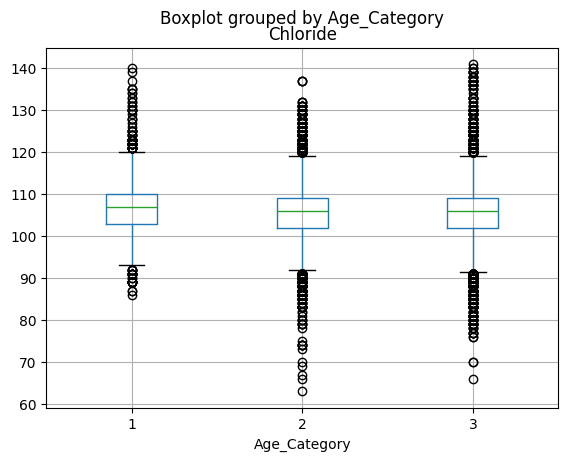

variable: Chloride 
                 count        mean       std   min    25%    50%    75%    max
Age_Category                                                                 
1              2129.0  106.830907  6.466499  86.0  103.0  107.0  110.0  140.0
2             16734.0  105.708498  5.931568  63.0  102.0  106.0  109.0  137.0
3             28677.0  105.854216  5.858601  66.0  102.0  106.0  109.0  141.0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


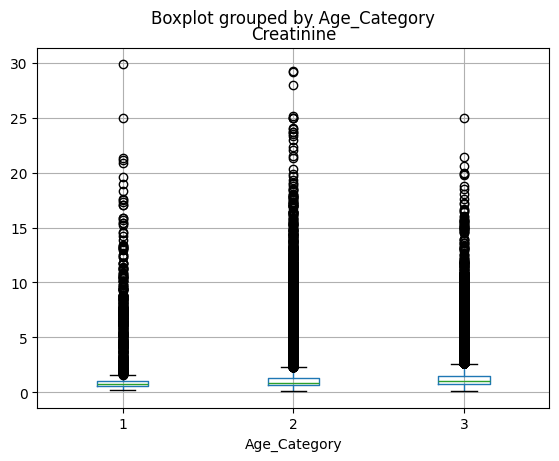

variable: Creatinine 
                 count      mean       std  min   25%  50%   75%    max
Age_Category                                                          
1              3397.0  1.472461  2.344727  0.2  0.60  0.8  1.01  29.86
2             23702.0  1.575513  2.133210  0.1  0.70  0.9  1.34  29.20
3             36651.0  1.488642  1.507583  0.1  0.76  1.0  1.51  25.00
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


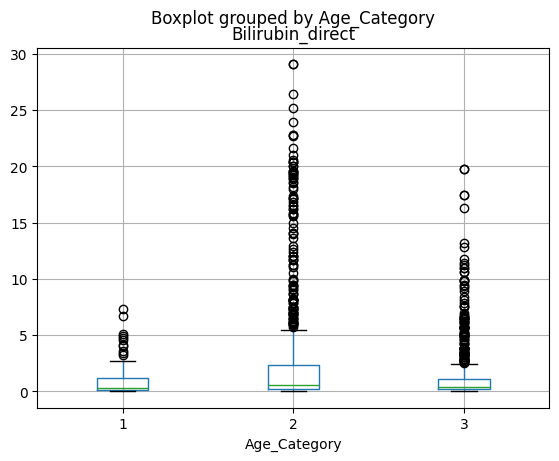

variable: Bilirubin_direct 
                count      mean       std   min  25%  50%    75%   max
Age_Category                                                         
1              142.0  0.929225  1.318689  0.01  0.1  0.3  1.200   7.3
2             1048.0  2.340900  4.368543  0.01  0.2  0.6  2.325  29.1
3              891.0  1.250438  2.340702  0.01  0.2  0.4  1.100  19.8
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


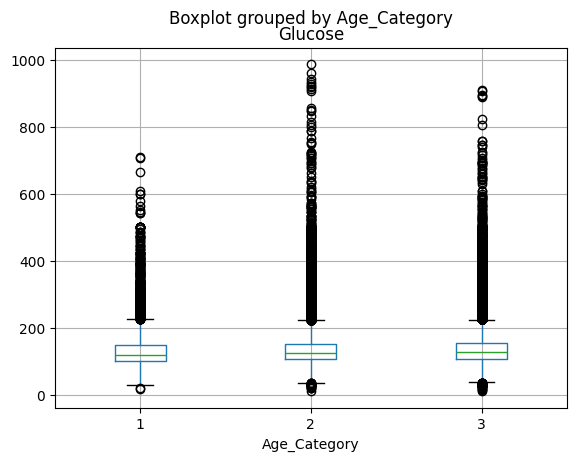

variable: Glucose 
                  count        mean        std   min    25%    50%    75%  \
Age_Category                                                               
1               8045.0  135.286948  59.601022  16.0  100.0  120.0  150.0   
2              65361.0  138.150021  55.776324  11.0  106.0  126.0  153.0   
3             104591.0  136.568543  48.801220  10.0  107.0  127.0  154.0   

                max  
Age_Category         
1             709.0  
2             988.0  
3             912.0  
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


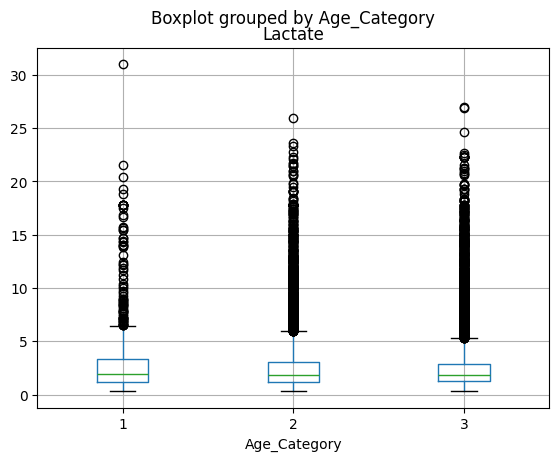

variable: Lactate 
                 count      mean       std   min  25%   50%  75%   max
Age_Category                                                         
1              1180.0  2.814347  2.931549  0.37  1.2  1.90  3.3  31.0
2              9748.0  2.707102  2.614719  0.30  1.2  1.81  3.1  25.9
3             16893.0  2.564004  2.381301  0.30  1.3  1.80  2.9  27.0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


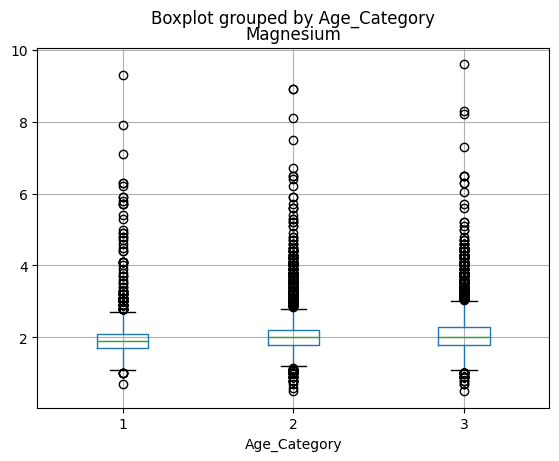

variable: Magnesium 
                 count      mean       std  min  25%  50%  75%  max
Age_Category                                                      
1              3439.0  1.975749  0.474444  0.7  1.7  1.9  2.1  9.3
2             24315.0  2.027240  0.407887  0.5  1.8  2.0  2.2  8.9
3             38462.0  2.072218  0.380977  0.5  1.8  2.0  2.3  9.6
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


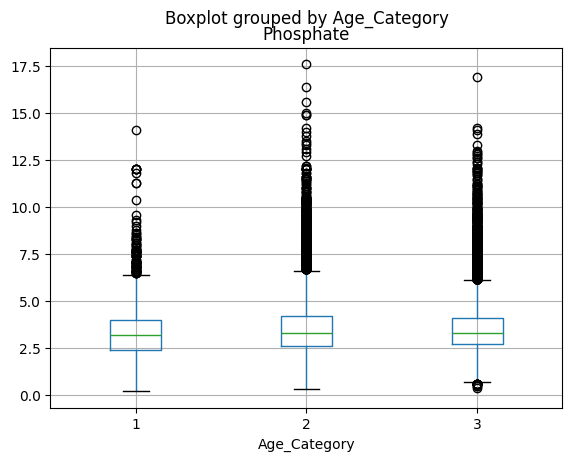

variable: Phosphate 
                 count      mean       std  min  25%  50%  75%   max
Age_Category                                                       
1              2615.0  3.334551  1.444485  0.2  2.4  3.2  4.0  14.1
2             16121.0  3.562161  1.512936  0.3  2.6  3.3  4.2  17.6
3             23310.0  3.568616  1.349811  0.4  2.7  3.3  4.1  16.9
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


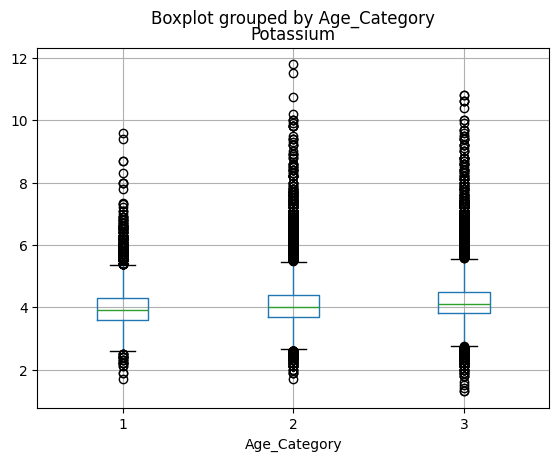

variable: Potassium 
                 count      mean       std  min  25%  50%  75%   max
Age_Category                                                       
1              4558.0  3.988093  0.679805  1.7  3.6  3.9  4.3   9.6
2             34951.0  4.111306  0.660794  1.7  3.7  4.0  4.4  11.8
3             57453.0  4.159260  0.624976  1.3  3.8  4.1  4.5  10.8
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


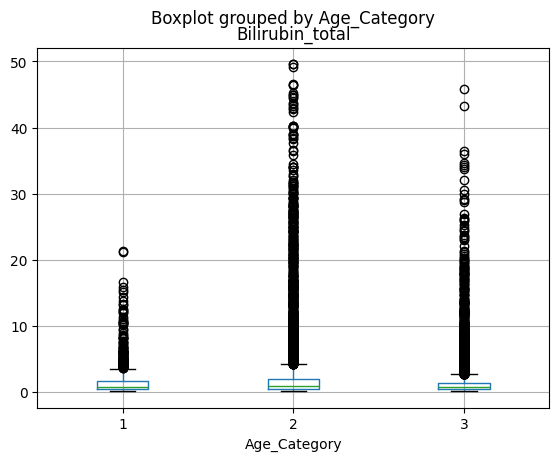

variable: Bilirubin_total 
                count      mean       std  min  25%  50%  75%   max
Age_Category                                                      
1             1012.0  1.687105  2.424110  0.1  0.5  0.8  1.7  21.3
2             6676.0  2.586257  5.239986  0.1  0.5  0.9  2.0  49.6
3             7810.0  1.577708  2.820243  0.1  0.5  0.8  1.4  45.9
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


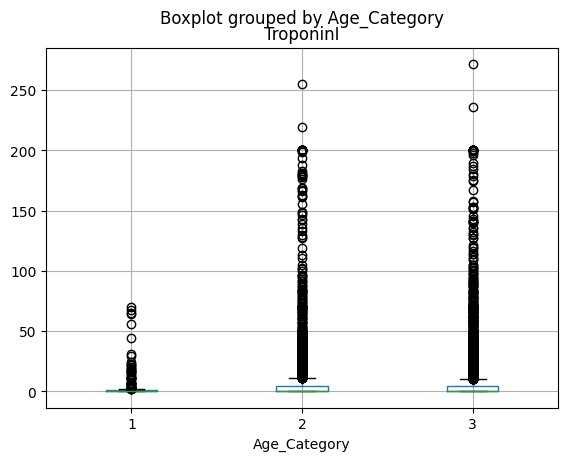

variable: TroponinI 
                count      mean        std   min   25%   50%     75%     max
Age_Category                                                               
1              257.0  3.462879  10.421655  0.01  0.03  0.09  0.8200   70.00
2             3652.0  9.451977  26.425312  0.01  0.03  0.18  4.3300  255.18
3             6178.0  7.809237  22.034194  0.01  0.05  0.38  4.1575  271.60
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


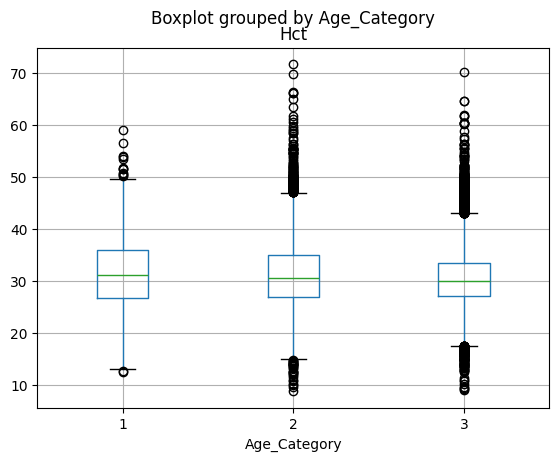

variable: Hct 
                 count       mean       std   min   25%   50%   75%   max
Age_Category                                                            
1              4257.0  31.527214  6.357247  12.5  26.8  31.2  36.0  59.0
2             32727.0  31.137790  5.888704   8.8  27.0  30.6  35.0  71.7
3             55831.0  30.526446  5.145459   9.1  27.1  30.0  33.5  70.2
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


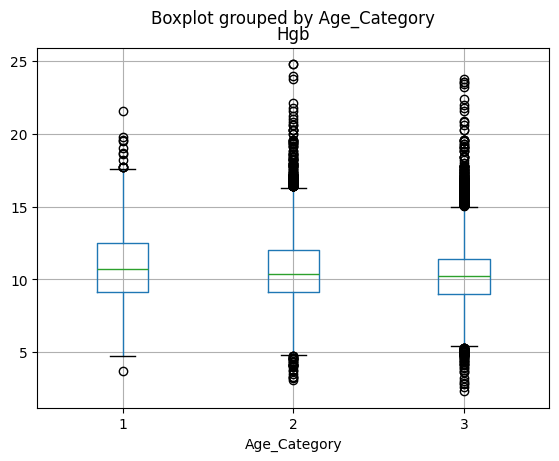

variable: Hgb 
                 count       mean       std  min  25%   50%   75%   max
Age_Category                                                          
1              3466.0  10.814772  2.343336  3.7  9.1  10.7  12.5  21.6
2             27611.0  10.578954  2.104774  3.1  9.1  10.4  12.0  24.8
3             46177.0  10.303831  1.830818  2.3  9.0  10.2  11.4  23.8
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


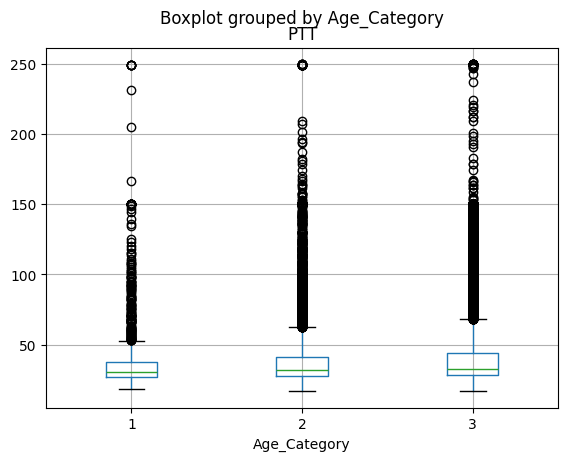

variable: PTT 
                 count       mean        std   min   25%   50%   75%    max
Age_Category                                                              
1              1400.0  38.118536  25.960659  18.1  26.5  30.5  37.2  249.0
2             11055.0  39.759973  24.629588  17.1  27.4  32.0  41.4  250.0
3             18489.0  42.369772  27.287717  16.6  28.1  32.8  44.1  250.0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


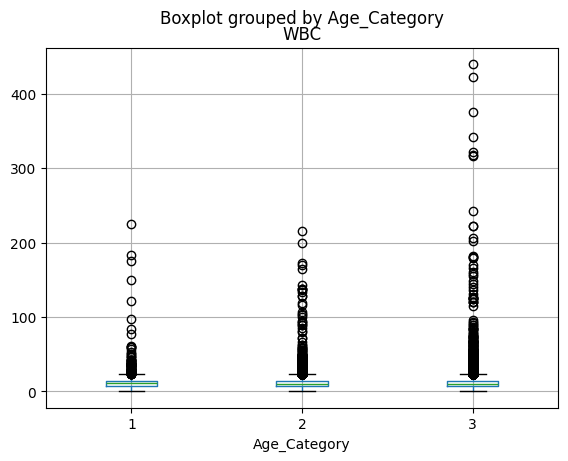

variable: WBC 
                 count       mean       std  min  25%   50%   75%    max
Age_Category                                                           
1              3180.0  11.844478  9.266023  0.1  7.6  10.7  14.0  224.9
2             24526.0  11.260386  6.888363  0.1  7.4  10.2  13.7  215.3
3             39376.0  11.618279  8.537380  0.1  7.8  10.4  13.8  440.0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


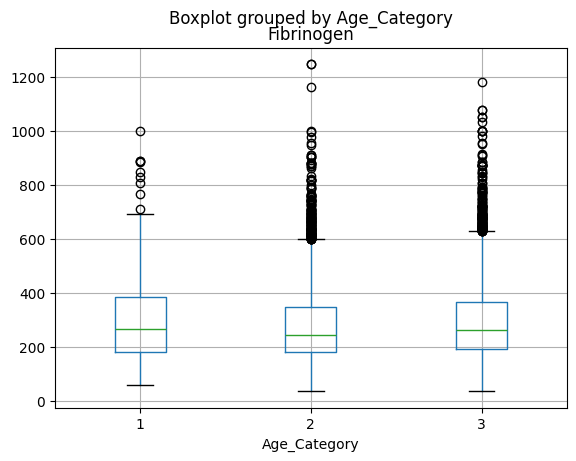

variable: Fibrinogen 
                count        mean         std   min    25%    50%    75%  \
Age_Category                                                              
1              395.0  296.398734  162.008166  56.0  180.5  265.0  385.0   
2             3077.0  283.599610  151.789725  35.0  180.0  244.0  347.0   
3             3317.0  297.224601  152.540826  34.0  192.0  263.0  366.0   

                 max  
Age_Category          
1             1000.0  
2             1246.0  
3             1179.0  
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


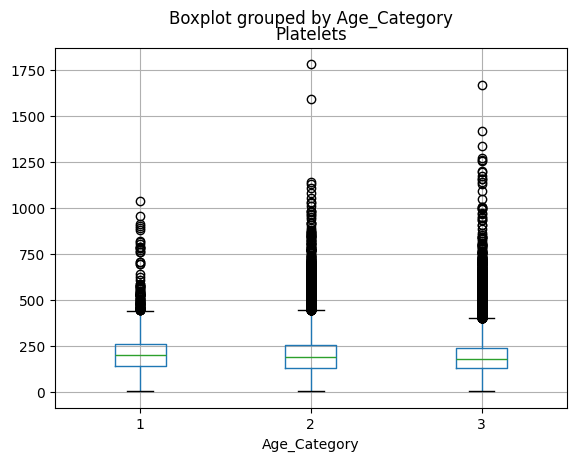

variable: Platelets 
                 count        mean         std  min    25%    50%    75%  \
Age_Category                                                              
1              3008.0  210.498005  108.891195  1.0  141.0  199.5  261.0   
2             22860.0  201.505490  109.762806  2.0  127.0  188.0  253.0   
3             36124.0  193.023965   99.680316  4.0  127.0  176.0  236.0   

                 max  
Age_Category          
1             1036.0  
2             1783.0  
3             1667.0  
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


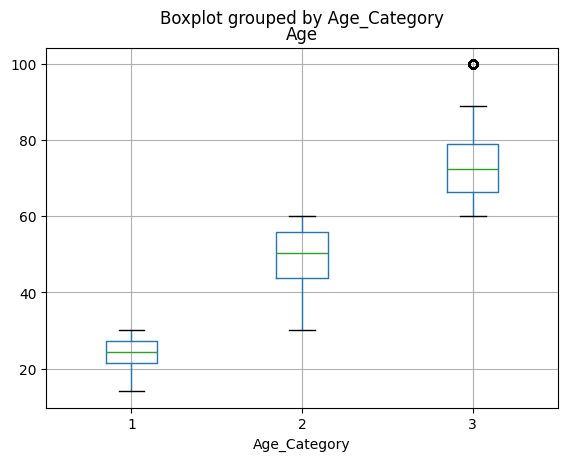

variable: Age 
                  count       mean       std    min    25%    50%    75%    max
Age_Category                                                                  
1              51237.0  24.390224  3.503401  14.00  21.46  24.44  27.23   30.0
2             387841.0  49.118826  7.909179  30.06  43.77  50.38  56.00   60.0
3             609497.0  73.292379  8.408095  60.01  66.44  72.34  79.03  100.0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


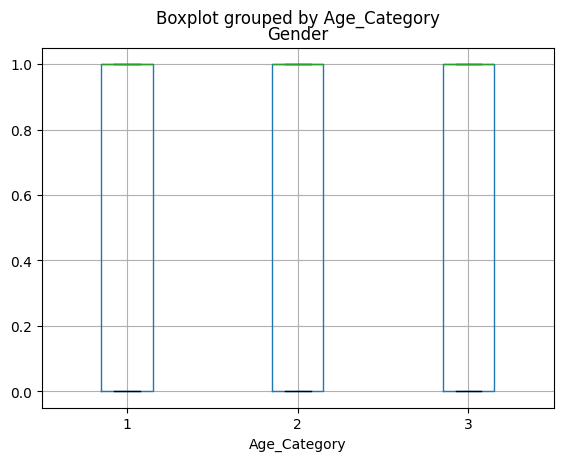

variable: Gender 
                  count      mean       std  min  25%  50%  75%  max
Age_Category                                                       
1              51237.0  0.513652  0.499818  0.0  0.0  1.0  1.0  1.0
2             387841.0  0.582594  0.493132  0.0  0.0  1.0  1.0  1.0
3             609497.0  0.550264  0.497468  0.0  0.0  1.0  1.0  1.0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


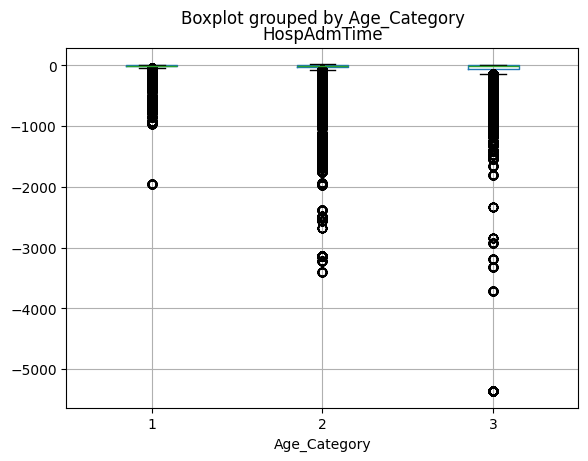

variable: HospAdmTime 
                  count       mean         std      min    25%   50%   75%  \
Age_Category                                                                
1              51237.0 -48.063756  148.627093 -1954.53 -17.58 -2.85 -0.02   
2             387841.0 -55.251463  176.315366 -3397.64 -32.58 -5.15 -0.03   
3             609489.0 -58.487243  170.733421 -5366.86 -54.84 -7.40 -0.04   

                max  
Age_Category         
1              9.44  
2             22.04  
3             14.65  
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


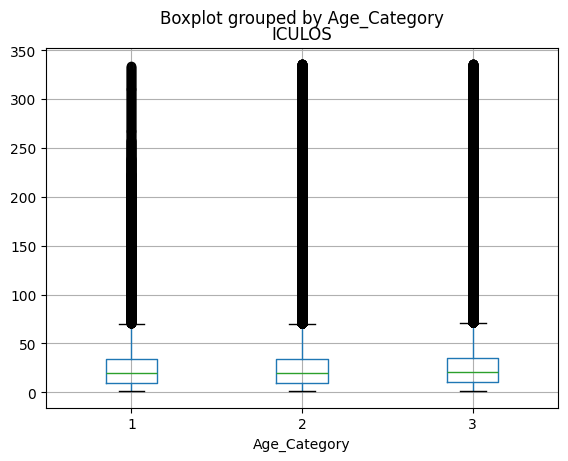

variable: ICULOS 
                  count       mean        std  min   25%   50%   75%    max
Age_Category                                                              
1              51237.0  26.143822  28.574613  1.0  10.0  20.0  34.0  334.0
2             387841.0  26.294108  28.490208  1.0  10.0  20.0  34.0  336.0
3             609497.0  27.569189  29.562460  1.0  11.0  21.0  35.0  336.0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


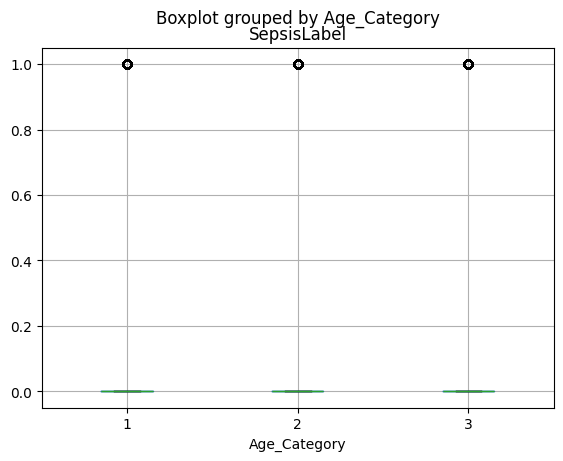

variable: SepsisLabel 
                  count      mean       std  min  25%  50%  75%  max
Age_Category                                                       
1              51237.0  0.017038  0.129416  0.0  0.0  0.0  0.0  1.0
2             387841.0  0.017463  0.130990  0.0  0.0  0.0  0.0  1.0
3             609497.0  0.018514  0.134799  0.0  0.0  0.0  0.0  1.0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


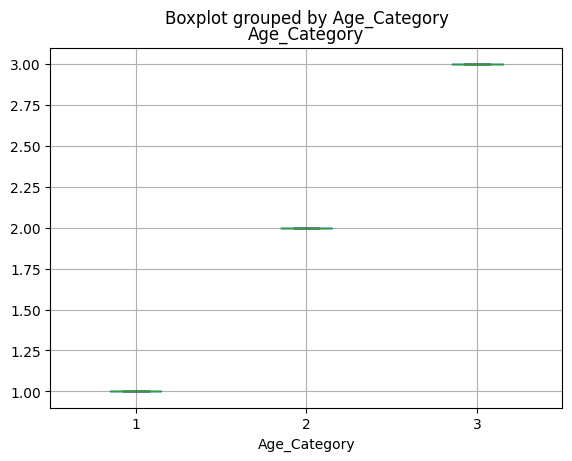

variable: Age_Category 
                  count  mean  std  min  25%  50%  75%  max
Age_Category                                              
1              51237.0   1.0  0.0  1.0  1.0  1.0  1.0  1.0
2             387841.0   2.0  0.0  2.0  2.0  2.0  2.0  2.0
3             609497.0   3.0  0.0  3.0  3.0  3.0  3.0  3.0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


In [300]:
for var in df.columns:
  if var!= 'Patient_id':
    df.boxplot(column=[var], by='Age_Category')
    plt.show()
    print('variable:', var,'\n', df.groupby('Age_Category')[var].describe())
    print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')


its pertinent to understand the missingness pattern in the dataset. Apart from values, perhaps frequency of missingness in features could also be informative in predicting sepsis. 

<Axes: >

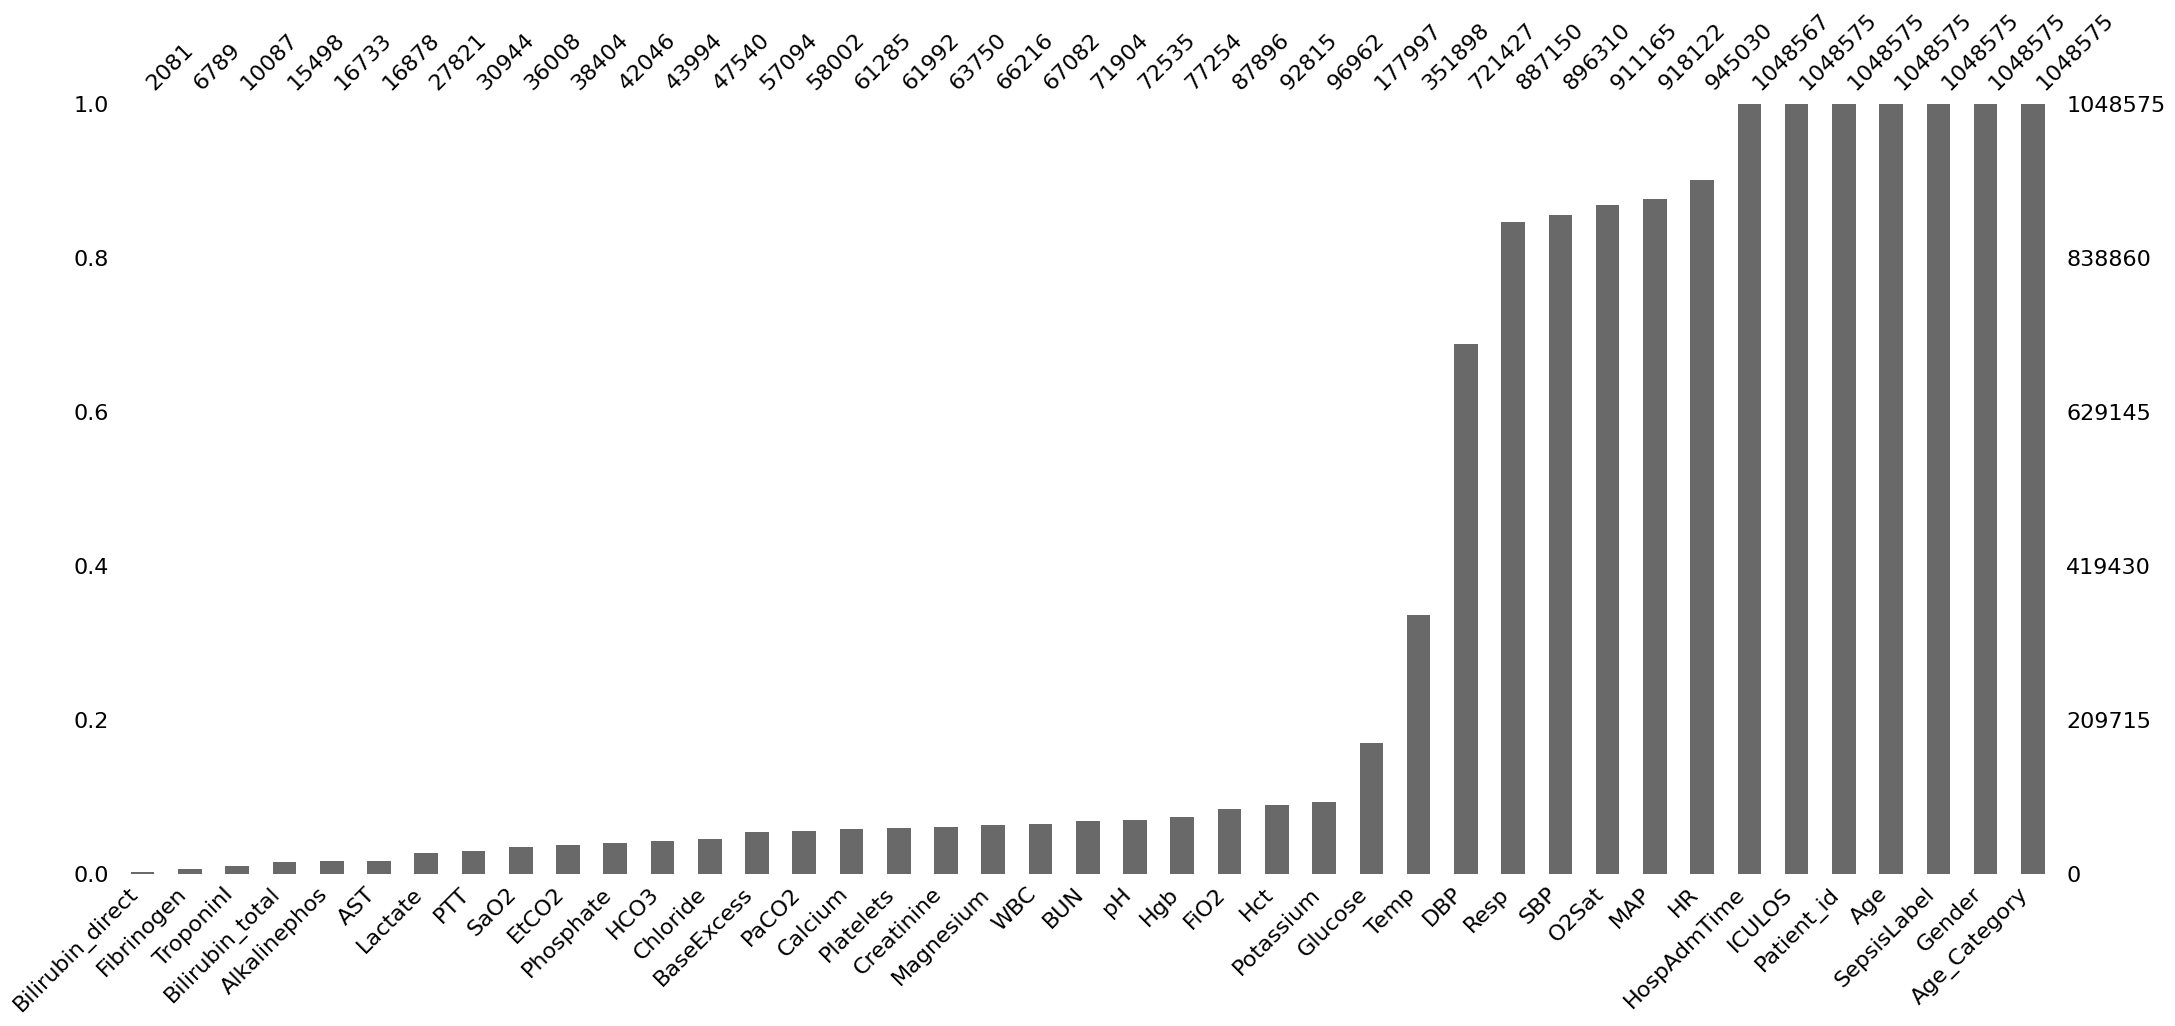

In [301]:
import missingno as msno
msno.bar(df, sort="ascending")

-1 - Exact Negative correlation represents that if the value of one variable is present then the value of other variables is definitely absent.
0 - No correlation represents that variables' values present or absent do not have any effect on one another.
1 - Exact Positive correlation represents that if the value of one variable is present then the value of the other is definitely present.

<Axes: >

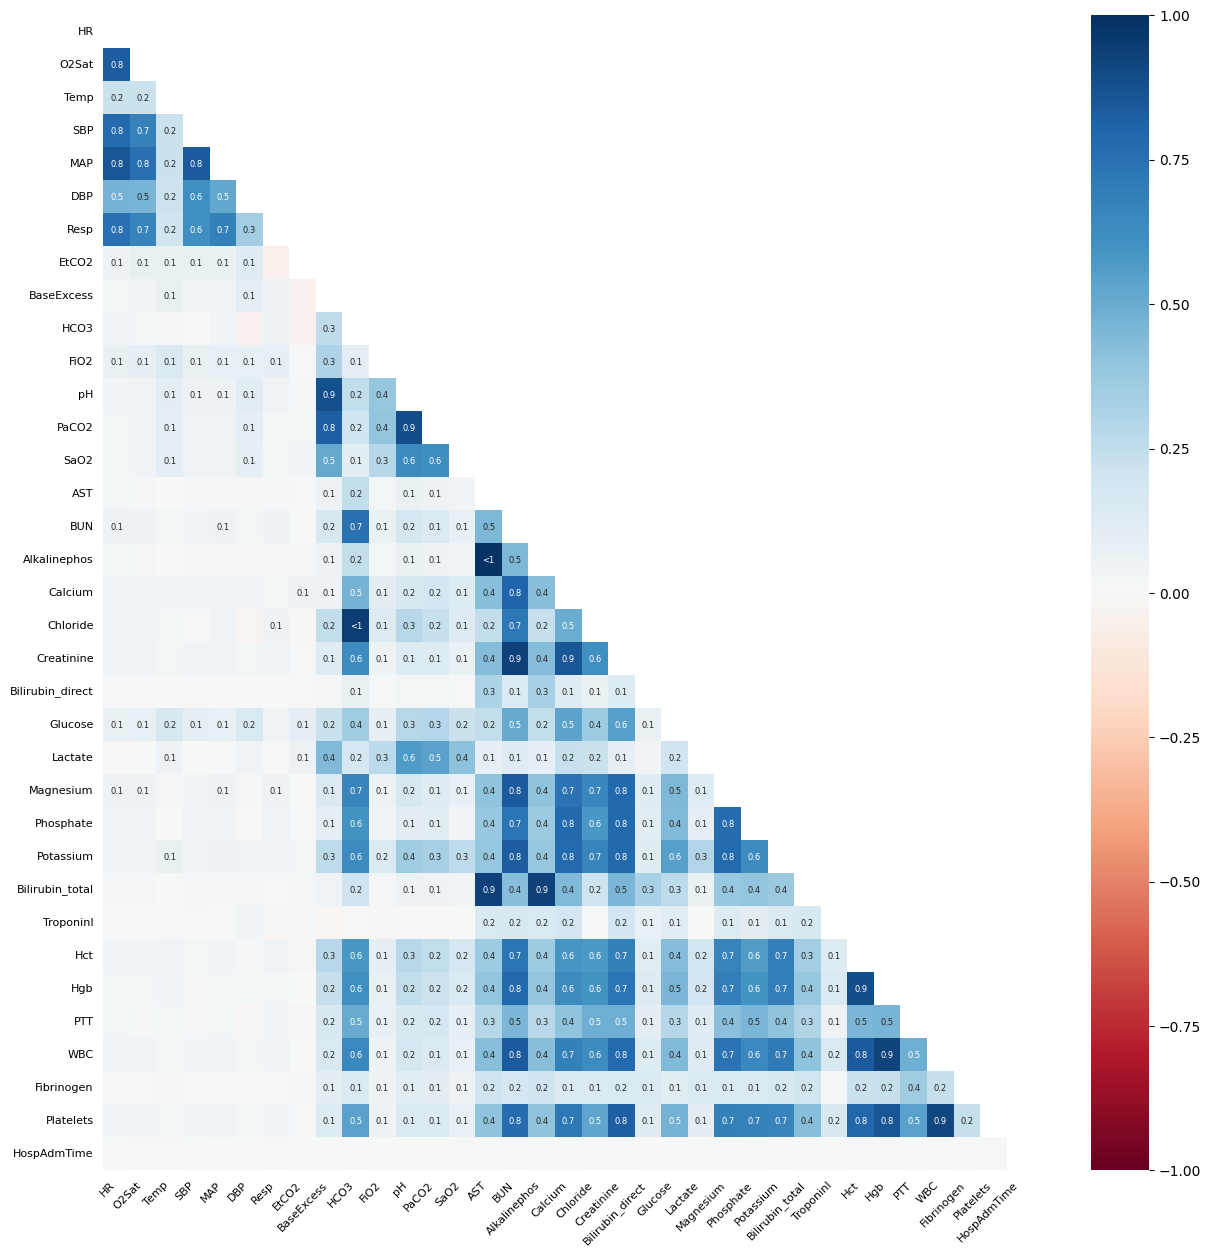

In [302]:
msno.heatmap(df, figsize=(15,15), fontsize=8)


'SepsisLabel' 0 has a higher proportion of missing values for most features compared to 'SepsisLabel' 1. However, significance in difference cannot be determined with only bar plots. But this gives us an indication that perhaps missingness is not completely at random and it would be worthwhile to explore this pattern and add it as a predictive feature. 

Patient_id
HR
0.09910600255427841 0.07929212889593239


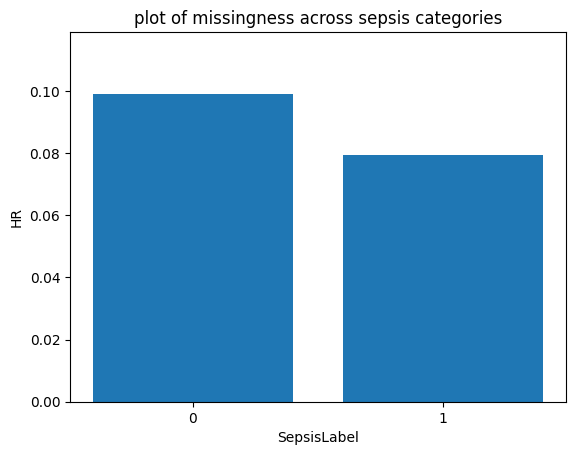

O2Sat
0.13154533844189017 0.10380348652931855


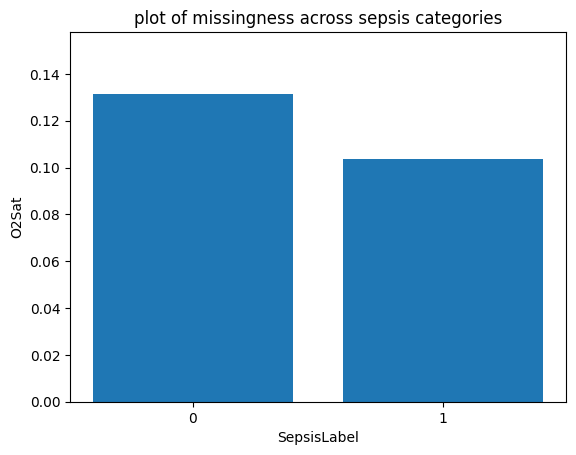

Temp
0.6643872402624206 0.6652931854199683


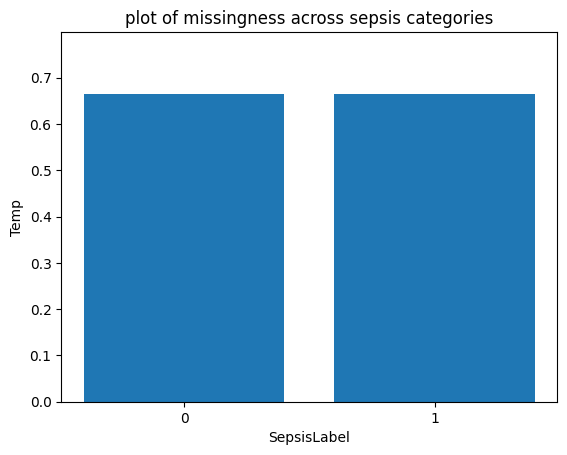

SBP
0.14512963205765095 0.1496566296883254


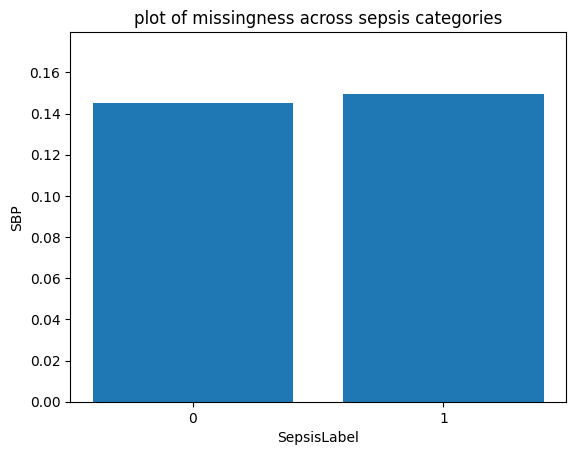

MAP
0.12497025673897313 0.09392498679344954


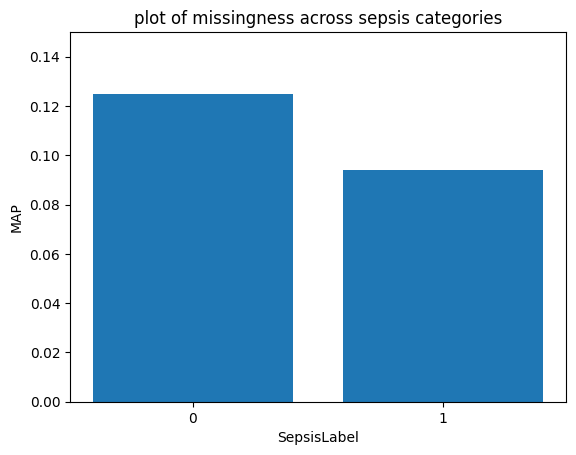

DBP
0.3124115593238446 0.28922345483359746


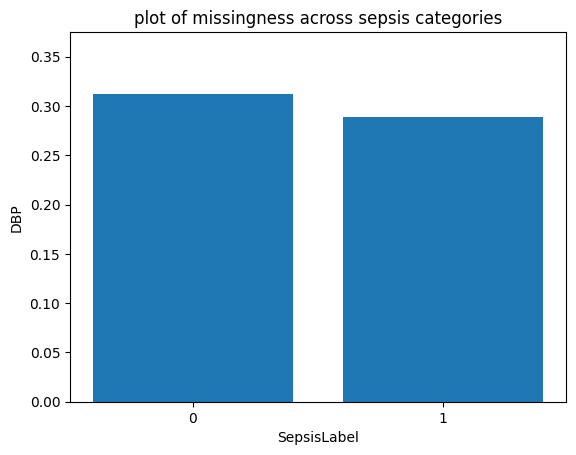

Resp
0.15413176386035965 0.14389857369255152


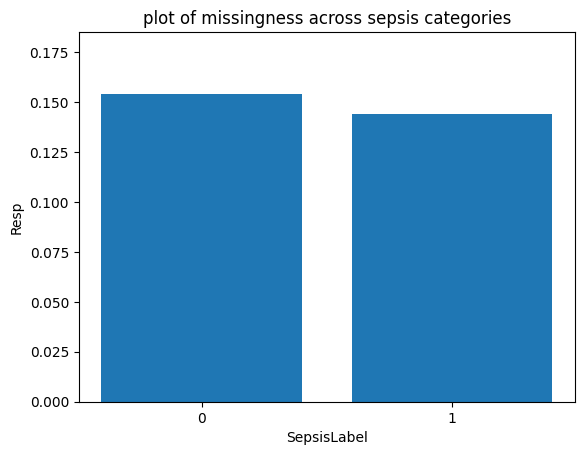

EtCO2
0.9646120750355706 0.8960908610670892


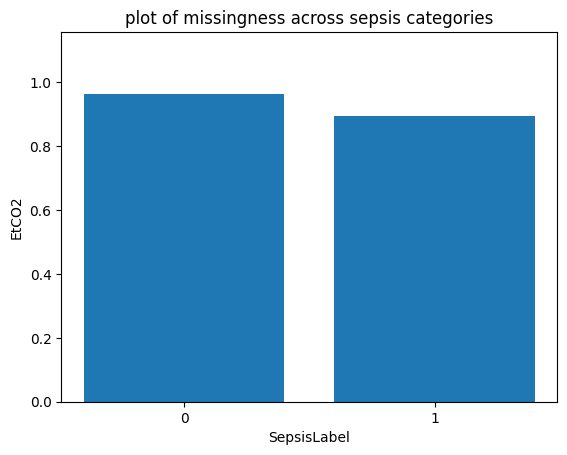

BaseExcess
0.9464388211470944 0.8972530375066032


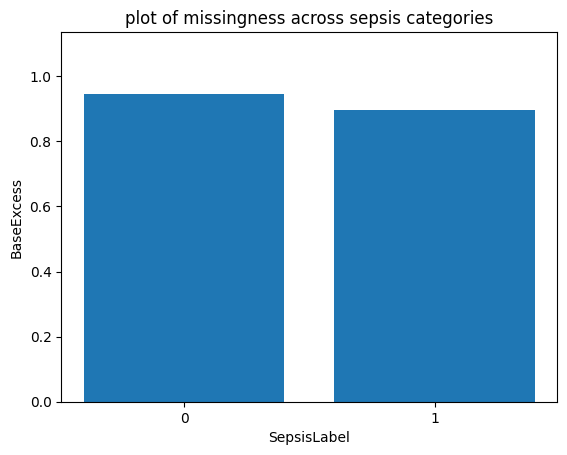

HCO3
0.9584050813629941 0.938404648705758


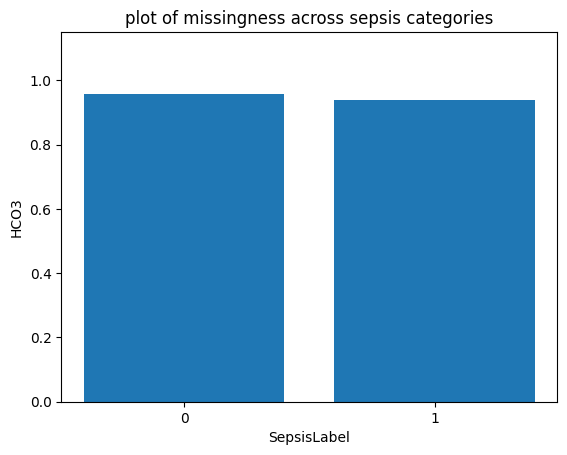

FiO2
0.9180008643755858 0.8169043845747491


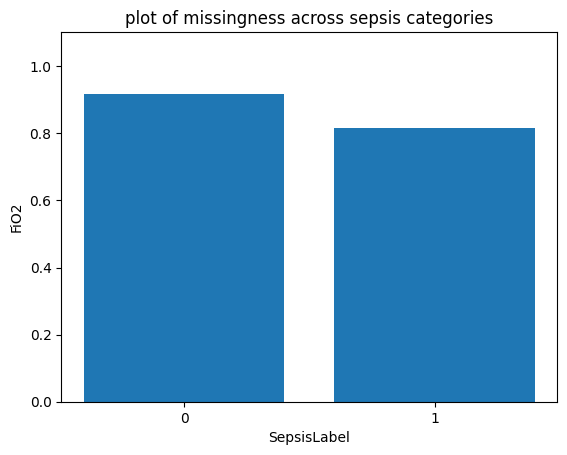

pH
0.9320154033671799 0.8660855784469097


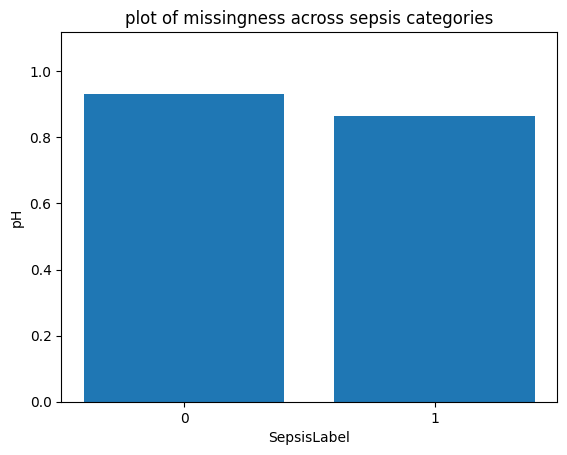

PaCO2
0.9457609175978129 0.8861595351294242


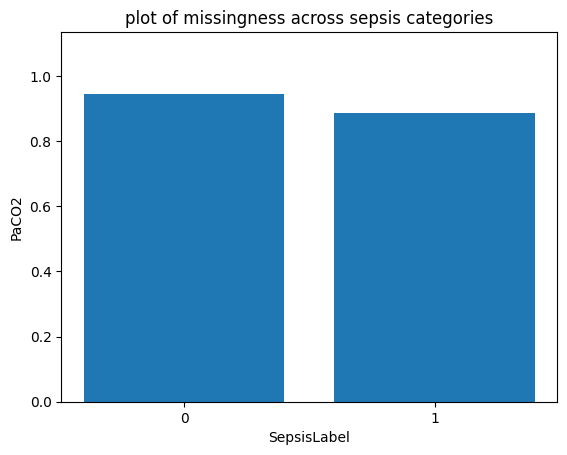

SaO2
0.9662135978905351 0.9355520338087692


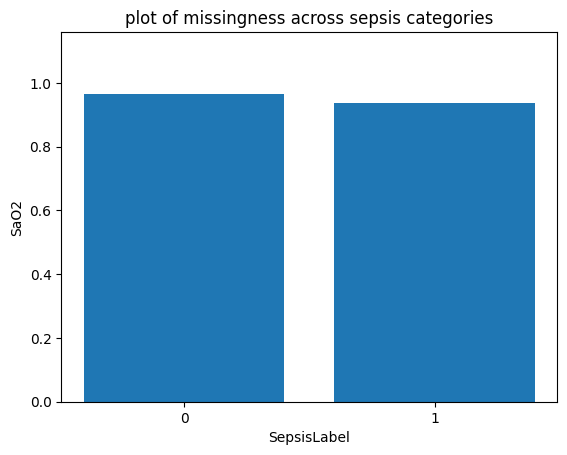

AST
0.984162502610123 0.9698362387744321


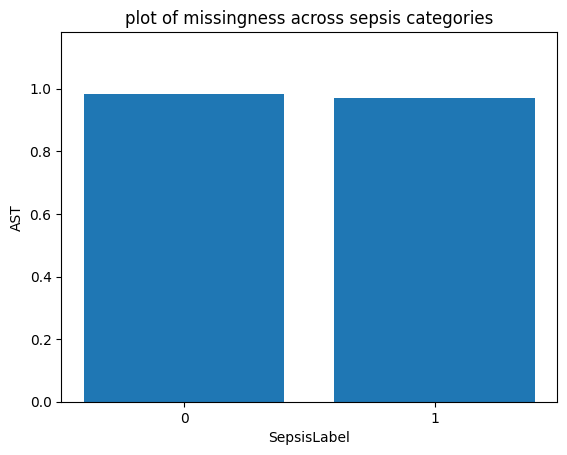

BUN
0.9318221328710381 0.9099313259376651


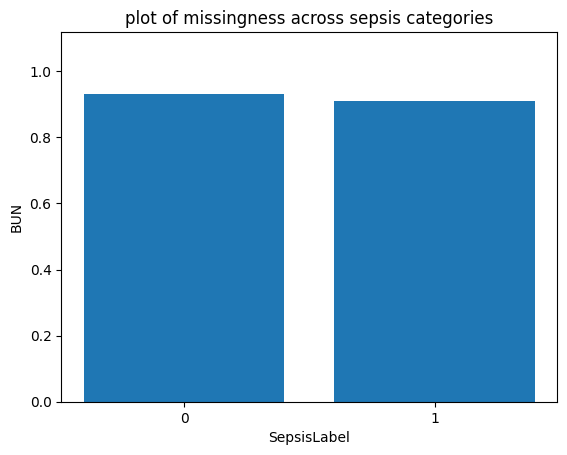

Alkalinephos
0.9843013854289585 0.9699418911780243


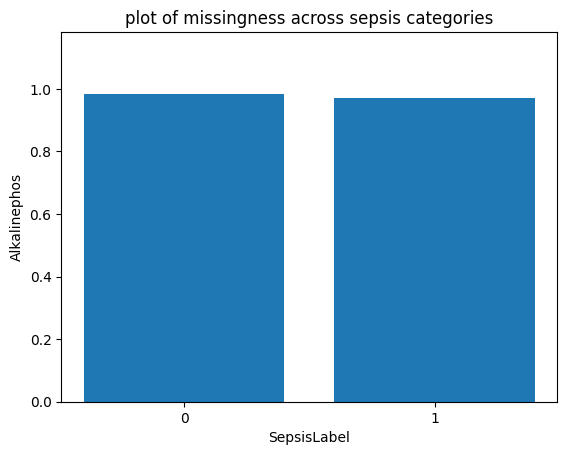

Calcium
0.9420509010387075 0.914527205493925


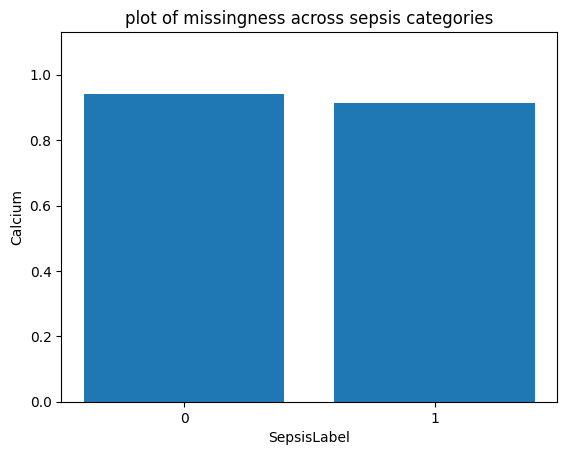

Chloride
0.9550835482132192 0.9317485472794506


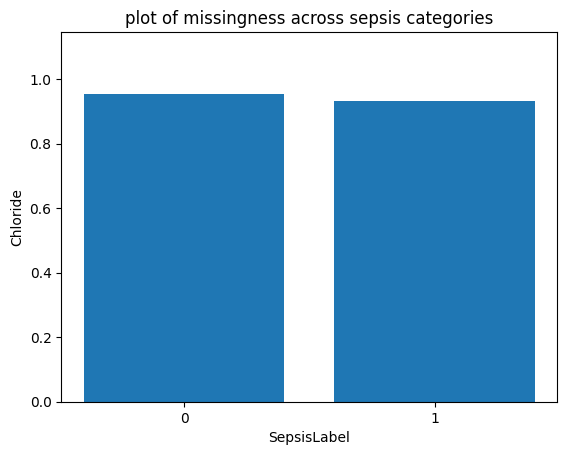

Creatinine
0.9395034210820234 0.9228737453777074


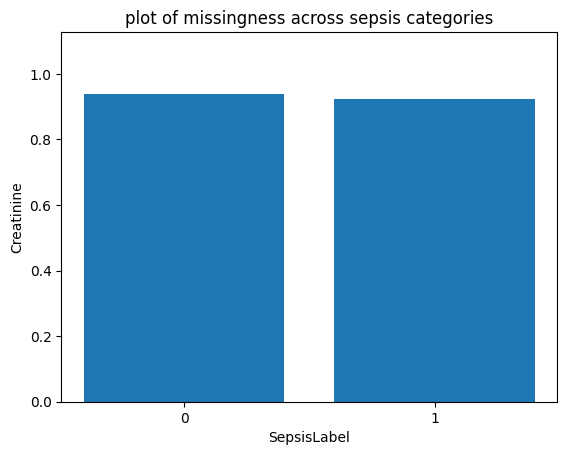

Bilirubin_direct
0.9980556405363014 0.9958267300581088


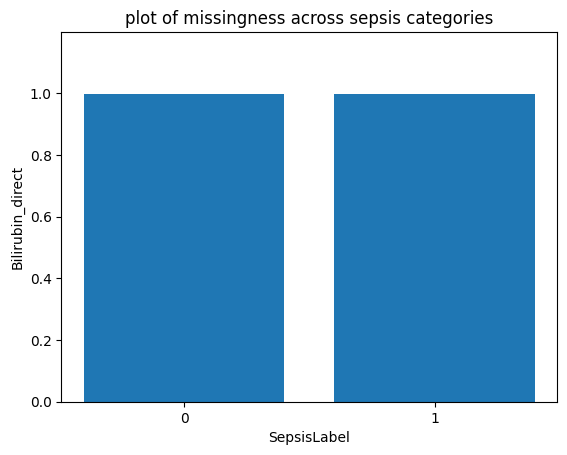

Glucose
0.8304629265426433 0.818594823032224


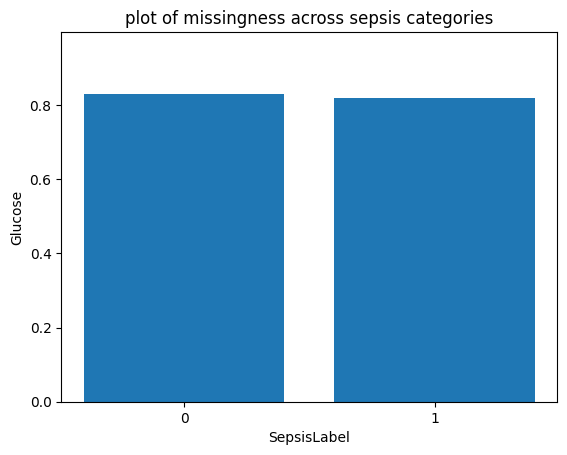

Lactate
0.9742192697483113 0.932593766508188


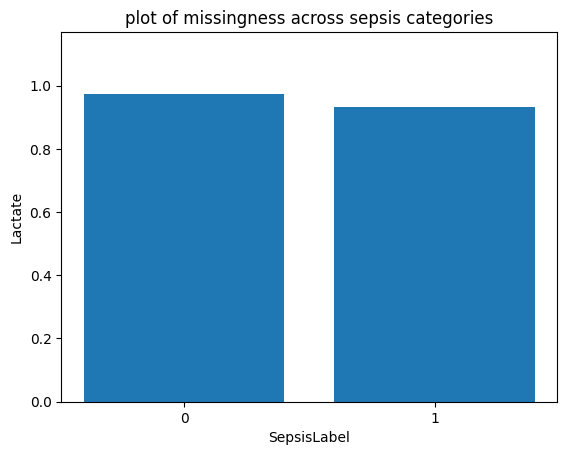

Magnesium
0.9372531309334771 0.9150026413100898


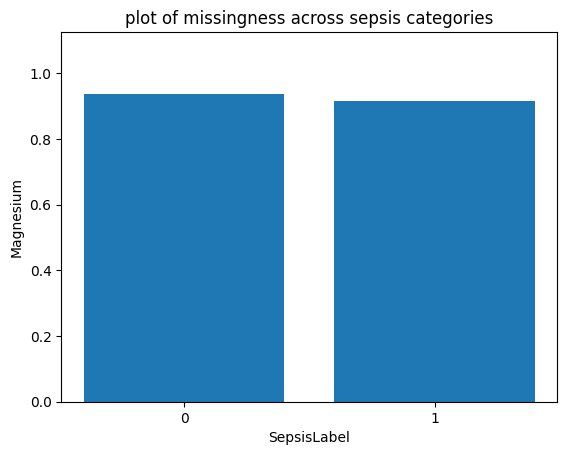

Phosphate
0.9602387230550335 0.9415742208135235


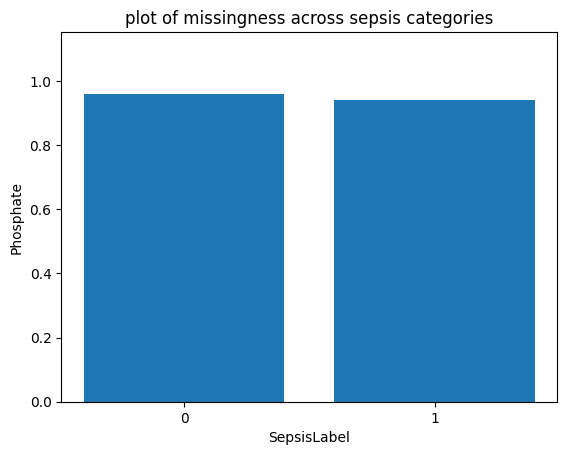

Potassium
0.9082139960860296 0.8703116745905969


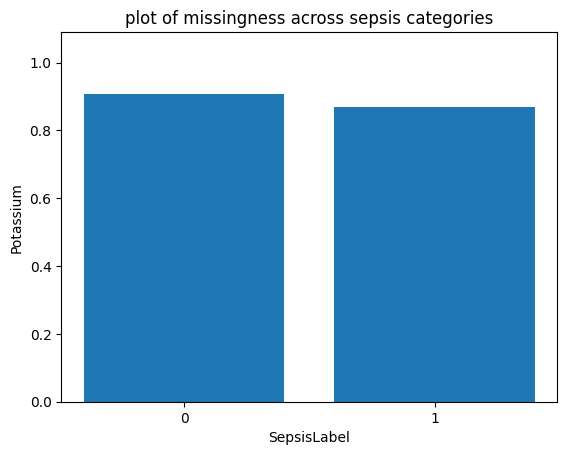

Bilirubin_total
0.9854396418182966 0.973269941891178


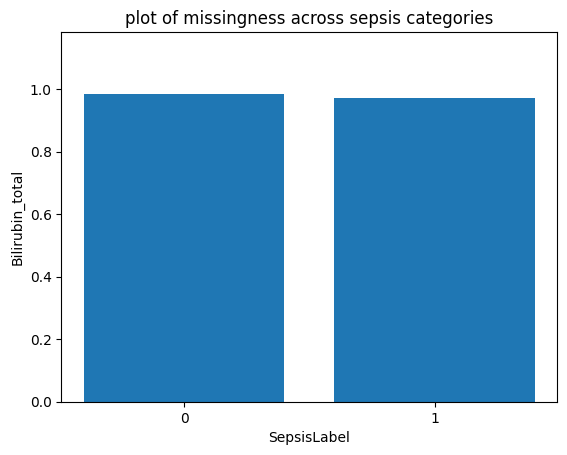

TroponinI
0.9904054309980624 0.9890121500264131


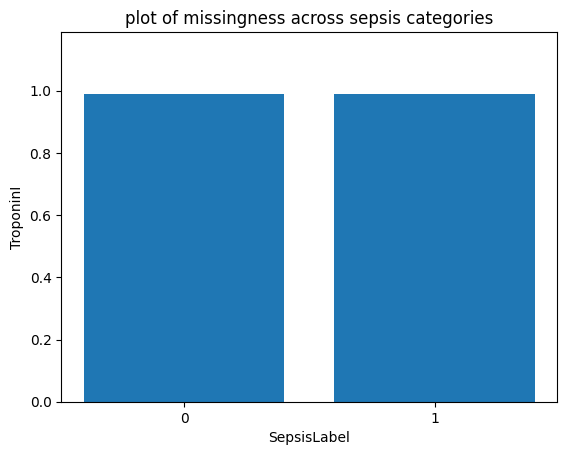

Hct
0.911929839896275 0.8872688853671421


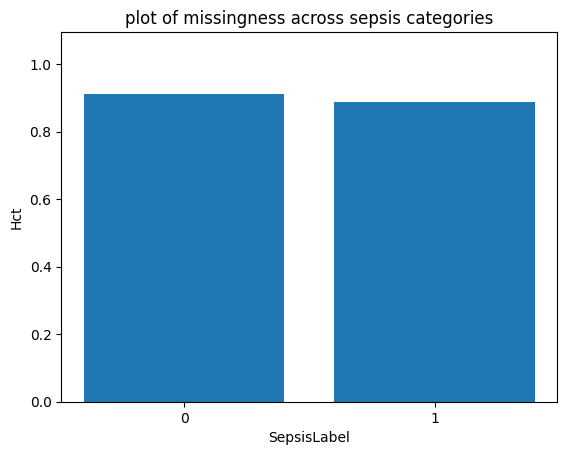

Hgb
0.9267417410855198 0.9036450079239303


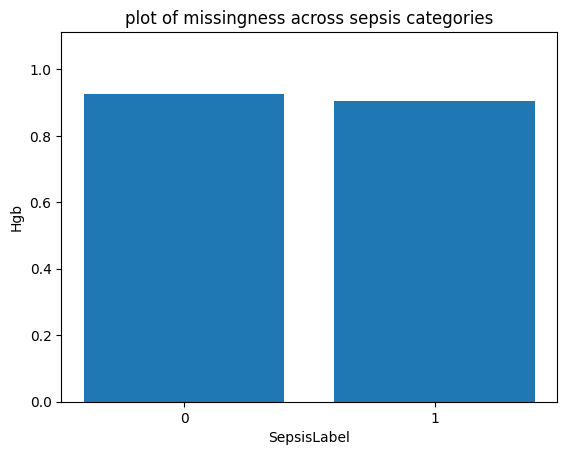

PTT
0.9707481704859442 0.9564183835182251


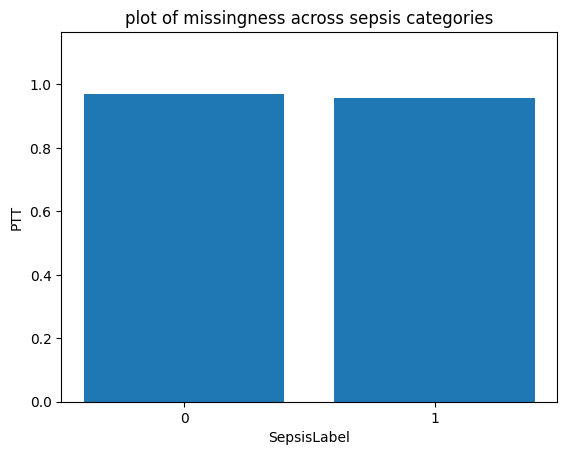

WBC
0.9363751584283904 0.9170100369783413


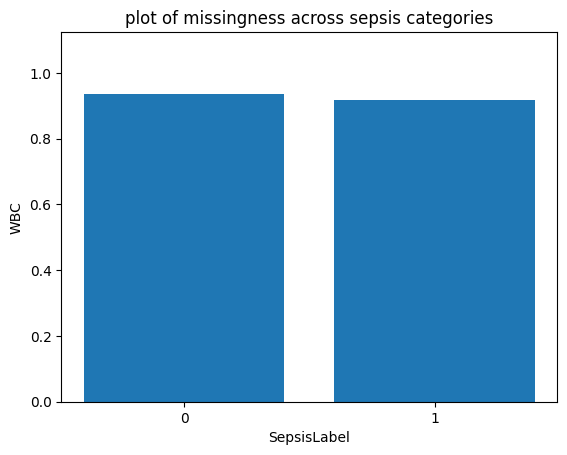

Fibrinogen
0.9936181887932248 0.9884838880084522


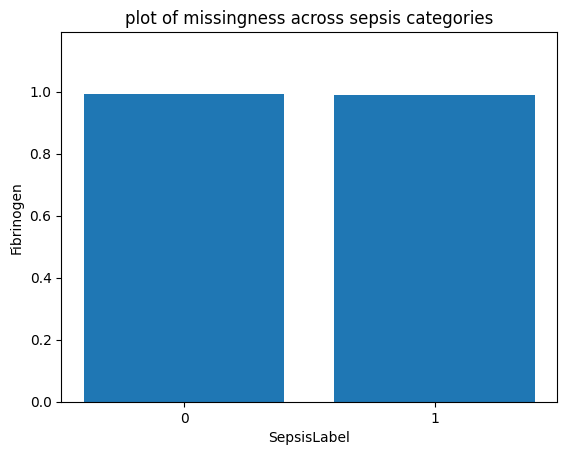

Platelets
0.9411651588654342 0.9253565768621236


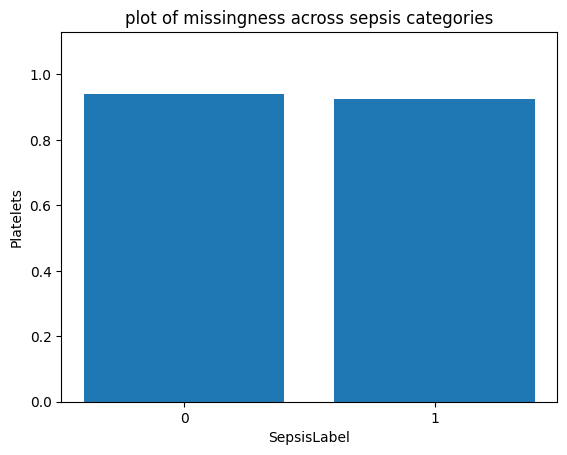

Age
Gender
HospAdmTime


KeyError: 1

In [6]:
for var in df.columns: 
    if var!= 'Patient_id' or  var!= 'HospAdmTime' or var!='SepsisLabel' :
        print(var)
        missing_counts = df[df[var].isnull()].groupby('SepsisLabel').size()
        if len(missing_counts)!=0 :
            print(missing_counts[0]/len(df[df['SepsisLabel']==0]),missing_counts[1]/len(df[df['SepsisLabel']==1]))

            values = [missing_counts[0]/len(df[df['SepsisLabel']==0]),missing_counts[1]/len(df[df['SepsisLabel']==1])]
            labels = ['0', '1']

            # Create a bar plot
            plt.bar(labels, values)
            plt.xlabel('SepsisLabel')
            plt.ylabel(f'{var}')
            plt.title('plot of missingness across sepsis categories')
            plt.ylim(0, max(values) * 1.2)  # Set y-axis limit to accommodate values
            plt.show()

I identify features with a missingness difference of more than 0.05 percentage points between the two sepsis labels. Using the heatmap analysis, I check for high correlations among these features. Since these features exhibit higher missingness in sepsis label 0 compared to 1 (as can be seen in bar plots) and are positively correlated (heat maps exhibiting missingness patterns), I deduce that counting missingness for one feature accounts for the missingness in the other highly correlated feature as well. Therefore, I do not consider the missingness of the latter variable separately and include it as a feature to reduce model dimensionality. Based on this analysis, I select O2SAT and pH as my final features

In [304]:
o2sat = df[df['O2Sat'].isnull()].groupby('Patient_id').size()
o2sat= pd.DataFrame(o2sat)

In [305]:
ph = df[df['pH'].isnull()].groupby('Patient_id').size()
ph=pd.DataFrame(ph)

In [306]:
merged_df = pd.merge(ph, o2sat, on='Patient_id', how='left')


In [10]:
df= pd.merge(df, merged_df, on='Patient_id', how='left')

In [11]:
df

Patient_id     HR  O2Sat   Temp    SBP   MAP   DBP  Resp  EtCO2  \
0          p116812    NaN    NaN    NaN    NaN   NaN   NaN   NaN    NaN   
1          p116812  102.0  100.0    NaN    NaN   NaN   NaN  22.0    NaN   
2          p116812  102.0  100.0    NaN   99.0  84.0  76.0  18.5    NaN   
3          p116812  124.0  100.0    NaN   97.0  70.0  55.0  16.0    NaN   
4          p116812   98.0  100.0    NaN   95.0  73.0  62.0  18.0    NaN   
...            ...    ...    ...    ...    ...   ...   ...   ...    ...   
1048570    p016300   89.0  100.0  36.44   97.0  67.0  54.0  24.0    NaN   
1048571    p016300   92.0  100.0    NaN  130.0  86.0  62.0  21.0    NaN   
1048572    p016300   94.0  100.0    NaN  105.0  74.0  59.0  17.0    NaN   
1048573    p016300   95.0  100.0  36.89   89.0  65.0  53.0  20.0    NaN   
1048574    p016300   92.0  100.0    NaN  112.0  77.0  60.0  17.0    NaN   

         BaseExcess  ...  Fibrinogen  Platelets    Age  Gender  HospAdmTime  \
0               NaN  ...         NaN        NaN  59.00       1        -6.01   
1               NaN  ...         NaN        NaN  59.00       1        -6.01   
2               NaN  ...         NaN        NaN  59.00       1        -6.01   
3               NaN  ...         NaN        NaN  59.00       1        -6.01   
4               NaN  ...         NaN      276.0  59.00       1        -6.01   
...             ...  ...         ...        ...    ...     ...          ...   
1048570         NaN  ...         NaN        NaN  68.62       1      -115.55   
1048571         NaN  ...         NaN        NaN  68.62       1      -115.55   
1048572        -1.0  ...         NaN        NaN  68.62       1      -115.55   
1048573         NaN  ...         NaN        NaN  68.62       1      -115.55   
1048574         NaN  ...         NaN        NaN  68.62       1      -115.55   

         ICULOS  SepsisLabel  Age_Category   0_x  0_y  
0             1            0             2  44.0  1.0  
1             2            0             2  44.0  1.0  
2             3            0             2  44.0  1.0  
3             4            0             2  44.0  1.0  
4             5            0             2  44.0  1.0  
...         ...          ...           ...   ...  ...  
1048570       6            0             3   8.0  1.0  
1048571       7            0             3   8.0  1.0  
1048572       8            0             3   8.0  1.0  
1048573       9            0             3   8.0  1.0  
1048574      10            0             3   8.0  1.0  

[1048575 rows x 43 columns]

XGboost is a supervised learning algorithm therefore we need to treat our time series as such. I collapse all the rows per individual to a single row, adding extra features that can capture the temporaility of the time series. the below code is creating rolling window statistics (mean, median, std, min, max) for all variables in our dataset, aggregating these statistics per patient, and storing the results in a dictionary for further analysis. we convert this dictionary to a dataframe and append it to our original dataset that now has one row per patient. Calculating rolling window statistics such as mean, median, std, min, and max helps capture the trends and patterns within each patient's time series data. These statistics provide information about the central tendency, variability, and extreme values over time.


In [ ]:
df_windows = {}

for var in df.columns:
    if var not in ['Patient_id', 'Age', 'Gender', 'HospAdmTime', 'ICULOS', 'SepsisLabel', '0_x', '0_y']:
        print(var)
        result = df.groupby('Patient_id')[var].rolling(window=10, min_periods=1).mean()


        stats=[]
        for id in df['Patient_id'].unique():
            #print(result[id].agg(['mean', 'median', 'std', 'min', 'max']))
            stats.append(result[id].agg(['mean', 'median', 'std', 'min', 'max']))
            
            stats = pd.DataFrame(stats)
            stats['Patient_id'] = id
            
            # Rename columns
            stats = stats.rename(columns={
                'mean': f'Mean_{var}',
                'median': f'Median_{var}',
                'std': f'Std_{var}',
                'min': f'Min_{var}',
                'max': f'Max_{var}'
            })
            if id == df['Patient_id'][0]:
                df_windows[f'df_window_{var}'] = stats
                
            else:
                df_windows[f'df_window_{var}'] = pd.concat([df_windows[f'df_window_{var}'], stats], ignore_index=True)
            #print('df: ',df_windows)
            stats=[]




In [27]:
df_windows

{'df_window_HR':           Mean_HR   Median_HR     Std_HR  Min_HR      Max_HR Patient_id
 0       93.042239   89.700000   6.807544  86.750  109.333333    p116812
 1       92.077197   91.777778   3.358864  84.500   97.750000    p109932
 2       83.516457   84.900000   6.693601  73.050   95.300000    p014977
 3       88.617802   89.111111   5.910130  78.000   98.000000    p000902
 4      104.212823  101.750000   4.369410  99.375  111.000000    p009098
 ...           ...         ...        ...     ...         ...        ...
 27181  120.925518  126.055556  13.182204  88.500  135.600000    p006113
 27182   90.228951   90.500000   1.347132  86.000   91.750000    p102407
 27183   84.939418   84.194444   2.882919  81.500   90.666667    p009220
 27184   99.309921  100.472222   4.215971  91.700  104.600000    p112614
 27185   88.551279   88.400000   1.529244  86.000   90.555556    p016300
 
 [27186 rows x 6 columns],
 'df_window_O2Sat':        Mean_O2Sat  Median_O2Sat  Std_O2Sat   Min_O2Sat   Ma

In [50]:
for key  in df_windows:
    if key == 'df_window_HR':
        merged_df = df_windows['df_window_HR']
    else:
        merged_df = pd.merge(merged_df, df_windows[key], on='Patient_id', how='inner')

In [51]:
merged_df

Mean_HR   Median_HR     Std_HR  Min_HR      Max_HR Patient_id  \
0       93.042239   89.700000   6.807544  86.750  109.333333    p116812   
1       92.077197   91.777778   3.358864  84.500   97.750000    p109932   
2       83.516457   84.900000   6.693601  73.050   95.300000    p014977   
3       88.617802   89.111111   5.910130  78.000   98.000000    p000902   
4      104.212823  101.750000   4.369410  99.375  111.000000    p009098   
...           ...         ...        ...     ...         ...        ...   
27181  120.925518  126.055556  13.182204  88.500  135.600000    p006113   
27182   90.228951   90.500000   1.347132  86.000   91.750000    p102407   
27183   84.939418   84.194444   2.882919  81.500   90.666667    p009220   
27184   99.309921  100.472222   4.215971  91.700  104.600000    p112614   
27185   88.551279   88.400000   1.529244  86.000   90.555556    p016300   

       Mean_O2Sat  Median_O2Sat  Std_O2Sat   Min_O2Sat  ...  Mean_SepsisLabel  \
0       99.536582     99.500000   0.302397   99.100000  ...               0.0   
1       93.259190     92.222222   2.293484   90.350000  ...               0.0   
2       98.201818     98.450000   1.352397   95.200000  ...               0.0   
3       97.817663     97.800000   1.119366   95.750000  ...               0.0   
4       95.312630     95.500000   0.886191   93.888889  ...               0.0   
...           ...           ...        ...         ...  ...               ...   
27181  100.000000    100.000000   0.000000  100.000000  ...               0.0   
27182   96.118107     96.200000   0.858397   94.000000  ...               0.0   
27183   95.263889     95.111111   1.109077   94.000000  ...               0.0   
27184   98.064066     98.183333   1.122858   94.666667  ...               0.0   
27185  100.000000    100.000000   0.000000  100.000000  ...               0.0   

       Median_SepsisLabel  Std_SepsisLabel  Min_SepsisLabel  Max_SepsisLabel  \
0                     0.0              0.0              0.0              0.0   
1                     0.0              0.0              0.0              0.0   
2                     0.0              0.0              0.0              0.0   
3                     0.0              0.0              0.0              0.0   
4                     0.0              0.0              0.0              0.0   
...                   ...              ...              ...              ...   
27181                 0.0              0.0              0.0              0.0   
27182                 0.0              0.0              0.0              0.0   
27183                 0.0              0.0              0.0              0.0   
27184                 0.0              0.0              0.0              0.0   
27185                 0.0              0.0              0.0              0.0   

       Mean_Age_Category  Median_Age_Category  Std_Age_Category  \
0                    2.0                  2.0               0.0   
1                    2.0                  2.0               0.0   
2                    3.0                  3.0               0.0   
3                    3.0                  3.0               0.0   
4                    2.0                  2.0               0.0   
...                  ...                  ...               ...   
27181                1.0                  1.0               0.0   
27182                2.0                  2.0               0.0   
27183                2.0                  2.0               0.0   
27184                2.0                  2.0               0.0   
27185                3.0                  3.0               0.0   

       Min_Age_Category  Max_Age_Category  
0                   2.0               2.0  
1                   2.0               2.0  
2                   3.0               3.0  
3                   3.0               3.0  
4                   2.0               2.0  
...                 ...               ...  
27181               1.0               1.0  
27182             

In [47]:
len(df['Patient_id'].unique())

27186

In [52]:
merged_df.to_csv('C:/Users/anshi/Desktop/portfolio/dfWindow.csv', index=False)


In [ ]:
merged_df.drop('')

In [44]:
df_last_rows = df.drop_duplicates(subset='Patient_id', keep='last')


In [45]:
df_last_rows


Patient_id     HR  O2Sat   Temp    SBP     MAP   DBP  Resp  EtCO2  \
43         p116812   94.0  100.0    NaN  100.0   76.00  59.0  20.0    NaN   
84         p109932   97.0   91.0  37.00  126.0   94.00  79.0  22.0    NaN   
139        p014977   94.0   97.0    NaN  130.0   73.00  43.0  20.0    NaN   
183        p000902   90.0    NaN  37.28   81.0   75.00  56.0  15.0    NaN   
218        p009098  113.0  100.0    NaN  159.0   99.67   NaN  21.0    NaN   
...            ...    ...    ...    ...    ...     ...   ...   ...    ...   
1048482    p006113    NaN    NaN    NaN    NaN     NaN   NaN   NaN    NaN   
1048506    p102407   91.0   93.0    NaN  127.0   86.00  72.0   NaN    NaN   
1048525    p009220   90.0   96.0    NaN  119.0   81.67   NaN  18.0    NaN   
1048564    p112614  103.0   95.0    NaN  153.0  106.00  74.0  20.0    NaN   
1048574    p016300   92.0  100.0    NaN  112.0   77.00  60.0  17.0    NaN   

         BaseExcess  ...  Fibrinogen  Platelets    Age  Gender  HospAdmTime  \
43              NaN  ...         NaN        NaN  59.00       1        -6.01   
84              NaN  ...         NaN        NaN  51.00       1       -21.47   
139             NaN  ...         NaN        NaN  77.27       1       -69.14   
183             NaN  ...         NaN        NaN  65.55       1        -0.02   
218             NaN  ...         NaN        NaN  52.16       0        -0.03   
...             ...  ...         ...        ...    ...     ...          ...   
1048482         NaN  ...         NaN        NaN  22.07       1        -0.01   
1048506         NaN  ...         NaN        NaN  49.00       1       -23.25   
1048525         NaN  ...         NaN        NaN  47.92       1        -0.04   
1048564         NaN  ...         NaN        NaN  48.00       0      -122.36   
1048574         NaN  ...         NaN        NaN  68.62       1      -115.55   

         ICULOS  SepsisLabel  Age_Category   0_x   0_y  
43           44            0             2  44.0   1.0  
84           48            0             2  30.0   2.0  
139          57            0             3  34.0   NaN  
183          44            0             3  44.0  13.0  
218          36            0             2  35.0   8.0  
...         ...          ...           ...   ...   ...  
1048482      37            0             1  26.0  28.0  
1048506      24            0             2  24.0   2.0  
1048525      19            0             2  19.0   2.0  
1048564      39            0             2  39.0   2.0  
1048574      10            0             3   8.0   1.0  

[27186 rows x 43 columns]

In [53]:
final_df = pd.merge(df_last_rows, merged_df, on='Patient_id', how='inner')

In [54]:
final_df

Patient_id     HR  O2Sat   Temp    SBP     MAP   DBP  Resp  EtCO2  \
0        p116812   94.0  100.0    NaN  100.0   76.00  59.0  20.0    NaN   
1        p109932   97.0   91.0  37.00  126.0   94.00  79.0  22.0    NaN   
2        p014977   94.0   97.0    NaN  130.0   73.00  43.0  20.0    NaN   
3        p000902   90.0    NaN  37.28   81.0   75.00  56.0  15.0    NaN   
4        p009098  113.0  100.0    NaN  159.0   99.67   NaN  21.0    NaN   
...          ...    ...    ...    ...    ...     ...   ...   ...    ...   
27181    p006113    NaN    NaN    NaN    NaN     NaN   NaN   NaN    NaN   
27182    p102407   91.0   93.0    NaN  127.0   86.00  72.0   NaN    NaN   
27183    p009220   90.0   96.0    NaN  119.0   81.67   NaN  18.0    NaN   
27184    p112614  103.0   95.0    NaN  153.0  106.00  74.0  20.0    NaN   
27185    p016300   92.0  100.0    NaN  112.0   77.00  60.0  17.0    NaN   

       BaseExcess  ...  Mean_SepsisLabel  Median_SepsisLabel  Std_SepsisLabel  \
0             NaN  ...               0.0                 0.0              0.0   
1             NaN  ...               0.0                 0.0              0.0   
2             NaN  ...               0.0                 0.0              0.0   
3             NaN  ...               0.0                 0.0              0.0   
4             NaN  ...               0.0                 0.0              0.0   
...           ...  ...               ...                 ...              ...   
27181         NaN  ...               0.0                 0.0              0.0   
27182         NaN  ...               0.0                 0.0              0.0   
27183         NaN  ...               0.0                 0.0              0.0   
27184         NaN  ...               0.0                 0.0              0.0   
27185         NaN  ...               0.0                 0.0              0.0   

       Min_SepsisLabel  Max_SepsisLabel  Mean_Age_Category  \
0                  0.0              0.0                2.0   
1                  0.0              0.0                2.0   
2                  0.0              0.0                3.0   
3                  0.0              0.0                3.0   
4                  0.0              0.0                2.0   
...                ...              ...                ...   
27181              0.0              0.0                1.0   
27182              0.0              0.0                2.0   
27183              0.0              0.0                2.0   
27184              0.0              0.0                2.0   
27185              0.0              0.0                3.0   

       Median_Age_Category  Std_Age_Category  Min_Age_Category  \
0                      2.0               0.0               2.0   
1                      2.0               0.0               2.0   
2                      3.0               0.0               3.0   
3                      3.0               0.0               3.0   
4                      2.0               0.0               2.0   
...                    ...               ...               ...   
27181                  1.0               0.0               1.0   
27182                  2.0               0.0               2.0   
27183                  2.0               0.0               2.0   
27184                  2.0               0.0               2.0   
27185                  3.0               0.0               3.0   

       Max_Age_Category  
0                   2.0  
1                   2.0  
2                   3.0  
3                   3.0  
4                   2.0  
...                 ...  
27181               1.0  
27182               2.0  
27183               2.0  
27184               2.0  
27185               3.0  

[27186 rows x 243 columns]

In [68]:
final_df=final_df.iloc[:, :-30]

In [69]:
final_df

Patient_id     HR  O2Sat   Temp    SBP     MAP   DBP  Resp  EtCO2  \
0        p116812   94.0  100.0    NaN  100.0   76.00  59.0  20.0    NaN   
1        p109932   97.0   91.0  37.00  126.0   94.00  79.0  22.0    NaN   
2        p014977   94.0   97.0    NaN  130.0   73.00  43.0  20.0    NaN   
3        p000902   90.0    NaN  37.28   81.0   75.00  56.0  15.0    NaN   
4        p009098  113.0  100.0    NaN  159.0   99.67   NaN  21.0    NaN   
...          ...    ...    ...    ...    ...     ...   ...   ...    ...   
27181    p006113    NaN    NaN    NaN    NaN     NaN   NaN   NaN    NaN   
27182    p102407   91.0   93.0    NaN  127.0   86.00  72.0   NaN    NaN   
27183    p009220   90.0   96.0    NaN  119.0   81.67   NaN  18.0    NaN   
27184    p112614  103.0   95.0    NaN  153.0  106.00  74.0  20.0    NaN   
27185    p016300   92.0  100.0    NaN  112.0   77.00  60.0  17.0    NaN   

       BaseExcess  ...  Mean_Fibrinogen  Median_Fibrinogen  Std_Fibrinogen  \
0             NaN  ...              NaN                NaN             NaN   
1             NaN  ...       204.882353         201.666667       28.044143   
2             NaN  ...       223.000000         223.000000        0.000000   
3             NaN  ...              NaN                NaN             NaN   
4             NaN  ...              NaN                NaN             NaN   
...           ...  ...              ...                ...             ...   
27181         NaN  ...              NaN                NaN             NaN   
27182         NaN  ...              NaN                NaN             NaN   
27183         NaN  ...              NaN                NaN             NaN   
27184         NaN  ...              NaN                NaN             NaN   
27185         NaN  ...              NaN                NaN             NaN   

       Min_Fibrinogen  Max_Fibrinogen  Mean_Platelets  Median_Platelets  \
0                 NaN             NaN      303.500000             303.5   
1               159.0           238.0      103.225490             104.5   
2               223.0           223.0      144.235294             160.0   
3                 NaN             NaN      208.062500             220.0   
4                 NaN             NaN      174.500000             174.5   
...               ...             ...             ...               ...   
27181             NaN             NaN      177.296296             162.5   
27182             NaN             NaN      241.000000             241.0   
27183             NaN             NaN      179.000000             179.0   
27184             NaN             NaN       79.750000              73.0   
27185             NaN             NaN             NaN               NaN   

       Std_Platelets  Min_Platelets  Max_Platelets  
0          28.214405     276.000000          331.0  
1          15.141637      81.666667          132.5  
2          25.777673     105.000000          164.5  
3          40.499681     159.000000          255.0  
4          24.110491     151.000000          198.0  
...              ...            ...            ...  
27181      77.328655      88.000000          311.0  
27182       0.000000     241.000000          241.0  
27183       0.000000     179.000000          179.0  
27184       9.000000      73.000000           91.0  
27185            NaN            NaN            NaN  

[27186 rows x 213 columns]

In [ ]:
pip install scikit-learn

In [84]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

final_df= final_df.drop('Patient_id', axis=1)
X= final_df.drop('SepsisLabel', axis=1)
y= final_df['SepsisLabel']

class imbalance: we see that only 7.32 percent of patients have a sepsis attack. therefore, we split the data into traininf and testing using stratification to maintain the same % of patients who develop sepsis.  

In [103]:
sum(y)/len(y)

0.07316265725005518

In [161]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [162]:
sum(y_train)/len(y_train)

0.0731739358906989

In [163]:
sum(y_test)/len(y_test)

0.07319764590485532

In [164]:
sum(y_val)/len(y_val)

0.07304256437204414

In [165]:
scaler=StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled=scaler.fit_transform(X_test)
X_val_scaled= scaler.fit_transform(X_val)

In [166]:
X_train

HR  O2Sat  Temp     SBP    MAP   DBP  Resp  EtCO2  BaseExcess  HCO3  \
5332     NaN   93.0   NaN     NaN    NaN   NaN   NaN    NaN         NaN   NaN   
8587    74.0   97.0   NaN  124.00  104.0  84.0  18.0    NaN         NaN   NaN   
25582   90.0  100.0   NaN  124.00   89.0  65.0  20.0    NaN         NaN   NaN   
17450   66.0   99.0   NaN  151.00   88.0  56.0  11.0    NaN         NaN   NaN   
13327  116.5   96.0   NaN   82.75   56.5  45.5  26.5    NaN         NaN   NaN   
...      ...    ...   ...     ...    ...   ...   ...    ...         ...   ...   
583     95.0   97.0   NaN   96.00   70.0  57.0  16.0    NaN         NaN   NaN   
10495    NaN    NaN   NaN     NaN    NaN   NaN   NaN    NaN         NaN   NaN   
2245    94.0   93.0   NaN  184.00  112.0  82.0  13.0    NaN         NaN   NaN   
6789     NaN    NaN   NaN     NaN    NaN   NaN   NaN    NaN         NaN   NaN   
3798    64.0   98.0   NaN  103.00   81.0  70.0  15.0    NaN         NaN   NaN   

       ...  Mean_Fibrinogen  Median_Fibrinogen  Std_Fibrinogen  \
5332   ...              NaN                NaN             NaN   
8587   ...              NaN                NaN             NaN   
25582  ...              NaN                NaN             NaN   
17450  ...              NaN                NaN             NaN   
13327  ...            188.0              188.0             0.0   
...    ...              ...                ...             ...   
583    ...              NaN                NaN             NaN   
10495  ...              NaN                NaN             NaN   
2245   ...              NaN                NaN             NaN   
6789   ...            318.0              318.0             0.0   
3798   ...              NaN                NaN             NaN   

       Min_Fibrinogen  Max_Fibrinogen  Mean_Platelets  Median_Platelets  \
5332              NaN             NaN      329.000000             329.0   
8587              NaN             NaN      159.352941             161.0   
25582             NaN             NaN      354.000000             354.0   
17450             NaN             NaN      311.571429             331.0   
13327           188.0           188.0      137.607143             136.5   
...               ...             ...             ...               ...   
583               NaN             NaN      136.368421             152.0   
10495             NaN             NaN             NaN               NaN   
2245              NaN             NaN      133.461538             137.0   
6789            318.0           318.0      178.000000             178.0   
3798              NaN             NaN      333.571429             353.0   

       Std_Platelets  Min_Platelets  Max_Platelets  
5332        0.000000          329.0          329.0  
8587        2.029199          157.0          161.0  
25582       0.000000          354.0          354.0  
17450      31.878892          263.0          331.0  
13327       5.601516          128.0          145.0  
...              ...            ...            ...  
583        16.928643          119.0          152.0  
10495            NaN            NaN            NaN  
2245        6.592303          123.0          139.0  
6789        9.233805          169.0          187.0  
3798       31.878892          285.0          353.0  

[15224 rows x 211 columns]

In [ ]:
pip install xgboost

creating a simple XGboost model first 

In [196]:
import xgboost as xgb 

model=xgb.XGBClassifier(n_estimators=1500)
print(model)
model.fit(X_train_scaled, y_train, early_stopping_rounds=100, verbose=True, eval_metric='aucpr', eval_set=[(X_val_scaled, y_val)])


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1500, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)


C:\Users\anshi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\anshi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-aucpr:0.55767
[1]	validation_0-aucpr:0.59350
[2]	validation_0-aucpr:0.63123
[3]	validation_0-aucpr:0.64527
[4]	validation_0-aucpr:0.66604
[5]	validation_0-aucpr:0.66651
[6]	validation_0-aucpr:0.67220
[7]	validation_0-aucpr:0.66923
[8]	validation_0-aucpr:0.67262
[9]	validation_0-aucpr:0.67630
[10]	validation_0-aucpr:0.67752
[11]	validation_0-aucpr:0.67758
[12]	validation_0-aucpr:0.67480
[13]	validation_0-aucpr:0.67178
[14]	validation_0-aucpr:0.67193
[15]	validation_0-aucpr:0.67188
[16]	validation_0-aucpr:0.67480
[17]	validation_0-aucpr:0.67415
[18]	validation_0-aucpr:0.67519
[19]	validation_0-aucpr:0.67482
[20]	validation_0-aucpr:0.67373
[21]	validation_0-aucpr:0.67742
[22]	validation_0-aucpr:0.67744
[23]	validation_0-aucpr:0.67805
[24]	validation_0-aucpr:0.68310
[25]	validation_0-aucpr:0.67903
[26]	validation_0-aucpr:0.68075
[27]	validation_0-aucpr:0.68126
[28]	validation_0-aucpr:0.68025
[29]	validation_0-aucpr:0.67905
[30]	validation_0-aucpr:0.67632
[31]	validation_0-

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1500, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [127]:
type(model)

xgboost.sklearn.XGBClassifier

In [197]:
import numpy as np
y_pred = model.predict(X_test_scaled)
np.unique(y_pred)


array([0, 1])

We notice that though precision is high, recall is quite low, i.e., close to 50%. This means that our model's ability to correctly identify positive instances out of all actual positive instances is low. 


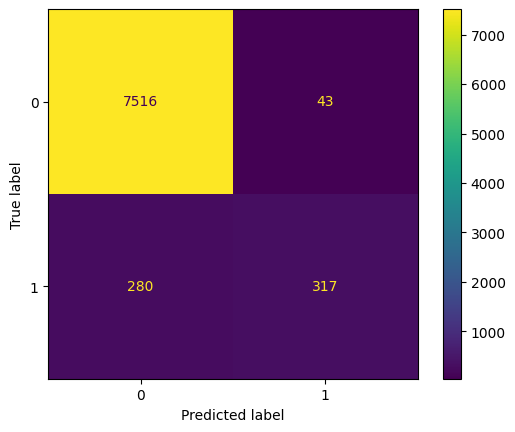

In [198]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf_matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot()


In [188]:
x = model.get_booster().get_score(importance_type='gain')
type(x)

dict

In [195]:
final_df.iloc[:, 135]

0          NaN
1        107.0
2        104.0
3        103.0
4        105.0
         ...  
27181    110.0
27182      NaN
27183    104.0
27184      NaN
27185      NaN
Name: Min_Chloride, Length: 27186, dtype: float64

In [191]:
sorted_dict = dict(sorted(x.items(), key=lambda x: x[1], reverse=True))
sorted_dict

{'f37': 16.534137725830078,
 'f39': 15.570674896240234,
 'f8': 7.690324306488037,
 'f10': 6.916266918182373,
 'f135': 6.580254554748535,
 'f143': 6.4687628746032715,
 'f12': 6.1143341064453125,
 'f30': 6.064373016357422,
 'f121': 6.0315351486206055,
 'f94': 5.761657238006592,
 'f80': 5.690698146820068,
 'f76': 5.514657020568848,
 'f123': 5.172025203704834,
 'f175': 4.994856357574463,
 'f7': 4.983269214630127,
 'f13': 4.699026107788086,
 'f22': 4.536955833435059,
 'f201': 4.391288757324219,
 'f79': 4.029098033905029,
 'f202': 3.6794302463531494,
 'f92': 3.5959362983703613,
 'f120': 3.593181610107422,
 'f152': 3.5788655281066895,
 'f55': 3.4753808975219727,
 'f11': 3.317746877670288,
 'f0': 3.1925203800201416,
 'f154': 3.162449359893799,
 'f95': 3.1603894233703613,
 'f9': 3.1555566787719727,
 'f141': 3.069596529006958,
 'f36': 3.0012474060058594,
 'f56': 2.893702268600464,
 'f4': 2.8311548233032227,
 'f23': 2.754805088043213,
 'f112': 2.674952268600464,
 'f124': 2.652658462524414,
 'f18'

Now we shall implement a more complex xgboost. we start with hyperparameter optimisation. 

I selected randomised search over grid search for hyperparameter optimisation. When the parameter space is large or when computational resources are limited, Randomized Search can find a good set of parameters in less time than it would take for Grid Search to complete.

In [234]:
#hyperparam optimisation 

params={
    "learning_rate": [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
    "max_depth": [3,4,5,6,8,12,15],
    "min_child_weight":[1,3,5,7],
    "gamma": [0.0,0.1,0.2,0.3,0.4],
    "colsample_bytree":[0.3,0.4,0.5,0.7],
    "n_estimators":[600,700,800,900,1000,1100]
}

In [259]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

model2=xgb.XGBClassifier()
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_Search= RandomizedSearchCV(model2, param_distributions=params, n_iter=20,scoring='roc_auc', n_jobs=-1,cv=stratified_kfold,  verbose=3)

In [260]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


standardising training and test separately to avoid data leakage while training. 

In [261]:
scaler=StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled=scaler.fit_transform(X_test)


In [262]:
print(sum(y_train)/len(y_train))
print(sum(y_test)/len(y_test))

0.07314766158696795
0.07319764590485532


In [263]:
random_Search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importan...
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5,
                                                             0.7],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [3, 4, 5, 6, 8, 12, 15],
                                        'min_child_weight': [1, 3, 5, 7],
                                        'n_estimators': [600, 700, 800, 900,
                                                         1000, 1100]},
                   scoring='roc_auc', verbose=3)

In [265]:
random_Search.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.3, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.4, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.15, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=700, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [266]:
random_Search.best_params_

{'n_estimators': 700,
 'min_child_weight': 7,
 'max_depth': 15,
 'learning_rate': 0.15,
 'gamma': 0.4,
 'colsample_bytree': 0.3}

In [267]:
model2= xgb.XGBClassifier(n_estimators=700, min_child_weight=7, max_depth=15, learning_rate=0.15, gamma=0.4, colsample_bytree=0.3)

In [268]:
model2.fit(X_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.3, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.4, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.15, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=700, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [275]:
from sklearn.model_selection import cross_val_score
score=cross_val_score(model2, X_test_scaled, y_test, cv=5)

In [276]:
score

array([0.95159314, 0.96137339, 0.95953403, 0.96321275, 0.96443899])

In [269]:
import numpy as np
y_pred = model2.predict(X_test_scaled)
np.unique(y_pred)

array([0, 1])

Here we notice an improvement in recall while precision remains more or less stable. Recall now stands at ~57% compared to our naive xgboost's performance of ~53%. This is not a major improvement, however, is a step in the right direction. F1 score provides a balanced measure of a model's performance, especially when there is an imbalance between the classes. Therefore, we measure F1 score which comes to around 72.35% compared to naive xgboost's 69.04%. 

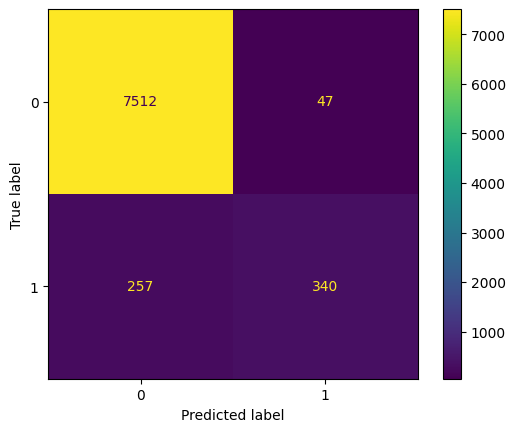

In [270]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf_matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot()


In [288]:
final_df.iloc[:,180]

0        0.03
1         NaN
2         NaN
3         NaN
4         NaN
         ... 
27181     NaN
27182     NaN
27183     NaN
27184     NaN
27185     NaN
Name: Min_TroponinI, Length: 27186, dtype: float64

In [271]:
x = model.get_booster().get_score(importance_type='gain')
sorted_dict = dict(sorted(x.items(), key=lambda x: x[1], reverse=True))
sorted_dict

{'f37': 16.534137725830078,
 'f39': 15.570674896240234,
 'f8': 7.690324306488037,
 'f10': 6.916266918182373,
 'f135': 6.580254554748535,
 'f143': 6.4687628746032715,
 'f12': 6.1143341064453125,
 'f30': 6.064373016357422,
 'f121': 6.0315351486206055,
 'f94': 5.761657238006592,
 'f80': 5.690698146820068,
 'f76': 5.514657020568848,
 'f123': 5.172025203704834,
 'f175': 4.994856357574463,
 'f7': 4.983269214630127,
 'f13': 4.699026107788086,
 'f22': 4.536955833435059,
 'f201': 4.391288757324219,
 'f79': 4.029098033905029,
 'f202': 3.6794302463531494,
 'f92': 3.5959362983703613,
 'f120': 3.593181610107422,
 'f152': 3.5788655281066895,
 'f55': 3.4753808975219727,
 'f11': 3.317746877670288,
 'f0': 3.1925203800201416,
 'f154': 3.162449359893799,
 'f95': 3.1603894233703613,
 'f9': 3.1555566787719727,
 'f141': 3.069596529006958,
 'f36': 3.0012474060058594,
 'f56': 2.893702268600464,
 'f4': 2.8311548233032227,
 'f23': 2.754805088043213,
 'f112': 2.674952268600464,
 'f124': 2.652658462524414,
 'f18'